#  Charegement et preparation  de la données 

In [2]:
import pandas as pd
import sklearn.preprocessing as preprocessing
df = pd.read_csv("Data_for_prediction.csv",low_memory=False)
X = df
def encode(X,X_test,categorical_columns):
    le = preprocessing.LabelEncoder()
    XX = X
    for i in categorical_columns : 
        le = preprocessing.LabelEncoder()
        le.fit(XX[i].astype(str))
        print(list(le.classes_))
        X[i] = le.transform(X[i].astype(str))

encode(X,X,["genre"])

XX = pd.DataFrame()
for i in range(0,15) : 
    X_curr = X[X["genre"] == i][0:6000]
    XX = pd.concat([XX , X_curr] , ignore_index=True)
    
y = XX['genre']
XX = XX.drop(["genre"] , axis= 1 )
XX.head()
XX = XX.drop(["key"] , axis= 1 )
XX = XX.drop(["mode"] , axis= 1 )



['Dark Trap', 'Emo', 'Hiphop', 'Pop', 'Rap', 'RnB', 'Trap Metal', 'Underground Rap', 'dnb', 'hardstyle', 'psytrance', 'techhouse', 'techno', 'trance', 'trap']


**Equilibrage des Données**

In [3]:
from sklearn import preprocessing
import imblearn
from imblearn.over_sampling import SMOTE
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(XX, y)

X_sm.shape


(88125, 25)

In [4]:
X_sm.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,RnB,Trap Metal,Underground Rap,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
0,0.831,0.814,-7.364,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,124539,...,0.913853,0.915898,0.905553,0.585015,0.679300,0.589886,0.626308,0.568642,0.562136,0.660077
1,0.719,0.493,-7.230,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,224427,...,0.117545,0.240131,0.076856,-0.036545,0.019016,-0.033106,0.096250,0.135577,-0.069401,0.220091
2,0.850,0.893,-4.783,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,98821,...,-0.263811,-0.168824,-0.338808,-0.188215,-0.150082,-0.257177,-0.194407,0.111461,-0.232145,-0.057473
3,0.476,0.781,-4.710,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,123661,...,0.770616,0.738761,0.793181,0.866356,0.649997,0.865518,0.860183,0.633164,0.775838,0.503591
4,0.798,0.624,-7.668,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,123298,...,0.848353,0.818072,0.776984,0.559438,0.578821,0.499398,0.595705,0.748138,0.414689,0.667744


***Sepration des data en ensemble de Test et de Train***

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.33, random_state=42)
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)


***Entrainement du model et son score***

In [17]:
clf = MLPClassifier(hidden_layer_sizes=(150,),activation="relu",random_state=1,max_iter= 1000,alpha= 0.001 ).fit(X_trainscaled, y_train)
y_pred = clf.predict(X_testscaled) # predictions
score = balanced_accuracy_score(y_test, y_pred) # scoring
print('balanced_accuracy score: {}'.format(score))
score = accuracy_score(y_test, y_pred) # scoring
print('accuracy score: {}'.format(score))

balanced_accuracy score: 0.7808999228859291
accuracy score: 0.7818581940719346


<AxesSubplot:>

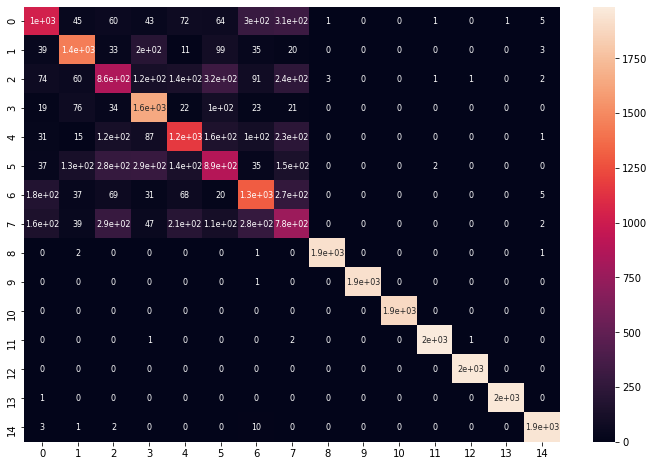

In [21]:
import seaborn as sn
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
df_cm= pd.DataFrame(cm)
plt.figure(figsize=(12,8))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})

In [8]:
mlp_gs = MLPClassifier(max_iter=1000)
parameter_space = {
    'hidden_layer_sizes': [(100,),(150,)],
    'alpha': [0.05 , 0.001 ],
    
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_trainscaled, y_train) # X is train samples and y is the corresponding labels

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000), n_jobs=-1,
             param_grid={'alpha': [0.05, 0.001],
                         'hidden_layer_sizes': [(100,), (150,)]})

In [9]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'alpha': 0.001, 'hidden_layer_sizes': (150,)}


In [10]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))   

0.770 (+/-0.005) for {'alpha': 0.05, 'hidden_layer_sizes': (100,)}
0.773 (+/-0.005) for {'alpha': 0.05, 'hidden_layer_sizes': (150,)}
0.774 (+/-0.005) for {'alpha': 0.001, 'hidden_layer_sizes': (100,)}
0.779 (+/-0.004) for {'alpha': 0.001, 'hidden_layer_sizes': (150,)}


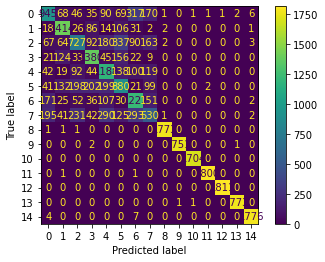

In [11]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_testscaled, y_test)

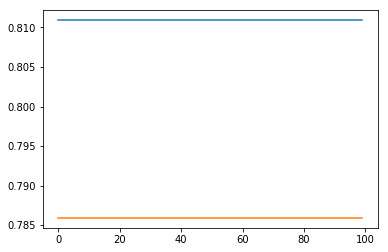

In [13]:
clf = MLPClassifier(hidden_layer_sizes=(150,),activation="relu",random_state=1,max_iter= 1000,alpha=0.05  ).fit(X_trainscaled, y_train)
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
)
y_pred = clf.predict(X_testscaled) # predictions
score = balanced_accuracy_score(y_test, y_pred) # scoring
print('balanced_accuracy score: {}'.format(score))
score = accuracy_score(y_test, y_pred) # scoring
print('accuracy score: {}'.format(score))

y_pred = clf.predict(X_trainscaled) # predictions
score = balanced_accuracy_score(y_train, y_pred) # scoring
print('balanced_accuracy score: {}'.format(score))
score = accuracy_score(y_train, y_pred) # scoring
print('accuracy score: {}'.format(score))

balanced_accuracy score: 0.7777670181487993
accuracy score: 0.7787275890763296
balanced_accuracy score: 0.792158422276059
accuracy score: 0.7917713618752735


In [20]:
clf = MLPClassifier(hidden_layer_sizes=(250,),activation="relu",random_state=42,max_iter= 1000,alpha=0.05  ).fit(X_trainscaled, y_train)
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
)
y_pred = clf.predict(X_testscaled) # predictions
score = balanced_accuracy_score(y_test, y_pred) # scoring
print('balanced_accuracy score: {}'.format(score))
score = accuracy_score(y_test, y_pred) # scoring
print('accuracy score: {}'.format(score))

y_pred = clf.predict(X_trainscaled) # predictions
score = balanced_accuracy_score(y_train, y_pred) # scoring
print('balanced_accuracy score: {}'.format(score))
score = accuracy_score(y_train, y_pred) # scoring
print('accuracy score: {}'.format(score))

balanced_accuracy score: 0.7907039214522499
accuracy score: 0.7918148120130116
balanced_accuracy score: 0.8096116614550846
accuracy score: 0.8091656264691102


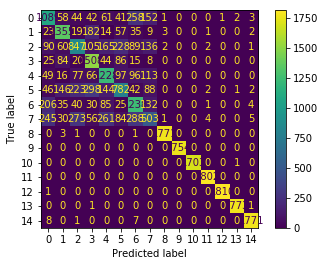

In [21]:
plot_confusion_matrix(clf, X_testscaled, y_test)

In [15]:
#clf = MLPClassifier(hidden_layer_sizes=(150,),activation="relu",random_state=1,max_iter= 1000).fit(X_trainscaled, y_train)
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
)
y_pred = clf.predict(X_testscaled) # predictions
score = balanced_accuracy_score(y_test, y_pred) # scoring
print('balanced_accuracy score: {}'.format(score))
score = accuracy_score(y_test, y_pred) # scoring
print('accuracy score: {}'.format(score))

balanced_accuracy score: 0.7869857131145059
accuracy score: 0.7878810802632574


In [16]:
y_pred = clf.predict(X_trainscaled) # predictions
score = balanced_accuracy_score(y_train, y_pred) # scoring
print('balanced_accuracy score: {}'.format(score))
score = accuracy_score(y_train, y_pred) # scoring
print('accuracy score: {}'.format(score))

balanced_accuracy score: 0.8104674636892278
accuracy score: 0.810105856987696


In [18]:
#clf = MLPClassifier(hidden_layer_sizes=(250,),activation="relu",random_state=42,max_iter= 800).fit(X_trainscaled, y_train)
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
)
y_pred = clf.predict(X_testscaled) # predictions
score = balanced_accuracy_score(y_test, y_pred) # scoring
print('balanced_accuracy score: {}'.format(score))
score = accuracy_score(y_test, y_pred) # scoring
print('accuracy score: {}'.format(score))

y_pred = clf.predict(X_trainscaled) # predictions
score = balanced_accuracy_score(y_train, y_pred) # scoring
print('balanced_accuracy score: {}'.format(score))
score = accuracy_score(y_train, y_pred) # scoring
print('accuracy score: {}'.format(score))

balanced_accuracy score: 0.7950448413549778
accuracy score: 0.7963537332627278
balanced_accuracy score: 0.8361525395634948
accuracy score: 0.8356541896996126


In [1]:
plot_confusion_matrix(clf, X_testscaled, y_test)

NameError: name 'plot_confusion_matrix' is not defined

In [28]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

model = clf.best_estimator_
clf.best_score_

0.776435875707703

In [33]:
N, train_score, val_score = learning_curve(model,X_trainscaled, y_train, train_sizes = np.linspace(0.2, 1.0, 5), cv = 3)

[ 8224 16449 24674 32899 41124]


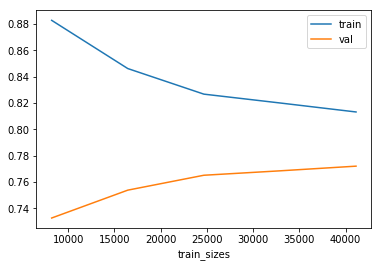

In [34]:
print(N) 
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1),label='val')
plt.xlabel('train_sizes')
plt.legend()

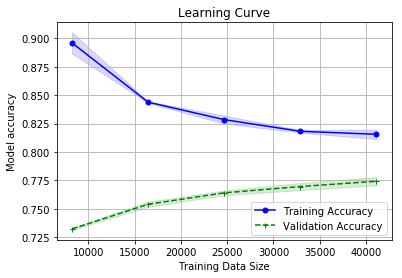

In [37]:
# Create training and test split
#
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)
# Create a pipeline; This will be passed as an estimator to learning curve method
#
#pipeline = make_pipeline(StandardScaler(),
 #                       LogisticRegression(penalty='l2', solver='lbfgs', random_state=1, max_iter=10000))
#
# Use learning curve to get training and test scores along with train sizes
#
train_sizes, train_scores, test_scores = learning_curve(model,X_trainscaled, y_train, train_sizes = np.linspace(0.2, 1.0, 5), cv = 3)
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [ ]:

clf = MLPClassifier(hidden_layer_sizes=(250,),activation="relu",random_state=42,max_iter=1500 , learning_rate_init = 0.0001).fit(X_trainscaled, y_train)
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
)
y_pred = clf.predict(X_testscaled) # predictions
score = balanced_accuracy_score(y_test, y_pred) # scoring
print('balanced_accuracy score: {}'.format(score))
score = accuracy_score(y_test, y_pred) # scoring
print('accuracy score: {}'.format(score))

y_pred = clf.predict(X_trainscaled) # predictions
score = balanced_accuracy_score(y_train, y_pred) # scoring
print('balanced_accuracy score: {}'.format(score))
score = accuracy_score(y_train, y_pred) # scoring
print('accuracy score: {}'.format(score))

In [23]:
import numpy as np 
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

standardScalar = StandardScaler()
mlp = MLPClassifier()

pipe = Pipeline(steps=[('standardScalar', standardScalar), ('mlp', mlp)])


#param_grid = { 'svm__C':[1,100],'svm__kernel':('sigmoid','rbf')  }
parameter_space = {
    'mlp__hidden_layer_sizes':np.arange(50,250,50),
    'mlp__activation': [ 'relu', 'tanh'],
    'mlp__solver': [ 'adam' ],
    'mlp__alpha': [ 0.001 ],
    'mlp__learning_rate_init' :np.linspace(0.0001 ,0.01,6),
    'mlp__learning_rate': ['constant'],
    'mlp__max_iter':[1400],
    'mlp__verbose':['True']
}
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, parameter_space, cv=3 , return_train_score = True )
grid.fit(X_sm, y_sm) # X is train samples and y is the corresponding labels

Iteration 1, loss = 2.71206014
Iteration 2, loss = 2.08415213
Iteration 3, loss = 1.69178014
Iteration 4, loss = 1.44237785
Iteration 5, loss = 1.27639413
Iteration 6, loss = 1.16025479
Iteration 7, loss = 1.07495433
Iteration 8, loss = 1.01010473
Iteration 9, loss = 0.95960930
Iteration 10, loss = 0.91979432
Iteration 11, loss = 0.88806940
Iteration 12, loss = 0.86245916
Iteration 13, loss = 0.84142923
Iteration 14, loss = 0.82404633
Iteration 15, loss = 0.80929786
Iteration 16, loss = 0.79674547
Iteration 17, loss = 0.78589588
Iteration 18, loss = 0.77650891
Iteration 19, loss = 0.76841349
Iteration 20, loss = 0.76116007
Iteration 21, loss = 0.75492265
Iteration 22, loss = 0.74926064
Iteration 23, loss = 0.74417826
Iteration 24, loss = 0.73969350
Iteration 25, loss = 0.73553725
Iteration 26, loss = 0.73178672
Iteration 27, loss = 0.72839585
Iteration 28, loss = 0.72525519
Iteration 29, loss = 0.72230325
Iteration 30, loss = 0.71955695
Iteration 31, loss = 0.71706317
Iteration 32, los

Iteration 253, loss = 0.60534879
Iteration 254, loss = 0.60518375
Iteration 255, loss = 0.60501694
Iteration 256, loss = 0.60492155
Iteration 257, loss = 0.60472513
Iteration 258, loss = 0.60457262
Iteration 259, loss = 0.60443867
Iteration 260, loss = 0.60423415
Iteration 261, loss = 0.60409132
Iteration 262, loss = 0.60397099
Iteration 263, loss = 0.60385695
Iteration 264, loss = 0.60366717
Iteration 265, loss = 0.60351818
Iteration 266, loss = 0.60333840
Iteration 267, loss = 0.60321656
Iteration 268, loss = 0.60309437
Iteration 269, loss = 0.60294931
Iteration 270, loss = 0.60283182
Iteration 271, loss = 0.60264893
Iteration 272, loss = 0.60255660
Iteration 273, loss = 0.60239531
Iteration 274, loss = 0.60218802
Iteration 275, loss = 0.60202116
Iteration 276, loss = 0.60197000
Iteration 277, loss = 0.60173412
Iteration 278, loss = 0.60168355
Iteration 279, loss = 0.60149426
Iteration 280, loss = 0.60140754
Iteration 281, loss = 0.60125862
Iteration 282, loss = 0.60111089
Iteration 

Iteration 53, loss = 0.75196284
Iteration 54, loss = 0.75100342
Iteration 55, loss = 0.74987276
Iteration 56, loss = 0.74896085
Iteration 57, loss = 0.74790858
Iteration 58, loss = 0.74699407
Iteration 59, loss = 0.74610735
Iteration 60, loss = 0.74515376
Iteration 61, loss = 0.74430461
Iteration 62, loss = 0.74343090
Iteration 63, loss = 0.74258365
Iteration 64, loss = 0.74168853
Iteration 65, loss = 0.74087526
Iteration 66, loss = 0.74006074
Iteration 67, loss = 0.73923369
Iteration 68, loss = 0.73851188
Iteration 69, loss = 0.73772581
Iteration 70, loss = 0.73698206
Iteration 71, loss = 0.73627367
Iteration 72, loss = 0.73552311
Iteration 73, loss = 0.73487521
Iteration 74, loss = 0.73403652
Iteration 75, loss = 0.73342873
Iteration 76, loss = 0.73271221
Iteration 77, loss = 0.73210869
Iteration 78, loss = 0.73143746
Iteration 79, loss = 0.73084062
Iteration 80, loss = 0.73010643
Iteration 81, loss = 0.72954426
Iteration 82, loss = 0.72889527
Iteration 83, loss = 0.72829269
Iteratio

Iteration 303, loss = 0.66901866
Iteration 304, loss = 0.66888078
Iteration 305, loss = 0.66876414
Iteration 306, loss = 0.66865241
Iteration 307, loss = 0.66857720
Iteration 308, loss = 0.66848152
Iteration 309, loss = 0.66830369
Iteration 310, loss = 0.66819635
Iteration 311, loss = 0.66811332
Iteration 312, loss = 0.66796144
Iteration 313, loss = 0.66787322
Iteration 314, loss = 0.66777000
Iteration 315, loss = 0.66767543
Iteration 316, loss = 0.66754274
Iteration 317, loss = 0.66738976
Iteration 318, loss = 0.66729757
Iteration 319, loss = 0.66719636
Iteration 320, loss = 0.66705435
Iteration 321, loss = 0.66698785
Iteration 322, loss = 0.66685101
Iteration 323, loss = 0.66679999
Iteration 324, loss = 0.66663691
Iteration 325, loss = 0.66647215
Iteration 326, loss = 0.66647519
Iteration 327, loss = 0.66633836
Iteration 328, loss = 0.66626919
Iteration 329, loss = 0.66614243
Iteration 330, loss = 0.66604071
Iteration 331, loss = 0.66597272
Iteration 332, loss = 0.66583513
Iteration 

Iteration 110, loss = 0.70973723
Iteration 111, loss = 0.70928657
Iteration 112, loss = 0.70886481
Iteration 113, loss = 0.70835131
Iteration 114, loss = 0.70798371
Iteration 115, loss = 0.70764441
Iteration 116, loss = 0.70716186
Iteration 117, loss = 0.70676511
Iteration 118, loss = 0.70635279
Iteration 119, loss = 0.70595073
Iteration 120, loss = 0.70555505
Iteration 121, loss = 0.70512437
Iteration 122, loss = 0.70471864
Iteration 123, loss = 0.70438397
Iteration 124, loss = 0.70394490
Iteration 125, loss = 0.70358856
Iteration 126, loss = 0.70312282
Iteration 127, loss = 0.70278667
Iteration 128, loss = 0.70238435
Iteration 129, loss = 0.70200425
Iteration 130, loss = 0.70157948
Iteration 131, loss = 0.70123657
Iteration 132, loss = 0.70084559
Iteration 133, loss = 0.70048471
Iteration 134, loss = 0.70011332
Iteration 135, loss = 0.69974464
Iteration 136, loss = 0.69939180
Iteration 137, loss = 0.69900681
Iteration 138, loss = 0.69864355
Iteration 139, loss = 0.69834123
Iteration 

Iteration 359, loss = 0.65711273
Iteration 360, loss = 0.65700439
Iteration 361, loss = 0.65690626
Iteration 362, loss = 0.65684759
Iteration 363, loss = 0.65670057
Iteration 364, loss = 0.65669186
Iteration 365, loss = 0.65660130
Iteration 366, loss = 0.65644883
Iteration 367, loss = 0.65631903
Iteration 368, loss = 0.65631690
Iteration 369, loss = 0.65623554
Iteration 370, loss = 0.65612799
Iteration 371, loss = 0.65602348
Iteration 372, loss = 0.65595036
Iteration 373, loss = 0.65589580
Iteration 374, loss = 0.65579915
Iteration 375, loss = 0.65567932
Iteration 376, loss = 0.65564399
Iteration 377, loss = 0.65550082
Iteration 378, loss = 0.65537645
Iteration 379, loss = 0.65522975
Iteration 380, loss = 0.65526179
Iteration 381, loss = 0.65513891
Iteration 382, loss = 0.65506114
Iteration 383, loss = 0.65497784
Iteration 384, loss = 0.65484963
Iteration 385, loss = 0.65484835
Iteration 386, loss = 0.65474290
Iteration 387, loss = 0.65461867
Iteration 388, loss = 0.65461601
Iteration 

Iteration 102, loss = 0.55693431
Iteration 103, loss = 0.55717400
Iteration 104, loss = 0.55686745
Iteration 105, loss = 0.55672181
Iteration 106, loss = 0.55662149
Iteration 107, loss = 0.55620331
Iteration 108, loss = 0.55617413
Iteration 109, loss = 0.55666437
Iteration 110, loss = 0.55590404
Iteration 111, loss = 0.55613936
Iteration 112, loss = 0.55641630
Iteration 113, loss = 0.55591497
Iteration 114, loss = 0.55506021
Iteration 115, loss = 0.55502869
Iteration 116, loss = 0.55545259
Iteration 117, loss = 0.55488179
Iteration 118, loss = 0.55516955
Iteration 119, loss = 0.55435033
Iteration 120, loss = 0.55388990
Iteration 121, loss = 0.55408316
Iteration 122, loss = 0.55506162
Iteration 123, loss = 0.55392830
Iteration 124, loss = 0.55372609
Iteration 125, loss = 0.55359228
Iteration 126, loss = 0.55314060
Iteration 127, loss = 0.55349272
Iteration 128, loss = 0.55372607
Iteration 129, loss = 0.55363921
Iteration 130, loss = 0.55336504
Iteration 131, loss = 0.55291794
Iteration 

Iteration 85, loss = 0.63598017
Iteration 86, loss = 0.63619351
Iteration 87, loss = 0.63516842
Iteration 88, loss = 0.63518813
Iteration 89, loss = 0.63530330
Iteration 90, loss = 0.63501072
Iteration 91, loss = 0.63507472
Iteration 92, loss = 0.63467266
Iteration 93, loss = 0.63550739
Iteration 94, loss = 0.63410928
Iteration 95, loss = 0.63517555
Iteration 96, loss = 0.63544049
Iteration 97, loss = 0.63413574
Iteration 98, loss = 0.63471827
Iteration 99, loss = 0.63426510
Iteration 100, loss = 0.63421018
Iteration 101, loss = 0.63391948
Iteration 102, loss = 0.63319653
Iteration 103, loss = 0.63394029
Iteration 104, loss = 0.63379174
Iteration 105, loss = 0.63365323
Iteration 106, loss = 0.63323259
Iteration 107, loss = 0.63285428
Iteration 108, loss = 0.63293064
Iteration 109, loss = 0.63258818
Iteration 110, loss = 0.63279112
Iteration 111, loss = 0.63258751
Iteration 112, loss = 0.63245705
Iteration 113, loss = 0.63230857
Iteration 114, loss = 0.63215628
Iteration 115, loss = 0.6

Iteration 89, loss = 0.62387335
Iteration 90, loss = 0.62391147
Iteration 91, loss = 0.62335327
Iteration 92, loss = 0.62356184
Iteration 93, loss = 0.62278474
Iteration 94, loss = 0.62200529
Iteration 95, loss = 0.62245017
Iteration 96, loss = 0.62296833
Iteration 97, loss = 0.62170285
Iteration 98, loss = 0.62257556
Iteration 99, loss = 0.62219187
Iteration 100, loss = 0.62270782
Iteration 101, loss = 0.62178864
Iteration 102, loss = 0.62132872
Iteration 103, loss = 0.62184722
Iteration 104, loss = 0.62188188
Iteration 105, loss = 0.62166830
Iteration 106, loss = 0.62049642
Iteration 107, loss = 0.62052753
Iteration 108, loss = 0.62109248
Iteration 109, loss = 0.62065779
Iteration 110, loss = 0.61957678
Iteration 111, loss = 0.62036375
Iteration 112, loss = 0.61998368
Iteration 113, loss = 0.61961887
Iteration 114, loss = 0.61964363
Iteration 115, loss = 0.61893934
Iteration 116, loss = 0.61954162
Iteration 117, loss = 0.61963999
Iteration 118, loss = 0.61906422
Iteration 119, loss =

Iteration 161, loss = 0.54563720
Iteration 162, loss = 0.54504849
Iteration 163, loss = 0.54614217
Iteration 164, loss = 0.54554484
Iteration 165, loss = 0.54569928
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.01260905
Iteration 2, loss = 0.77642072
Iteration 3, loss = 0.74606939
Iteration 4, loss = 0.73016934
Iteration 5, loss = 0.71775824
Iteration 6, loss = 0.70761195
Iteration 7, loss = 0.69941117
Iteration 8, loss = 0.69410289
Iteration 9, loss = 0.68805807
Iteration 10, loss = 0.68391277
Iteration 11, loss = 0.67983409
Iteration 12, loss = 0.67725825
Iteration 13, loss = 0.67440740
Iteration 14, loss = 0.67198700
Iteration 15, loss = 0.66933202
Iteration 16, loss = 0.66730987
Iteration 17, loss = 0.66704499
Iteration 18, loss = 0.66471201
Iteration 19, loss = 0.66303398
Iteration 20, loss = 0.66210669
Iteration 21, loss = 0.66048546
Iteration 22, loss = 0.65922190
Iteration 23, loss = 0.65858815
Iteration 24, loss

Iteration 110, loss = 0.62093764
Iteration 111, loss = 0.62186891
Iteration 112, loss = 0.62074070
Iteration 113, loss = 0.62169889
Iteration 114, loss = 0.62108463
Iteration 115, loss = 0.62078827
Iteration 116, loss = 0.62250759
Iteration 117, loss = 0.62102661
Iteration 118, loss = 0.62162264
Iteration 119, loss = 0.62135367
Iteration 120, loss = 0.62102701
Iteration 121, loss = 0.62207172
Iteration 122, loss = 0.62069698
Iteration 123, loss = 0.62017173
Iteration 124, loss = 0.62108108
Iteration 125, loss = 0.62052077
Iteration 126, loss = 0.62002682
Iteration 127, loss = 0.62123706
Iteration 128, loss = 0.61929232
Iteration 129, loss = 0.62061586
Iteration 130, loss = 0.62092482
Iteration 131, loss = 0.61973620
Iteration 132, loss = 0.62013288
Iteration 133, loss = 0.62038125
Iteration 134, loss = 0.62062906
Iteration 135, loss = 0.61953716
Iteration 136, loss = 0.61931989
Iteration 137, loss = 0.61877986
Iteration 138, loss = 0.62015654
Iteration 139, loss = 0.61920655
Iteration 

Iteration 61, loss = 0.64205938
Iteration 62, loss = 0.64182859
Iteration 63, loss = 0.64004518
Iteration 64, loss = 0.64097030
Iteration 65, loss = 0.64021958
Iteration 66, loss = 0.63993895
Iteration 67, loss = 0.63922706
Iteration 68, loss = 0.64013413
Iteration 69, loss = 0.63879411
Iteration 70, loss = 0.63980790
Iteration 71, loss = 0.64010380
Iteration 72, loss = 0.63977711
Iteration 73, loss = 0.63826855
Iteration 74, loss = 0.63951618
Iteration 75, loss = 0.63882087
Iteration 76, loss = 0.63832925
Iteration 77, loss = 0.63680622
Iteration 78, loss = 0.63858040
Iteration 79, loss = 0.63848338
Iteration 80, loss = 0.63818113
Iteration 81, loss = 0.64044501
Iteration 82, loss = 0.63689865
Iteration 83, loss = 0.63652738
Iteration 84, loss = 0.63788793
Iteration 85, loss = 0.63750792
Iteration 86, loss = 0.63658031
Iteration 87, loss = 0.63672396
Iteration 88, loss = 0.63653285
Iteration 89, loss = 0.63610955
Iteration 90, loss = 0.63560642
Iteration 91, loss = 0.63731376
Iteratio

Iteration 161, loss = 0.61808087
Iteration 162, loss = 0.61810060
Iteration 163, loss = 0.61925664
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.85023525
Iteration 2, loss = 0.67996503
Iteration 3, loss = 0.65377638
Iteration 4, loss = 0.63742949
Iteration 5, loss = 0.62962865
Iteration 6, loss = 0.62087577
Iteration 7, loss = 0.61698496
Iteration 8, loss = 0.61294768
Iteration 9, loss = 0.60834754
Iteration 10, loss = 0.60706359
Iteration 11, loss = 0.60345110
Iteration 12, loss = 0.60174919
Iteration 13, loss = 0.60098652
Iteration 14, loss = 0.59854378
Iteration 15, loss = 0.59684170
Iteration 16, loss = 0.59409159
Iteration 17, loss = 0.59254096
Iteration 18, loss = 0.59246431
Iteration 19, loss = 0.59091220
Iteration 20, loss = 0.58824630
Iteration 21, loss = 0.58826318
Iteration 22, loss = 0.58706936
Iteration 23, loss = 0.58676435
Iteration 24, loss = 0.58664931
Iteration 25, loss = 0.58530887
Iteration 26, loss =

Iteration 1, loss = 0.89926932
Iteration 2, loss = 0.73889671
Iteration 3, loss = 0.71419861
Iteration 4, loss = 0.70145175
Iteration 5, loss = 0.69244098
Iteration 6, loss = 0.68790552
Iteration 7, loss = 0.68010857
Iteration 8, loss = 0.67689909
Iteration 9, loss = 0.67347092
Iteration 10, loss = 0.67054303
Iteration 11, loss = 0.66905833
Iteration 12, loss = 0.66588669
Iteration 13, loss = 0.66465412
Iteration 14, loss = 0.66499867
Iteration 15, loss = 0.66278928
Iteration 16, loss = 0.66228493
Iteration 17, loss = 0.66017556
Iteration 18, loss = 0.65586821
Iteration 19, loss = 0.65606400
Iteration 20, loss = 0.65384686
Iteration 21, loss = 0.65192605
Iteration 22, loss = 0.65419718
Iteration 23, loss = 0.65012049
Iteration 24, loss = 0.64885103
Iteration 25, loss = 0.64808516
Iteration 26, loss = 0.64651240
Iteration 27, loss = 0.64526165
Iteration 28, loss = 0.64628226
Iteration 29, loss = 0.64412547
Iteration 30, loss = 0.64235815
Iteration 31, loss = 0.64367134
Iteration 32, los

Iteration 119, loss = 0.55704313
Iteration 120, loss = 0.55974912
Iteration 121, loss = 0.55765544
Iteration 122, loss = 0.55728991
Iteration 123, loss = 0.55917140
Iteration 124, loss = 0.55760465
Iteration 125, loss = 0.55625495
Iteration 126, loss = 0.56001496
Iteration 127, loss = 0.55518347
Iteration 128, loss = 0.55627913
Iteration 129, loss = 0.55805364
Iteration 130, loss = 0.55575965
Iteration 131, loss = 0.55730110
Iteration 132, loss = 0.55616032
Iteration 133, loss = 0.55974596
Iteration 134, loss = 0.55731167
Iteration 135, loss = 0.55862867
Iteration 136, loss = 0.55595996
Iteration 137, loss = 0.55708815
Iteration 138, loss = 0.55894815
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.88499564
Iteration 2, loss = 0.74439169
Iteration 3, loss = 0.72413093
Iteration 4, loss = 0.71184342
Iteration 5, loss = 0.70425626
Iteration 6, loss = 0.69602224
Iteration 7, loss = 0.69297102
Iteration 8, loss = 0.68712371
It

Iteration 120, loss = 0.63097680
Iteration 121, loss = 0.62789464
Iteration 122, loss = 0.63092198
Iteration 123, loss = 0.63084705
Iteration 124, loss = 0.62979002
Iteration 125, loss = 0.62962352
Iteration 126, loss = 0.62729057
Iteration 127, loss = 0.63071608
Iteration 128, loss = 0.62948433
Iteration 129, loss = 0.62829698
Iteration 130, loss = 0.62973638
Iteration 131, loss = 0.62944239
Iteration 132, loss = 0.63041439
Iteration 133, loss = 0.62950425
Iteration 134, loss = 0.62959440
Iteration 135, loss = 0.62763473
Iteration 136, loss = 0.62922656
Iteration 137, loss = 0.62710605
Iteration 138, loss = 0.63006145
Iteration 139, loss = 0.62804580
Iteration 140, loss = 0.62884449
Iteration 141, loss = 0.63076940
Iteration 142, loss = 0.63045709
Iteration 143, loss = 0.62766201
Iteration 144, loss = 0.62736441
Iteration 145, loss = 0.62847609
Iteration 146, loss = 0.62928155
Iteration 147, loss = 0.62840105
Iteration 148, loss = 0.62965228
Training loss did not improve more than tol

Iteration 221, loss = 0.57970418
Iteration 222, loss = 0.57954501
Iteration 223, loss = 0.57930813
Iteration 224, loss = 0.57905123
Iteration 225, loss = 0.57895978
Iteration 226, loss = 0.57871876
Iteration 227, loss = 0.57842203
Iteration 228, loss = 0.57828617
Iteration 229, loss = 0.57807269
Iteration 230, loss = 0.57798925
Iteration 231, loss = 0.57774591
Iteration 232, loss = 0.57753757
Iteration 233, loss = 0.57731741
Iteration 234, loss = 0.57716873
Iteration 235, loss = 0.57692451
Iteration 236, loss = 0.57668984
Iteration 237, loss = 0.57657773
Iteration 238, loss = 0.57648497
Iteration 239, loss = 0.57625245
Iteration 240, loss = 0.57600610
Iteration 241, loss = 0.57579251
Iteration 242, loss = 0.57570796
Iteration 243, loss = 0.57536474
Iteration 244, loss = 0.57530486
Iteration 245, loss = 0.57511963
Iteration 246, loss = 0.57488346
Iteration 247, loss = 0.57479034
Iteration 248, loss = 0.57463324
Iteration 249, loss = 0.57441600
Iteration 250, loss = 0.57419335
Iteration 

Iteration 470, loss = 0.54833098
Iteration 471, loss = 0.54816459
Iteration 472, loss = 0.54810826
Iteration 473, loss = 0.54815498
Iteration 474, loss = 0.54802503
Iteration 475, loss = 0.54798275
Iteration 476, loss = 0.54782449
Iteration 477, loss = 0.54767979
Iteration 478, loss = 0.54765516
Iteration 479, loss = 0.54764739
Iteration 480, loss = 0.54742827
Iteration 481, loss = 0.54742619
Iteration 482, loss = 0.54735407
Iteration 483, loss = 0.54726398
Iteration 484, loss = 0.54722211
Iteration 485, loss = 0.54713202
Iteration 486, loss = 0.54705948
Iteration 487, loss = 0.54691899
Iteration 488, loss = 0.54692536
Iteration 489, loss = 0.54686142
Iteration 490, loss = 0.54664261
Iteration 491, loss = 0.54669806
Iteration 492, loss = 0.54653862
Iteration 493, loss = 0.54644693
Iteration 494, loss = 0.54651324
Iteration 495, loss = 0.54632761
Iteration 496, loss = 0.54625491
Iteration 497, loss = 0.54625151
Iteration 498, loss = 0.54619536
Iteration 499, loss = 0.54609645
Iteration 

Iteration 719, loss = 0.53276017
Iteration 720, loss = 0.53277983
Iteration 721, loss = 0.53276483
Iteration 722, loss = 0.53259888
Iteration 723, loss = 0.53257606
Iteration 724, loss = 0.53259097
Iteration 725, loss = 0.53247932
Iteration 726, loss = 0.53261231
Iteration 727, loss = 0.53239643
Iteration 728, loss = 0.53233103
Iteration 729, loss = 0.53229555
Iteration 730, loss = 0.53232827
Iteration 731, loss = 0.53230376
Iteration 732, loss = 0.53208985
Iteration 733, loss = 0.53208091
Iteration 734, loss = 0.53211735
Iteration 735, loss = 0.53195738
Iteration 736, loss = 0.53204583
Iteration 737, loss = 0.53188438
Iteration 738, loss = 0.53196245
Iteration 739, loss = 0.53171522
Iteration 740, loss = 0.53168713
Iteration 741, loss = 0.53177347
Iteration 742, loss = 0.53170326
Iteration 743, loss = 0.53158921
Iteration 744, loss = 0.53158811
Iteration 745, loss = 0.53145042
Iteration 746, loss = 0.53140890
Iteration 747, loss = 0.53135481
Iteration 748, loss = 0.53136223
Iteration 

Iteration 186, loss = 0.65804797
Iteration 187, loss = 0.65784805
Iteration 188, loss = 0.65762449
Iteration 189, loss = 0.65727991
Iteration 190, loss = 0.65711659
Iteration 191, loss = 0.65690458
Iteration 192, loss = 0.65668914
Iteration 193, loss = 0.65648179
Iteration 194, loss = 0.65619914
Iteration 195, loss = 0.65600431
Iteration 196, loss = 0.65578567
Iteration 197, loss = 0.65562437
Iteration 198, loss = 0.65541654
Iteration 199, loss = 0.65519017
Iteration 200, loss = 0.65489672
Iteration 201, loss = 0.65481516
Iteration 202, loss = 0.65453336
Iteration 203, loss = 0.65425820
Iteration 204, loss = 0.65409202
Iteration 205, loss = 0.65386484
Iteration 206, loss = 0.65362064
Iteration 207, loss = 0.65356825
Iteration 208, loss = 0.65330353
Iteration 209, loss = 0.65300588
Iteration 210, loss = 0.65293979
Iteration 211, loss = 0.65265775
Iteration 212, loss = 0.65245957
Iteration 213, loss = 0.65220831
Iteration 214, loss = 0.65216864
Iteration 215, loss = 0.65189537
Iteration 

Iteration 435, loss = 0.62576400
Iteration 436, loss = 0.62561985
Iteration 437, loss = 0.62563032
Iteration 438, loss = 0.62562293
Iteration 439, loss = 0.62531972
Iteration 440, loss = 0.62533002
Iteration 441, loss = 0.62523111
Iteration 442, loss = 0.62521704
Iteration 443, loss = 0.62519294
Iteration 444, loss = 0.62501632
Iteration 445, loss = 0.62494621
Iteration 446, loss = 0.62503042
Iteration 447, loss = 0.62483776
Iteration 448, loss = 0.62475116
Iteration 449, loss = 0.62470386
Iteration 450, loss = 0.62466745
Iteration 451, loss = 0.62456104
Iteration 452, loss = 0.62450399
Iteration 453, loss = 0.62441467
Iteration 454, loss = 0.62430185
Iteration 455, loss = 0.62424894
Iteration 456, loss = 0.62417269
Iteration 457, loss = 0.62397875
Iteration 458, loss = 0.62399778
Iteration 459, loss = 0.62390982
Iteration 460, loss = 0.62396184
Iteration 461, loss = 0.62384459
Iteration 462, loss = 0.62373631
Iteration 463, loss = 0.62353572
Iteration 464, loss = 0.62354475
Iteration 

Iteration 17, loss = 0.80270175
Iteration 18, loss = 0.79687186
Iteration 19, loss = 0.79165347
Iteration 20, loss = 0.78699032
Iteration 21, loss = 0.78273232
Iteration 22, loss = 0.77880605
Iteration 23, loss = 0.77513143
Iteration 24, loss = 0.77185853
Iteration 25, loss = 0.76879100
Iteration 26, loss = 0.76583727
Iteration 27, loss = 0.76310952
Iteration 28, loss = 0.76061203
Iteration 29, loss = 0.75812893
Iteration 30, loss = 0.75577820
Iteration 31, loss = 0.75363827
Iteration 32, loss = 0.75157643
Iteration 33, loss = 0.74958727
Iteration 34, loss = 0.74768304
Iteration 35, loss = 0.74578247
Iteration 36, loss = 0.74396945
Iteration 37, loss = 0.74231173
Iteration 38, loss = 0.74063065
Iteration 39, loss = 0.73897210
Iteration 40, loss = 0.73744098
Iteration 41, loss = 0.73600855
Iteration 42, loss = 0.73449538
Iteration 43, loss = 0.73310581
Iteration 44, loss = 0.73169112
Iteration 45, loss = 0.73028657
Iteration 46, loss = 0.72910517
Iteration 47, loss = 0.72766396
Iteratio

Iteration 268, loss = 0.63614544
Iteration 269, loss = 0.63598285
Iteration 270, loss = 0.63577336
Iteration 271, loss = 0.63557732
Iteration 272, loss = 0.63542532
Iteration 273, loss = 0.63528941
Iteration 274, loss = 0.63516143
Iteration 275, loss = 0.63488011
Iteration 276, loss = 0.63487330
Iteration 277, loss = 0.63467206
Iteration 278, loss = 0.63448137
Iteration 279, loss = 0.63437533
Iteration 280, loss = 0.63414682
Iteration 281, loss = 0.63391713
Iteration 282, loss = 0.63377166
Iteration 283, loss = 0.63373104
Iteration 284, loss = 0.63348084
Iteration 285, loss = 0.63335010
Iteration 286, loss = 0.63327814
Iteration 287, loss = 0.63297261
Iteration 288, loss = 0.63292509
Iteration 289, loss = 0.63274746
Iteration 290, loss = 0.63261397
Iteration 291, loss = 0.63251068
Iteration 292, loss = 0.63233735
Iteration 293, loss = 0.63214796
Iteration 294, loss = 0.63204178
Iteration 295, loss = 0.63196427
Iteration 296, loss = 0.63170219
Iteration 297, loss = 0.63156604
Iteration 

Iteration 517, loss = 0.60956433
Iteration 518, loss = 0.60947022
Iteration 519, loss = 0.60939375
Iteration 520, loss = 0.60917932
Iteration 521, loss = 0.60921579
Iteration 522, loss = 0.60919150
Iteration 523, loss = 0.60914901
Iteration 524, loss = 0.60892387
Iteration 525, loss = 0.60892625
Iteration 526, loss = 0.60884727
Iteration 527, loss = 0.60883900
Iteration 528, loss = 0.60881789
Iteration 529, loss = 0.60872084
Iteration 530, loss = 0.60870679
Iteration 531, loss = 0.60855215
Iteration 532, loss = 0.60846288
Iteration 533, loss = 0.60841171
Iteration 534, loss = 0.60841247
Iteration 535, loss = 0.60832247
Iteration 536, loss = 0.60817739
Iteration 537, loss = 0.60825469
Iteration 538, loss = 0.60809194
Iteration 539, loss = 0.60803308
Iteration 540, loss = 0.60798567
Iteration 541, loss = 0.60788326
Iteration 542, loss = 0.60788847
Iteration 543, loss = 0.60774376
Iteration 544, loss = 0.60772697
Iteration 545, loss = 0.60759046
Iteration 546, loss = 0.60761432
Iteration 

Iteration 766, loss = 0.59634964
Iteration 767, loss = 0.59641510
Iteration 768, loss = 0.59631797
Iteration 769, loss = 0.59622166
Iteration 770, loss = 0.59631758
Iteration 771, loss = 0.59616603
Iteration 772, loss = 0.59619725
Iteration 773, loss = 0.59607245
Iteration 774, loss = 0.59599794
Iteration 775, loss = 0.59608781
Iteration 776, loss = 0.59602947
Iteration 777, loss = 0.59606166
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.96344283
Iteration 2, loss = 0.70294025
Iteration 3, loss = 0.67067336
Iteration 4, loss = 0.65029439
Iteration 5, loss = 0.63604706
Iteration 6, loss = 0.62476727
Iteration 7, loss = 0.61734618
Iteration 8, loss = 0.60918943
Iteration 9, loss = 0.60293514
Iteration 10, loss = 0.59739469
Iteration 11, loss = 0.59370254
Iteration 12, loss = 0.58930065
Iteration 13, loss = 0.58495525
Iteration 14, loss = 0.58127725
Iteration 15, loss = 0.57838014
Iteration 16, loss = 0.57487812
Iteration 1

Iteration 238, loss = 0.49025935
Iteration 239, loss = 0.49068209
Iteration 240, loss = 0.48943483
Iteration 241, loss = 0.49092204
Iteration 242, loss = 0.49044521
Iteration 243, loss = 0.49074204
Iteration 244, loss = 0.48938832
Iteration 245, loss = 0.49041365
Iteration 246, loss = 0.48997670
Iteration 247, loss = 0.48974008
Iteration 248, loss = 0.49010818
Iteration 249, loss = 0.48893029
Iteration 250, loss = 0.48947793
Iteration 251, loss = 0.49019602
Iteration 252, loss = 0.48959936
Iteration 253, loss = 0.48920293
Iteration 254, loss = 0.48949242
Iteration 255, loss = 0.48882831
Iteration 256, loss = 0.48892976
Iteration 257, loss = 0.48902495
Iteration 258, loss = 0.48921913
Iteration 259, loss = 0.49010053
Iteration 260, loss = 0.49021559
Iteration 261, loss = 0.48843180
Iteration 262, loss = 0.48763993
Iteration 263, loss = 0.48754485
Iteration 264, loss = 0.48859202
Iteration 265, loss = 0.48834225
Iteration 266, loss = 0.48839874
Iteration 267, loss = 0.48738893
Iteration 

Iteration 107, loss = 0.59130627
Iteration 108, loss = 0.59125387
Iteration 109, loss = 0.59131509
Iteration 110, loss = 0.59023986
Iteration 111, loss = 0.59080017
Iteration 112, loss = 0.59035533
Iteration 113, loss = 0.59015333
Iteration 114, loss = 0.58989828
Iteration 115, loss = 0.58965966
Iteration 116, loss = 0.59023880
Iteration 117, loss = 0.58765287
Iteration 118, loss = 0.58835646
Iteration 119, loss = 0.58884967
Iteration 120, loss = 0.58722712
Iteration 121, loss = 0.58731388
Iteration 122, loss = 0.58798340
Iteration 123, loss = 0.58827128
Iteration 124, loss = 0.58672482
Iteration 125, loss = 0.58677526
Iteration 126, loss = 0.58686235
Iteration 127, loss = 0.58677192
Iteration 128, loss = 0.58736071
Iteration 129, loss = 0.58664374
Iteration 130, loss = 0.58567651
Iteration 131, loss = 0.58596032
Iteration 132, loss = 0.58594691
Iteration 133, loss = 0.58518873
Iteration 134, loss = 0.58581325
Iteration 135, loss = 0.58507406
Iteration 136, loss = 0.58559201
Iteration 

Iteration 78, loss = 0.58931821
Iteration 79, loss = 0.58917572
Iteration 80, loss = 0.58831589
Iteration 81, loss = 0.58806779
Iteration 82, loss = 0.58706019
Iteration 83, loss = 0.58771044
Iteration 84, loss = 0.58746828
Iteration 85, loss = 0.58681616
Iteration 86, loss = 0.58621906
Iteration 87, loss = 0.58617025
Iteration 88, loss = 0.58612106
Iteration 89, loss = 0.58694684
Iteration 90, loss = 0.58491027
Iteration 91, loss = 0.58456066
Iteration 92, loss = 0.58466328
Iteration 93, loss = 0.58503836
Iteration 94, loss = 0.58350662
Iteration 95, loss = 0.58385083
Iteration 96, loss = 0.58381397
Iteration 97, loss = 0.58381810
Iteration 98, loss = 0.58361268
Iteration 99, loss = 0.58329834
Iteration 100, loss = 0.58367842
Iteration 101, loss = 0.58350040
Iteration 102, loss = 0.58254427
Iteration 103, loss = 0.58211217
Iteration 104, loss = 0.58234545
Iteration 105, loss = 0.58089395
Iteration 106, loss = 0.58212646
Iteration 107, loss = 0.58087232
Iteration 108, loss = 0.58167684

Iteration 114, loss = 0.50713106
Iteration 115, loss = 0.50559241
Iteration 116, loss = 0.50548943
Iteration 117, loss = 0.50655306
Iteration 118, loss = 0.50605282
Iteration 119, loss = 0.50438784
Iteration 120, loss = 0.50472133
Iteration 121, loss = 0.50506498
Iteration 122, loss = 0.50494156
Iteration 123, loss = 0.50609076
Iteration 124, loss = 0.50519746
Iteration 125, loss = 0.50367214
Iteration 126, loss = 0.50582304
Iteration 127, loss = 0.50348242
Iteration 128, loss = 0.50236675
Iteration 129, loss = 0.50414662
Iteration 130, loss = 0.50253099
Iteration 131, loss = 0.50382956
Iteration 132, loss = 0.50265352
Iteration 133, loss = 0.50307542
Iteration 134, loss = 0.50095170
Iteration 135, loss = 0.50180062
Iteration 136, loss = 0.50246170
Iteration 137, loss = 0.50189419
Iteration 138, loss = 0.50121126
Iteration 139, loss = 0.50103033
Iteration 140, loss = 0.50194705
Iteration 141, loss = 0.50320680
Iteration 142, loss = 0.49959485
Iteration 143, loss = 0.50006931
Iteration 

Iteration 21, loss = 0.61993746
Iteration 22, loss = 0.61894524
Iteration 23, loss = 0.61680858
Iteration 24, loss = 0.61584697
Iteration 25, loss = 0.61405901
Iteration 26, loss = 0.61222814
Iteration 27, loss = 0.61103230
Iteration 28, loss = 0.60871054
Iteration 29, loss = 0.60847928
Iteration 30, loss = 0.60894894
Iteration 31, loss = 0.60797125
Iteration 32, loss = 0.60684677
Iteration 33, loss = 0.60522221
Iteration 34, loss = 0.60377626
Iteration 35, loss = 0.60246791
Iteration 36, loss = 0.60109345
Iteration 37, loss = 0.60168138
Iteration 38, loss = 0.59923101
Iteration 39, loss = 0.60006213
Iteration 40, loss = 0.59987870
Iteration 41, loss = 0.59726599
Iteration 42, loss = 0.59812266
Iteration 43, loss = 0.59558595
Iteration 44, loss = 0.59736188
Iteration 45, loss = 0.59497013
Iteration 46, loss = 0.59379487
Iteration 47, loss = 0.59474150
Iteration 48, loss = 0.59389484
Iteration 49, loss = 0.59456691
Iteration 50, loss = 0.59281105
Iteration 51, loss = 0.59319139
Iteratio

Iteration 76, loss = 0.51512679
Iteration 77, loss = 0.51443125
Iteration 78, loss = 0.51312398
Iteration 79, loss = 0.51413404
Iteration 80, loss = 0.51099533
Iteration 81, loss = 0.51378444
Iteration 82, loss = 0.51163723
Iteration 83, loss = 0.51109119
Iteration 84, loss = 0.51284208
Iteration 85, loss = 0.51024470
Iteration 86, loss = 0.51169848
Iteration 87, loss = 0.51057756
Iteration 88, loss = 0.51018996
Iteration 89, loss = 0.51063397
Iteration 90, loss = 0.50968175
Iteration 91, loss = 0.50993913
Iteration 92, loss = 0.50913540
Iteration 93, loss = 0.51221412
Iteration 94, loss = 0.50793952
Iteration 95, loss = 0.50797129
Iteration 96, loss = 0.50969651
Iteration 97, loss = 0.50752924
Iteration 98, loss = 0.50790508
Iteration 99, loss = 0.50721193
Iteration 100, loss = 0.50612769
Iteration 101, loss = 0.50730393
Iteration 102, loss = 0.50641857
Iteration 103, loss = 0.50751699
Iteration 104, loss = 0.50803598
Iteration 105, loss = 0.50824325
Iteration 106, loss = 0.50687219
I

Iteration 91, loss = 0.58777733
Iteration 92, loss = 0.58475985
Iteration 93, loss = 0.58527740
Iteration 94, loss = 0.58509222
Iteration 95, loss = 0.58518166
Iteration 96, loss = 0.58546993
Iteration 97, loss = 0.58225136
Iteration 98, loss = 0.58632473
Iteration 99, loss = 0.58752107
Iteration 100, loss = 0.58386754
Iteration 101, loss = 0.58471099
Iteration 102, loss = 0.58421746
Iteration 103, loss = 0.58298302
Iteration 104, loss = 0.58341315
Iteration 105, loss = 0.58367558
Iteration 106, loss = 0.58356297
Iteration 107, loss = 0.58357069
Iteration 108, loss = 0.58179949
Iteration 109, loss = 0.58255328
Iteration 110, loss = 0.58703874
Iteration 111, loss = 0.58244488
Iteration 112, loss = 0.58398701
Iteration 113, loss = 0.58036531
Iteration 114, loss = 0.58308752
Iteration 115, loss = 0.58428852
Iteration 116, loss = 0.58012714
Iteration 117, loss = 0.58274453
Iteration 118, loss = 0.58315041
Iteration 119, loss = 0.58045535
Iteration 120, loss = 0.58314800
Iteration 121, loss

Iteration 13, loss = 0.65108660
Iteration 14, loss = 0.64912414
Iteration 15, loss = 0.64812911
Iteration 16, loss = 0.64569981
Iteration 17, loss = 0.64397432
Iteration 18, loss = 0.64389793
Iteration 19, loss = 0.64174888
Iteration 20, loss = 0.64244088
Iteration 21, loss = 0.63901451
Iteration 22, loss = 0.63551306
Iteration 23, loss = 0.63473854
Iteration 24, loss = 0.63152240
Iteration 25, loss = 0.63118882
Iteration 26, loss = 0.63201853
Iteration 27, loss = 0.63071329
Iteration 28, loss = 0.63031282
Iteration 29, loss = 0.62833322
Iteration 30, loss = 0.62597087
Iteration 31, loss = 0.62774058
Iteration 32, loss = 0.62655013
Iteration 33, loss = 0.62423229
Iteration 34, loss = 0.62607972
Iteration 35, loss = 0.62627331
Iteration 36, loss = 0.62504586
Iteration 37, loss = 0.62098792
Iteration 38, loss = 0.62121152
Iteration 39, loss = 0.62205718
Iteration 40, loss = 0.61952326
Iteration 41, loss = 0.61901025
Iteration 42, loss = 0.61737282
Iteration 43, loss = 0.61728968
Iteratio

Iteration 1, loss = 0.77203629
Iteration 2, loss = 0.65544151
Iteration 3, loss = 0.63309939
Iteration 4, loss = 0.61838924
Iteration 5, loss = 0.60759255
Iteration 6, loss = 0.60280792
Iteration 7, loss = 0.59665608
Iteration 8, loss = 0.59337350
Iteration 9, loss = 0.58959749
Iteration 10, loss = 0.58262733
Iteration 11, loss = 0.58623117
Iteration 12, loss = 0.57908472
Iteration 13, loss = 0.57642587
Iteration 14, loss = 0.57139356
Iteration 15, loss = 0.57115333
Iteration 16, loss = 0.56845569
Iteration 17, loss = 0.56893384
Iteration 18, loss = 0.56704503
Iteration 19, loss = 0.56563006
Iteration 20, loss = 0.56641055
Iteration 21, loss = 0.56190354
Iteration 22, loss = 0.55898572
Iteration 23, loss = 0.56041292
Iteration 24, loss = 0.55650930
Iteration 25, loss = 0.55784361
Iteration 26, loss = 0.55476668
Iteration 27, loss = 0.55269934
Iteration 28, loss = 0.55546965
Iteration 29, loss = 0.55360675
Iteration 30, loss = 0.55047889
Iteration 31, loss = 0.55040454
Iteration 32, los

Iteration 70, loss = 0.60133531
Iteration 71, loss = 0.60451760
Iteration 72, loss = 0.60391042
Iteration 73, loss = 0.60634357
Iteration 74, loss = 0.60331490
Iteration 75, loss = 0.60426166
Iteration 76, loss = 0.60290289
Iteration 77, loss = 0.60265688
Iteration 78, loss = 0.60324059
Iteration 79, loss = 0.60296254
Iteration 80, loss = 0.60156342
Iteration 81, loss = 0.60099460
Iteration 82, loss = 0.60352449
Iteration 83, loss = 0.60350746
Iteration 84, loss = 0.60281110
Iteration 85, loss = 0.59892685
Iteration 86, loss = 0.60136168
Iteration 87, loss = 0.60135058
Iteration 88, loss = 0.59868451
Iteration 89, loss = 0.60312600
Iteration 90, loss = 0.60356500
Iteration 91, loss = 0.59934518
Iteration 92, loss = 0.60059502
Iteration 93, loss = 0.60161884
Iteration 94, loss = 0.59861775
Iteration 95, loss = 0.60059999
Iteration 96, loss = 0.60270710
Iteration 97, loss = 0.59785291
Iteration 98, loss = 0.60065490
Iteration 99, loss = 0.59878224
Iteration 100, loss = 0.60198067
Iterati

Iteration 212, loss = 0.56001862
Iteration 213, loss = 0.55986892
Iteration 214, loss = 0.55968244
Iteration 215, loss = 0.55942508
Iteration 216, loss = 0.55930477
Iteration 217, loss = 0.55893871
Iteration 218, loss = 0.55870269
Iteration 219, loss = 0.55856029
Iteration 220, loss = 0.55827622
Iteration 221, loss = 0.55806613
Iteration 222, loss = 0.55765561
Iteration 223, loss = 0.55746688
Iteration 224, loss = 0.55735560
Iteration 225, loss = 0.55721319
Iteration 226, loss = 0.55677239
Iteration 227, loss = 0.55668765
Iteration 228, loss = 0.55650378
Iteration 229, loss = 0.55614804
Iteration 230, loss = 0.55598732
Iteration 231, loss = 0.55589181
Iteration 232, loss = 0.55557121
Iteration 233, loss = 0.55537338
Iteration 234, loss = 0.55521500
Iteration 235, loss = 0.55495223
Iteration 236, loss = 0.55478423
Iteration 237, loss = 0.55453631
Iteration 238, loss = 0.55420180
Iteration 239, loss = 0.55405574
Iteration 240, loss = 0.55387674
Iteration 241, loss = 0.55376167
Iteration 

Iteration 461, loss = 0.52288965
Iteration 462, loss = 0.52292515
Iteration 463, loss = 0.52280231
Iteration 464, loss = 0.52261680
Iteration 465, loss = 0.52252485
Iteration 466, loss = 0.52241183
Iteration 467, loss = 0.52236802
Iteration 468, loss = 0.52228262
Iteration 469, loss = 0.52212634
Iteration 470, loss = 0.52208089
Iteration 471, loss = 0.52196701
Iteration 472, loss = 0.52202810
Iteration 473, loss = 0.52177436
Iteration 474, loss = 0.52170505
Iteration 475, loss = 0.52152262
Iteration 476, loss = 0.52140956
Iteration 477, loss = 0.52132927
Iteration 478, loss = 0.52114544
Iteration 479, loss = 0.52119951
Iteration 480, loss = 0.52101268
Iteration 481, loss = 0.52087083
Iteration 482, loss = 0.52089529
Iteration 483, loss = 0.52082174
Iteration 484, loss = 0.52061990
Iteration 485, loss = 0.52052751
Iteration 486, loss = 0.52051273
Iteration 487, loss = 0.52035708
Iteration 488, loss = 0.52034468
Iteration 489, loss = 0.52021814
Iteration 490, loss = 0.52004230
Iteration 

Iteration 710, loss = 0.50354450
Iteration 711, loss = 0.50366559
Iteration 712, loss = 0.50367341
Iteration 713, loss = 0.50339317
Iteration 714, loss = 0.50335603
Iteration 715, loss = 0.50342855
Iteration 716, loss = 0.50318582
Iteration 717, loss = 0.50317359
Iteration 718, loss = 0.50307924
Iteration 719, loss = 0.50310209
Iteration 720, loss = 0.50314740
Iteration 721, loss = 0.50291335
Iteration 722, loss = 0.50286643
Iteration 723, loss = 0.50277628
Iteration 724, loss = 0.50274141
Iteration 725, loss = 0.50272490
Iteration 726, loss = 0.50275736
Iteration 727, loss = 0.50257219
Iteration 728, loss = 0.50257653
Iteration 729, loss = 0.50242815
Iteration 730, loss = 0.50240421
Iteration 731, loss = 0.50247765
Iteration 732, loss = 0.50237105
Iteration 733, loss = 0.50229654
Iteration 734, loss = 0.50221155
Iteration 735, loss = 0.50207549
Iteration 736, loss = 0.50209313
Iteration 737, loss = 0.50198954
Iteration 738, loss = 0.50205740
Iteration 739, loss = 0.50193941
Iteration 

Iteration 11, loss = 0.82802694
Iteration 12, loss = 0.81731825
Iteration 13, loss = 0.80811786
Iteration 14, loss = 0.80025500
Iteration 15, loss = 0.79334602
Iteration 16, loss = 0.78743363
Iteration 17, loss = 0.78197159
Iteration 18, loss = 0.77699517
Iteration 19, loss = 0.77268782
Iteration 20, loss = 0.76860854
Iteration 21, loss = 0.76488018
Iteration 22, loss = 0.76140890
Iteration 23, loss = 0.75817481
Iteration 24, loss = 0.75520159
Iteration 25, loss = 0.75228581
Iteration 26, loss = 0.74968729
Iteration 27, loss = 0.74729574
Iteration 28, loss = 0.74478554
Iteration 29, loss = 0.74256717
Iteration 30, loss = 0.74038550
Iteration 31, loss = 0.73838874
Iteration 32, loss = 0.73633803
Iteration 33, loss = 0.73439765
Iteration 34, loss = 0.73254448
Iteration 35, loss = 0.73080274
Iteration 36, loss = 0.72909910
Iteration 37, loss = 0.72750327
Iteration 38, loss = 0.72592237
Iteration 39, loss = 0.72436855
Iteration 40, loss = 0.72277656
Iteration 41, loss = 0.72140999
Iteratio

Iteration 262, loss = 0.62582761
Iteration 263, loss = 0.62554346
Iteration 264, loss = 0.62543015
Iteration 265, loss = 0.62526096
Iteration 266, loss = 0.62512106
Iteration 267, loss = 0.62495645
Iteration 268, loss = 0.62474273
Iteration 269, loss = 0.62450927
Iteration 270, loss = 0.62436174
Iteration 271, loss = 0.62420824
Iteration 272, loss = 0.62405470
Iteration 273, loss = 0.62386012
Iteration 274, loss = 0.62372736
Iteration 275, loss = 0.62348848
Iteration 276, loss = 0.62341042
Iteration 277, loss = 0.62319485
Iteration 278, loss = 0.62315086
Iteration 279, loss = 0.62282706
Iteration 280, loss = 0.62273423
Iteration 281, loss = 0.62254417
Iteration 282, loss = 0.62246715
Iteration 283, loss = 0.62225310
Iteration 284, loss = 0.62226167
Iteration 285, loss = 0.62195212
Iteration 286, loss = 0.62190482
Iteration 287, loss = 0.62161687
Iteration 288, loss = 0.62146603
Iteration 289, loss = 0.62151107
Iteration 290, loss = 0.62118491
Iteration 291, loss = 0.62095598
Iteration 

Iteration 511, loss = 0.59649205
Iteration 512, loss = 0.59626840
Iteration 513, loss = 0.59632541
Iteration 514, loss = 0.59611350
Iteration 515, loss = 0.59608806
Iteration 516, loss = 0.59592347
Iteration 517, loss = 0.59597087
Iteration 518, loss = 0.59583299
Iteration 519, loss = 0.59564545
Iteration 520, loss = 0.59568476
Iteration 521, loss = 0.59558520
Iteration 522, loss = 0.59548598
Iteration 523, loss = 0.59552247
Iteration 524, loss = 0.59544161
Iteration 525, loss = 0.59523954
Iteration 526, loss = 0.59525744
Iteration 527, loss = 0.59504869
Iteration 528, loss = 0.59495856
Iteration 529, loss = 0.59484877
Iteration 530, loss = 0.59480194
Iteration 531, loss = 0.59473899
Iteration 532, loss = 0.59469981
Iteration 533, loss = 0.59466282
Iteration 534, loss = 0.59451571
Iteration 535, loss = 0.59444455
Iteration 536, loss = 0.59448805
Iteration 537, loss = 0.59430775
Iteration 538, loss = 0.59414992
Iteration 539, loss = 0.59422743
Iteration 540, loss = 0.59409380
Iteration 

Iteration 760, loss = 0.58048208
Iteration 761, loss = 0.58030279
Iteration 762, loss = 0.58026807
Iteration 763, loss = 0.58030207
Iteration 764, loss = 0.58009753
Iteration 765, loss = 0.58021552
Iteration 766, loss = 0.58016181
Iteration 767, loss = 0.58011864
Iteration 768, loss = 0.57994076
Iteration 769, loss = 0.57994019
Iteration 770, loss = 0.57991451
Iteration 771, loss = 0.57992305
Iteration 772, loss = 0.57972821
Iteration 773, loss = 0.57973329
Iteration 774, loss = 0.57967672
Iteration 775, loss = 0.57971746
Iteration 776, loss = 0.57962591
Iteration 777, loss = 0.57955621
Iteration 778, loss = 0.57959424
Iteration 779, loss = 0.57932432
Iteration 780, loss = 0.57938972
Iteration 781, loss = 0.57932665
Iteration 782, loss = 0.57923330
Iteration 783, loss = 0.57929305
Iteration 784, loss = 0.57916913
Iteration 785, loss = 0.57911326
Iteration 786, loss = 0.57907500
Iteration 787, loss = 0.57907114
Iteration 788, loss = 0.57910559
Iteration 789, loss = 0.57891385
Iteration 

Iteration 113, loss = 0.65957324
Iteration 114, loss = 0.65904936
Iteration 115, loss = 0.65865987
Iteration 116, loss = 0.65815618
Iteration 117, loss = 0.65767201
Iteration 118, loss = 0.65731468
Iteration 119, loss = 0.65685146
Iteration 120, loss = 0.65635376
Iteration 121, loss = 0.65600360
Iteration 122, loss = 0.65546038
Iteration 123, loss = 0.65516956
Iteration 124, loss = 0.65460643
Iteration 125, loss = 0.65426302
Iteration 126, loss = 0.65394986
Iteration 127, loss = 0.65339953
Iteration 128, loss = 0.65305135
Iteration 129, loss = 0.65265550
Iteration 130, loss = 0.65223373
Iteration 131, loss = 0.65193030
Iteration 132, loss = 0.65144054
Iteration 133, loss = 0.65116388
Iteration 134, loss = 0.65068458
Iteration 135, loss = 0.65036751
Iteration 136, loss = 0.64985700
Iteration 137, loss = 0.64961782
Iteration 138, loss = 0.64914266
Iteration 139, loss = 0.64871869
Iteration 140, loss = 0.64836633
Iteration 141, loss = 0.64807954
Iteration 142, loss = 0.64771061
Iteration 

Iteration 362, loss = 0.60432388
Iteration 363, loss = 0.60416749
Iteration 364, loss = 0.60426328
Iteration 365, loss = 0.60399118
Iteration 366, loss = 0.60381505
Iteration 367, loss = 0.60383654
Iteration 368, loss = 0.60364639
Iteration 369, loss = 0.60363116
Iteration 370, loss = 0.60342517
Iteration 371, loss = 0.60342829
Iteration 372, loss = 0.60315679
Iteration 373, loss = 0.60310123
Iteration 374, loss = 0.60295256
Iteration 375, loss = 0.60282488
Iteration 376, loss = 0.60268079
Iteration 377, loss = 0.60271668
Iteration 378, loss = 0.60252840
Iteration 379, loss = 0.60236374
Iteration 380, loss = 0.60236479
Iteration 381, loss = 0.60232169
Iteration 382, loss = 0.60216685
Iteration 383, loss = 0.60193417
Iteration 384, loss = 0.60183059
Iteration 385, loss = 0.60173279
Iteration 386, loss = 0.60167684
Iteration 387, loss = 0.60151430
Iteration 388, loss = 0.60140716
Iteration 389, loss = 0.60136460
Iteration 390, loss = 0.60133741
Iteration 391, loss = 0.60118625
Iteration 

Iteration 611, loss = 0.58243020
Iteration 612, loss = 0.58238890
Iteration 613, loss = 0.58241296
Iteration 614, loss = 0.58226963
Iteration 615, loss = 0.58230621
Iteration 616, loss = 0.58214004
Iteration 617, loss = 0.58229282
Iteration 618, loss = 0.58207735
Iteration 619, loss = 0.58203106
Iteration 620, loss = 0.58197000
Iteration 621, loss = 0.58181975
Iteration 622, loss = 0.58183119
Iteration 623, loss = 0.58172762
Iteration 624, loss = 0.58175713
Iteration 625, loss = 0.58164980
Iteration 626, loss = 0.58155015
Iteration 627, loss = 0.58165041
Iteration 628, loss = 0.58146134
Iteration 629, loss = 0.58167012
Iteration 630, loss = 0.58139513
Iteration 631, loss = 0.58130471
Iteration 632, loss = 0.58103525
Iteration 633, loss = 0.58103823
Iteration 634, loss = 0.58113183
Iteration 635, loss = 0.58103866
Iteration 636, loss = 0.58084254
Iteration 637, loss = 0.58092535
Iteration 638, loss = 0.58070761
Iteration 639, loss = 0.58070693
Iteration 640, loss = 0.58073848
Iteration 

Iteration 167, loss = 0.46857748
Iteration 168, loss = 0.46747808
Iteration 169, loss = 0.46803186
Iteration 170, loss = 0.46690200
Iteration 171, loss = 0.46805175
Iteration 172, loss = 0.46689608
Iteration 173, loss = 0.46708707
Iteration 174, loss = 0.46611910
Iteration 175, loss = 0.46591378
Iteration 176, loss = 0.46598911
Iteration 177, loss = 0.46586899
Iteration 178, loss = 0.46505409
Iteration 179, loss = 0.46426196
Iteration 180, loss = 0.46767021
Iteration 181, loss = 0.46336131
Iteration 182, loss = 0.46556020
Iteration 183, loss = 0.46505221
Iteration 184, loss = 0.46605545
Iteration 185, loss = 0.46453281
Iteration 186, loss = 0.46522422
Iteration 187, loss = 0.46398842
Iteration 188, loss = 0.46545632
Iteration 189, loss = 0.46305500
Iteration 190, loss = 0.46486263
Iteration 191, loss = 0.46332585
Iteration 192, loss = 0.46165032
Iteration 193, loss = 0.46304741
Iteration 194, loss = 0.46281386
Iteration 195, loss = 0.46504450
Iteration 196, loss = 0.46310258
Iteration 

Iteration 86, loss = 0.57167002
Iteration 87, loss = 0.57094943
Iteration 88, loss = 0.57165307
Iteration 89, loss = 0.57052530
Iteration 90, loss = 0.56983083
Iteration 91, loss = 0.57063040
Iteration 92, loss = 0.56901680
Iteration 93, loss = 0.56992963
Iteration 94, loss = 0.57044517
Iteration 95, loss = 0.56947037
Iteration 96, loss = 0.56958290
Iteration 97, loss = 0.56911047
Iteration 98, loss = 0.56877959
Iteration 99, loss = 0.56754704
Iteration 100, loss = 0.56620849
Iteration 101, loss = 0.56768382
Iteration 102, loss = 0.56765661
Iteration 103, loss = 0.56657421
Iteration 104, loss = 0.56637378
Iteration 105, loss = 0.56692710
Iteration 106, loss = 0.56569078
Iteration 107, loss = 0.56660475
Iteration 108, loss = 0.56453669
Iteration 109, loss = 0.56510011
Iteration 110, loss = 0.56606400
Iteration 111, loss = 0.56498722
Iteration 112, loss = 0.56525344
Iteration 113, loss = 0.56282318
Iteration 114, loss = 0.56539864
Iteration 115, loss = 0.56397396
Iteration 116, loss = 0.

Iteration 159, loss = 0.54195738
Iteration 160, loss = 0.54157740
Iteration 161, loss = 0.54118181
Iteration 162, loss = 0.54197276
Iteration 163, loss = 0.54129128
Iteration 164, loss = 0.54357750
Iteration 165, loss = 0.53951651
Iteration 166, loss = 0.54053058
Iteration 167, loss = 0.54073841
Iteration 168, loss = 0.53867741
Iteration 169, loss = 0.54056526
Iteration 170, loss = 0.53995588
Iteration 171, loss = 0.53983345
Iteration 172, loss = 0.53861729
Iteration 173, loss = 0.53944302
Iteration 174, loss = 0.53846765
Iteration 175, loss = 0.53867530
Iteration 176, loss = 0.53744284
Iteration 177, loss = 0.53829181
Iteration 178, loss = 0.53738261
Iteration 179, loss = 0.53770370
Iteration 180, loss = 0.53778895
Iteration 181, loss = 0.53872133
Iteration 182, loss = 0.53698742
Iteration 183, loss = 0.53688937
Iteration 184, loss = 0.53673896
Iteration 185, loss = 0.53709295
Iteration 186, loss = 0.53885322
Iteration 187, loss = 0.53764338
Iteration 188, loss = 0.53581082
Iteration 

Iteration 32, loss = 0.59897198
Iteration 33, loss = 0.59947393
Iteration 34, loss = 0.59906471
Iteration 35, loss = 0.59614888
Iteration 36, loss = 0.59638643
Iteration 37, loss = 0.59760901
Iteration 38, loss = 0.59384492
Iteration 39, loss = 0.59351488
Iteration 40, loss = 0.59260336
Iteration 41, loss = 0.59198175
Iteration 42, loss = 0.59142696
Iteration 43, loss = 0.58948113
Iteration 44, loss = 0.58808618
Iteration 45, loss = 0.58735665
Iteration 46, loss = 0.58810532
Iteration 47, loss = 0.58644836
Iteration 48, loss = 0.58803584
Iteration 49, loss = 0.58508989
Iteration 50, loss = 0.58490873
Iteration 51, loss = 0.58311113
Iteration 52, loss = 0.58281357
Iteration 53, loss = 0.58272393
Iteration 54, loss = 0.58269648
Iteration 55, loss = 0.58240314
Iteration 56, loss = 0.57909007
Iteration 57, loss = 0.58329231
Iteration 58, loss = 0.57998591
Iteration 59, loss = 0.57746797
Iteration 60, loss = 0.57768857
Iteration 61, loss = 0.57758243
Iteration 62, loss = 0.57686128
Iteratio

Iteration 29, loss = 0.52403111
Iteration 30, loss = 0.51791293
Iteration 31, loss = 0.51967147
Iteration 32, loss = 0.51815185
Iteration 33, loss = 0.51718041
Iteration 34, loss = 0.51647516
Iteration 35, loss = 0.51273211
Iteration 36, loss = 0.51180399
Iteration 37, loss = 0.51134541
Iteration 38, loss = 0.50786043
Iteration 39, loss = 0.51200939
Iteration 40, loss = 0.50888990
Iteration 41, loss = 0.50825257
Iteration 42, loss = 0.50885613
Iteration 43, loss = 0.50724236
Iteration 44, loss = 0.50548869
Iteration 45, loss = 0.50471721
Iteration 46, loss = 0.50212381
Iteration 47, loss = 0.50467343
Iteration 48, loss = 0.50244465
Iteration 49, loss = 0.50089275
Iteration 50, loss = 0.50518433
Iteration 51, loss = 0.49968735
Iteration 52, loss = 0.49875521
Iteration 53, loss = 0.49977550
Iteration 54, loss = 0.49809261
Iteration 55, loss = 0.49991612
Iteration 56, loss = 0.49476249
Iteration 57, loss = 0.49961386
Iteration 58, loss = 0.49603009
Iteration 59, loss = 0.49527578
Iteratio

Iteration 139, loss = 0.56554462
Iteration 140, loss = 0.56684454
Iteration 141, loss = 0.56753452
Iteration 142, loss = 0.56572648
Iteration 143, loss = 0.56512933
Iteration 144, loss = 0.56927547
Iteration 145, loss = 0.56601507
Iteration 146, loss = 0.56633494
Iteration 147, loss = 0.56536075
Iteration 148, loss = 0.56623822
Iteration 149, loss = 0.56548079
Iteration 150, loss = 0.56340367
Iteration 151, loss = 0.56542577
Iteration 152, loss = 0.56605866
Iteration 153, loss = 0.56394111
Iteration 154, loss = 0.56370107
Iteration 155, loss = 0.56373989
Iteration 156, loss = 0.56548923
Iteration 157, loss = 0.56470651
Iteration 158, loss = 0.56614020
Iteration 159, loss = 0.56302043
Iteration 160, loss = 0.56467594
Iteration 161, loss = 0.56435378
Iteration 162, loss = 0.56462191
Iteration 163, loss = 0.56594268
Iteration 164, loss = 0.56315678
Iteration 165, loss = 0.56457070
Iteration 166, loss = 0.56249668
Iteration 167, loss = 0.56419495
Iteration 168, loss = 0.56410666
Iteration 

Iteration 69, loss = 0.50218972
Iteration 70, loss = 0.49912935
Iteration 71, loss = 0.49691998
Iteration 72, loss = 0.49757757
Iteration 73, loss = 0.49524651
Iteration 74, loss = 0.49859643
Iteration 75, loss = 0.50392737
Iteration 76, loss = 0.49723636
Iteration 77, loss = 0.49460049
Iteration 78, loss = 0.49608385
Iteration 79, loss = 0.49499510
Iteration 80, loss = 0.49892819
Iteration 81, loss = 0.49723840
Iteration 82, loss = 0.49081096
Iteration 83, loss = 0.49519799
Iteration 84, loss = 0.49690881
Iteration 85, loss = 0.49654464
Iteration 86, loss = 0.49381051
Iteration 87, loss = 0.49351874
Iteration 88, loss = 0.49288948
Iteration 89, loss = 0.49145036
Iteration 90, loss = 0.49861628
Iteration 91, loss = 0.49034672
Iteration 92, loss = 0.49358624
Iteration 93, loss = 0.49369399
Iteration 94, loss = 0.49325515
Iteration 95, loss = 0.49165148
Iteration 96, loss = 0.49204536
Iteration 97, loss = 0.49324219
Iteration 98, loss = 0.49046499
Iteration 99, loss = 0.49057127
Iteratio

Iteration 123, loss = 0.57637241
Iteration 124, loss = 0.57581441
Iteration 125, loss = 0.57601238
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.83519944
Iteration 2, loss = 0.71957788
Iteration 3, loss = 0.69497763
Iteration 4, loss = 0.67746464
Iteration 5, loss = 0.67173467
Iteration 6, loss = 0.65975393
Iteration 7, loss = 0.65632659
Iteration 8, loss = 0.64809488
Iteration 9, loss = 0.64634994
Iteration 10, loss = 0.64399385
Iteration 11, loss = 0.63791232
Iteration 12, loss = 0.63333241
Iteration 13, loss = 0.62871128
Iteration 14, loss = 0.62622365
Iteration 15, loss = 0.62750500
Iteration 16, loss = 0.62441206
Iteration 17, loss = 0.62336529
Iteration 18, loss = 0.62108600
Iteration 19, loss = 0.61891145
Iteration 20, loss = 0.61499283
Iteration 21, loss = 0.61787394
Iteration 22, loss = 0.61378955
Iteration 23, loss = 0.60889745
Iteration 24, loss = 0.61156990
Iteration 25, loss = 0.61174189
Iteration 26, loss =

Iteration 53, loss = 0.60618650
Iteration 54, loss = 0.60485193
Iteration 55, loss = 0.61027424
Iteration 56, loss = 0.60758381
Iteration 57, loss = 0.60707783
Iteration 58, loss = 0.60293054
Iteration 59, loss = 0.60385779
Iteration 60, loss = 0.60441375
Iteration 61, loss = 0.60749292
Iteration 62, loss = 0.60231834
Iteration 63, loss = 0.59930387
Iteration 64, loss = 0.60094852
Iteration 65, loss = 0.60279004
Iteration 66, loss = 0.60325788
Iteration 67, loss = 0.60278467
Iteration 68, loss = 0.60373436
Iteration 69, loss = 0.60392210
Iteration 70, loss = 0.60046046
Iteration 71, loss = 0.59891551
Iteration 72, loss = 0.60001373
Iteration 73, loss = 0.60226590
Iteration 74, loss = 0.59898064
Iteration 75, loss = 0.59681407
Iteration 76, loss = 0.59945257
Iteration 77, loss = 0.59675057
Iteration 78, loss = 0.59940575
Iteration 79, loss = 0.59905106
Iteration 80, loss = 0.59689743
Iteration 81, loss = 0.59581670
Iteration 82, loss = 0.59544594
Iteration 83, loss = 0.59859991
Iteratio

Iteration 56, loss = 0.62096612
Iteration 57, loss = 0.61982599
Iteration 58, loss = 0.61880798
Iteration 59, loss = 0.61777962
Iteration 60, loss = 0.61681120
Iteration 61, loss = 0.61588557
Iteration 62, loss = 0.61487376
Iteration 63, loss = 0.61403557
Iteration 64, loss = 0.61301529
Iteration 65, loss = 0.61224458
Iteration 66, loss = 0.61120427
Iteration 67, loss = 0.61051112
Iteration 68, loss = 0.60948782
Iteration 69, loss = 0.60875188
Iteration 70, loss = 0.60786068
Iteration 71, loss = 0.60702970
Iteration 72, loss = 0.60614538
Iteration 73, loss = 0.60549765
Iteration 74, loss = 0.60461770
Iteration 75, loss = 0.60387900
Iteration 76, loss = 0.60303041
Iteration 77, loss = 0.60233032
Iteration 78, loss = 0.60163966
Iteration 79, loss = 0.60088233
Iteration 80, loss = 0.60015851
Iteration 81, loss = 0.59937219
Iteration 82, loss = 0.59858784
Iteration 83, loss = 0.59801997
Iteration 84, loss = 0.59734958
Iteration 85, loss = 0.59654695
Iteration 86, loss = 0.59590211
Iteratio

Iteration 306, loss = 0.52888317
Iteration 307, loss = 0.52871509
Iteration 308, loss = 0.52861026
Iteration 309, loss = 0.52843289
Iteration 310, loss = 0.52823131
Iteration 311, loss = 0.52805922
Iteration 312, loss = 0.52789610
Iteration 313, loss = 0.52770100
Iteration 314, loss = 0.52761946
Iteration 315, loss = 0.52720892
Iteration 316, loss = 0.52717565
Iteration 317, loss = 0.52712053
Iteration 318, loss = 0.52681515
Iteration 319, loss = 0.52647912
Iteration 320, loss = 0.52648116
Iteration 321, loss = 0.52632521
Iteration 322, loss = 0.52619612
Iteration 323, loss = 0.52596016
Iteration 324, loss = 0.52585790
Iteration 325, loss = 0.52571954
Iteration 326, loss = 0.52556418
Iteration 327, loss = 0.52537422
Iteration 328, loss = 0.52525264
Iteration 329, loss = 0.52500224
Iteration 330, loss = 0.52503016
Iteration 331, loss = 0.52469823
Iteration 332, loss = 0.52471655
Iteration 333, loss = 0.52446913
Iteration 334, loss = 0.52438960
Iteration 335, loss = 0.52403096
Iteration 

Iteration 555, loss = 0.49754549
Iteration 556, loss = 0.49729264
Iteration 557, loss = 0.49733455
Iteration 558, loss = 0.49706059
Iteration 559, loss = 0.49704297
Iteration 560, loss = 0.49692291
Iteration 561, loss = 0.49685872
Iteration 562, loss = 0.49652596
Iteration 563, loss = 0.49675726
Iteration 564, loss = 0.49679946
Iteration 565, loss = 0.49652953
Iteration 566, loss = 0.49652034
Iteration 567, loss = 0.49608307
Iteration 568, loss = 0.49617744
Iteration 569, loss = 0.49595964
Iteration 570, loss = 0.49607106
Iteration 571, loss = 0.49596527
Iteration 572, loss = 0.49582615
Iteration 573, loss = 0.49575851
Iteration 574, loss = 0.49568227
Iteration 575, loss = 0.49557130
Iteration 576, loss = 0.49558885
Iteration 577, loss = 0.49544989
Iteration 578, loss = 0.49531224
Iteration 579, loss = 0.49516370
Iteration 580, loss = 0.49505352
Iteration 581, loss = 0.49491456
Iteration 582, loss = 0.49491215
Iteration 583, loss = 0.49481690
Iteration 584, loss = 0.49472416
Iteration 

Iteration 804, loss = 0.47879626
Iteration 805, loss = 0.47878724
Iteration 806, loss = 0.47877861
Iteration 807, loss = 0.47860250
Iteration 808, loss = 0.47852956
Iteration 809, loss = 0.47852239
Iteration 810, loss = 0.47833511
Iteration 811, loss = 0.47844708
Iteration 812, loss = 0.47841259
Iteration 813, loss = 0.47842082
Iteration 814, loss = 0.47829135
Iteration 815, loss = 0.47811768
Iteration 816, loss = 0.47834979
Iteration 817, loss = 0.47796686
Iteration 818, loss = 0.47791582
Iteration 819, loss = 0.47787293
Iteration 820, loss = 0.47787743
Iteration 821, loss = 0.47795791
Iteration 822, loss = 0.47765780
Iteration 823, loss = 0.47773692
Iteration 824, loss = 0.47764670
Iteration 825, loss = 0.47758883
Iteration 826, loss = 0.47745274
Iteration 827, loss = 0.47746042
Iteration 828, loss = 0.47731675
Iteration 829, loss = 0.47728984
Iteration 830, loss = 0.47730184
Iteration 831, loss = 0.47725197
Iteration 832, loss = 0.47713163
Iteration 833, loss = 0.47701845
Iteration 

Iteration 112, loss = 0.65567841
Iteration 113, loss = 0.65532021
Iteration 114, loss = 0.65466579
Iteration 115, loss = 0.65413049
Iteration 116, loss = 0.65368208
Iteration 117, loss = 0.65332305
Iteration 118, loss = 0.65294507
Iteration 119, loss = 0.65239631
Iteration 120, loss = 0.65187218
Iteration 121, loss = 0.65147480
Iteration 122, loss = 0.65110203
Iteration 123, loss = 0.65053099
Iteration 124, loss = 0.65021600
Iteration 125, loss = 0.64983442
Iteration 126, loss = 0.64934851
Iteration 127, loss = 0.64889229
Iteration 128, loss = 0.64857430
Iteration 129, loss = 0.64796854
Iteration 130, loss = 0.64752051
Iteration 131, loss = 0.64716804
Iteration 132, loss = 0.64679688
Iteration 133, loss = 0.64644487
Iteration 134, loss = 0.64599713
Iteration 135, loss = 0.64557384
Iteration 136, loss = 0.64517290
Iteration 137, loss = 0.64479990
Iteration 138, loss = 0.64445727
Iteration 139, loss = 0.64401577
Iteration 140, loss = 0.64367851
Iteration 141, loss = 0.64336382
Iteration 

Iteration 361, loss = 0.59652753
Iteration 362, loss = 0.59645553
Iteration 363, loss = 0.59641122
Iteration 364, loss = 0.59610841
Iteration 365, loss = 0.59608667
Iteration 366, loss = 0.59584589
Iteration 367, loss = 0.59570761
Iteration 368, loss = 0.59563922
Iteration 369, loss = 0.59556060
Iteration 370, loss = 0.59533016
Iteration 371, loss = 0.59533445
Iteration 372, loss = 0.59509094
Iteration 373, loss = 0.59498517
Iteration 374, loss = 0.59488138
Iteration 375, loss = 0.59472755
Iteration 376, loss = 0.59446710
Iteration 377, loss = 0.59452653
Iteration 378, loss = 0.59438875
Iteration 379, loss = 0.59411142
Iteration 380, loss = 0.59409043
Iteration 381, loss = 0.59398267
Iteration 382, loss = 0.59371073
Iteration 383, loss = 0.59364664
Iteration 384, loss = 0.59348764
Iteration 385, loss = 0.59341152
Iteration 386, loss = 0.59323751
Iteration 387, loss = 0.59297954
Iteration 388, loss = 0.59303307
Iteration 389, loss = 0.59290963
Iteration 390, loss = 0.59280852
Iteration 

Iteration 610, loss = 0.57116511
Iteration 611, loss = 0.57118601
Iteration 612, loss = 0.57115914
Iteration 613, loss = 0.57094904
Iteration 614, loss = 0.57099920
Iteration 615, loss = 0.57082415
Iteration 616, loss = 0.57070812
Iteration 617, loss = 0.57057010
Iteration 618, loss = 0.57069146
Iteration 619, loss = 0.57053066
Iteration 620, loss = 0.57037353
Iteration 621, loss = 0.57046666
Iteration 622, loss = 0.57033301
Iteration 623, loss = 0.57019016
Iteration 624, loss = 0.57014506
Iteration 625, loss = 0.57006989
Iteration 626, loss = 0.56997398
Iteration 627, loss = 0.57003860
Iteration 628, loss = 0.56988309
Iteration 629, loss = 0.56965023
Iteration 630, loss = 0.56983445
Iteration 631, loss = 0.56950573
Iteration 632, loss = 0.56947104
Iteration 633, loss = 0.56955423
Iteration 634, loss = 0.56956278
Iteration 635, loss = 0.56941153
Iteration 636, loss = 0.56924466
Iteration 637, loss = 0.56925027
Iteration 638, loss = 0.56916741
Iteration 639, loss = 0.56900974
Iteration 

Iteration 859, loss = 0.55552744
Iteration 860, loss = 0.55548639
Iteration 861, loss = 0.55530858
Iteration 862, loss = 0.55539839
Iteration 863, loss = 0.55517551
Iteration 864, loss = 0.55516063
Iteration 865, loss = 0.55520345
Iteration 866, loss = 0.55508667
Iteration 867, loss = 0.55506901
Iteration 868, loss = 0.55492358
Iteration 869, loss = 0.55506203
Iteration 870, loss = 0.55496113
Iteration 871, loss = 0.55491529
Iteration 872, loss = 0.55489141
Iteration 873, loss = 0.55482829
Iteration 874, loss = 0.55461359
Iteration 875, loss = 0.55476876
Iteration 876, loss = 0.55453786
Iteration 877, loss = 0.55454930
Iteration 878, loss = 0.55451897
Iteration 879, loss = 0.55457121
Iteration 880, loss = 0.55435337
Iteration 881, loss = 0.55432528
Iteration 882, loss = 0.55440384
Iteration 883, loss = 0.55410672
Iteration 884, loss = 0.55429032
Iteration 885, loss = 0.55420172
Iteration 886, loss = 0.55433647
Iteration 887, loss = 0.55408686
Iteration 888, loss = 0.55390128
Iteration 

Iteration 1105, loss = 0.54435658
Iteration 1106, loss = 0.54411215
Iteration 1107, loss = 0.54416572
Iteration 1108, loss = 0.54416468
Iteration 1109, loss = 0.54413737
Iteration 1110, loss = 0.54404735
Iteration 1111, loss = 0.54417742
Iteration 1112, loss = 0.54405066
Iteration 1113, loss = 0.54394880
Iteration 1114, loss = 0.54388325
Iteration 1115, loss = 0.54396180
Iteration 1116, loss = 0.54386399
Iteration 1117, loss = 0.54379640
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.11101043
Iteration 2, loss = 1.40225313
Iteration 3, loss = 1.14378067
Iteration 4, loss = 1.02129217
Iteration 5, loss = 0.95084139
Iteration 6, loss = 0.90590717
Iteration 7, loss = 0.87469484
Iteration 8, loss = 0.85180082
Iteration 9, loss = 0.83425088
Iteration 10, loss = 0.82033292
Iteration 11, loss = 0.80886689
Iteration 12, loss = 0.79933666
Iteration 13, loss = 0.79101607
Iteration 14, loss = 0.78401218
Iteration 15, loss = 0.777705

Iteration 237, loss = 0.60520089
Iteration 238, loss = 0.60490917
Iteration 239, loss = 0.60475779
Iteration 240, loss = 0.60458682
Iteration 241, loss = 0.60445812
Iteration 242, loss = 0.60419018
Iteration 243, loss = 0.60402111
Iteration 244, loss = 0.60367874
Iteration 245, loss = 0.60358731
Iteration 246, loss = 0.60330611
Iteration 247, loss = 0.60308840
Iteration 248, loss = 0.60292303
Iteration 249, loss = 0.60261243
Iteration 250, loss = 0.60250401
Iteration 251, loss = 0.60231330
Iteration 252, loss = 0.60206066
Iteration 253, loss = 0.60199373
Iteration 254, loss = 0.60174588
Iteration 255, loss = 0.60157825
Iteration 256, loss = 0.60136070
Iteration 257, loss = 0.60103712
Iteration 258, loss = 0.60084638
Iteration 259, loss = 0.60075699
Iteration 260, loss = 0.60054365
Iteration 261, loss = 0.60038483
Iteration 262, loss = 0.60026843
Iteration 263, loss = 0.59992781
Iteration 264, loss = 0.59983218
Iteration 265, loss = 0.59960503
Iteration 266, loss = 0.59929951
Iteration 

Iteration 486, loss = 0.57013466
Iteration 487, loss = 0.56990437
Iteration 488, loss = 0.56981375
Iteration 489, loss = 0.56983873
Iteration 490, loss = 0.56956444
Iteration 491, loss = 0.56951055
Iteration 492, loss = 0.56939382
Iteration 493, loss = 0.56936442
Iteration 494, loss = 0.56926706
Iteration 495, loss = 0.56904005
Iteration 496, loss = 0.56901522
Iteration 497, loss = 0.56887032
Iteration 498, loss = 0.56880645
Iteration 499, loss = 0.56865972
Iteration 500, loss = 0.56856757
Iteration 501, loss = 0.56868709
Iteration 502, loss = 0.56850900
Iteration 503, loss = 0.56829579
Iteration 504, loss = 0.56822239
Iteration 505, loss = 0.56818701
Iteration 506, loss = 0.56809048
Iteration 507, loss = 0.56800332
Iteration 508, loss = 0.56775250
Iteration 509, loss = 0.56754233
Iteration 510, loss = 0.56776338
Iteration 511, loss = 0.56753040
Iteration 512, loss = 0.56748513
Iteration 513, loss = 0.56729017
Iteration 514, loss = 0.56734682
Iteration 515, loss = 0.56711080
Iteration 

Iteration 735, loss = 0.55062713
Iteration 736, loss = 0.55056134
Iteration 737, loss = 0.55069108
Iteration 738, loss = 0.55052983
Iteration 739, loss = 0.55024224
Iteration 740, loss = 0.55026393
Iteration 741, loss = 0.55029801
Iteration 742, loss = 0.55026942
Iteration 743, loss = 0.55023896
Iteration 744, loss = 0.54992743
Iteration 745, loss = 0.55022068
Iteration 746, loss = 0.54987804
Iteration 747, loss = 0.54981487
Iteration 748, loss = 0.54982379
Iteration 749, loss = 0.54981911
Iteration 750, loss = 0.54961544
Iteration 751, loss = 0.54956660
Iteration 752, loss = 0.54961386
Iteration 753, loss = 0.54967239
Iteration 754, loss = 0.54948210
Iteration 755, loss = 0.54948040
Iteration 756, loss = 0.54924660
Iteration 757, loss = 0.54943892
Iteration 758, loss = 0.54926603
Iteration 759, loss = 0.54924639
Iteration 760, loss = 0.54899548
Iteration 761, loss = 0.54918617
Iteration 762, loss = 0.54903419
Iteration 763, loss = 0.54899684
Iteration 764, loss = 0.54873875
Iteration 

Iteration 984, loss = 0.53813583
Iteration 985, loss = 0.53821594
Iteration 986, loss = 0.53823596
Iteration 987, loss = 0.53806491
Iteration 988, loss = 0.53805846
Iteration 989, loss = 0.53799044
Iteration 990, loss = 0.53783039
Iteration 991, loss = 0.53803179
Iteration 992, loss = 0.53796578
Iteration 993, loss = 0.53770486
Iteration 994, loss = 0.53783807
Iteration 995, loss = 0.53771903
Iteration 996, loss = 0.53768858
Iteration 997, loss = 0.53760477
Iteration 998, loss = 0.53769580
Iteration 999, loss = 0.53750177
Iteration 1000, loss = 0.53768266
Iteration 1001, loss = 0.53751973
Iteration 1002, loss = 0.53740011
Iteration 1003, loss = 0.53748911
Iteration 1004, loss = 0.53742014
Iteration 1005, loss = 0.53731005
Iteration 1006, loss = 0.53708841
Iteration 1007, loss = 0.53745093
Iteration 1008, loss = 0.53732211
Iteration 1009, loss = 0.53709972
Iteration 1010, loss = 0.53713037
Iteration 1011, loss = 0.53709242
Iteration 1012, loss = 0.53707779
Iteration 1013, loss = 0.53705

Iteration 111, loss = 0.45380087
Iteration 112, loss = 0.45153608
Iteration 113, loss = 0.44985634
Iteration 114, loss = 0.44936721
Iteration 115, loss = 0.44998318
Iteration 116, loss = 0.45171186
Iteration 117, loss = 0.45000861
Iteration 118, loss = 0.44957857
Iteration 119, loss = 0.44862301
Iteration 120, loss = 0.44844184
Iteration 121, loss = 0.44695591
Iteration 122, loss = 0.44664421
Iteration 123, loss = 0.44865354
Iteration 124, loss = 0.44674844
Iteration 125, loss = 0.44903553
Iteration 126, loss = 0.44707345
Iteration 127, loss = 0.44580604
Iteration 128, loss = 0.44450696
Iteration 129, loss = 0.44622455
Iteration 130, loss = 0.44401820
Iteration 131, loss = 0.44446143
Iteration 132, loss = 0.44376714
Iteration 133, loss = 0.44420081
Iteration 134, loss = 0.44126121
Iteration 135, loss = 0.44365603
Iteration 136, loss = 0.44367486
Iteration 137, loss = 0.44294097
Iteration 138, loss = 0.44207768
Iteration 139, loss = 0.44329315
Iteration 140, loss = 0.44106190
Iteration 

Iteration 84, loss = 0.55400275
Iteration 85, loss = 0.55483748
Iteration 86, loss = 0.55395990
Iteration 87, loss = 0.55198399
Iteration 88, loss = 0.55169367
Iteration 89, loss = 0.55211356
Iteration 90, loss = 0.55099730
Iteration 91, loss = 0.55061645
Iteration 92, loss = 0.55206621
Iteration 93, loss = 0.54930851
Iteration 94, loss = 0.54905693
Iteration 95, loss = 0.54931702
Iteration 96, loss = 0.54887770
Iteration 97, loss = 0.54939162
Iteration 98, loss = 0.54725644
Iteration 99, loss = 0.54678872
Iteration 100, loss = 0.54809207
Iteration 101, loss = 0.54766095
Iteration 102, loss = 0.54773838
Iteration 103, loss = 0.54595719
Iteration 104, loss = 0.54618911
Iteration 105, loss = 0.54486508
Iteration 106, loss = 0.54612299
Iteration 107, loss = 0.54412230
Iteration 108, loss = 0.54335871
Iteration 109, loss = 0.54458310
Iteration 110, loss = 0.54371509
Iteration 111, loss = 0.54248685
Iteration 112, loss = 0.54424856
Iteration 113, loss = 0.54280865
Iteration 114, loss = 0.54

Iteration 81, loss = 0.53600385
Iteration 82, loss = 0.53801897
Iteration 83, loss = 0.53726648
Iteration 84, loss = 0.53643820
Iteration 85, loss = 0.53449750
Iteration 86, loss = 0.53497250
Iteration 87, loss = 0.53392161
Iteration 88, loss = 0.53483687
Iteration 89, loss = 0.53330030
Iteration 90, loss = 0.53264267
Iteration 91, loss = 0.53229796
Iteration 92, loss = 0.53340176
Iteration 93, loss = 0.53172068
Iteration 94, loss = 0.53209494
Iteration 95, loss = 0.53135822
Iteration 96, loss = 0.53081706
Iteration 97, loss = 0.52982986
Iteration 98, loss = 0.53049868
Iteration 99, loss = 0.52893917
Iteration 100, loss = 0.52837633
Iteration 101, loss = 0.52861261
Iteration 102, loss = 0.53018093
Iteration 103, loss = 0.52792791
Iteration 104, loss = 0.52770934
Iteration 105, loss = 0.52874368
Iteration 106, loss = 0.52680704
Iteration 107, loss = 0.52594332
Iteration 108, loss = 0.52521807
Iteration 109, loss = 0.52564485
Iteration 110, loss = 0.52543333
Iteration 111, loss = 0.52481

Iteration 113, loss = 0.44252369
Iteration 114, loss = 0.44723697
Iteration 115, loss = 0.44280415
Iteration 116, loss = 0.44481196
Iteration 117, loss = 0.44314588
Iteration 118, loss = 0.44389741
Iteration 119, loss = 0.44184672
Iteration 120, loss = 0.44181167
Iteration 121, loss = 0.44173362
Iteration 122, loss = 0.44249978
Iteration 123, loss = 0.44348398
Iteration 124, loss = 0.44253486
Iteration 125, loss = 0.43959221
Iteration 126, loss = 0.44028727
Iteration 127, loss = 0.43944911
Iteration 128, loss = 0.43985699
Iteration 129, loss = 0.43922649
Iteration 130, loss = 0.43879203
Iteration 131, loss = 0.43866486
Iteration 132, loss = 0.44020218
Iteration 133, loss = 0.43939532
Iteration 134, loss = 0.43781141
Iteration 135, loss = 0.43825569
Iteration 136, loss = 0.43916846
Iteration 137, loss = 0.43830792
Iteration 138, loss = 0.43835802
Iteration 139, loss = 0.44015698
Iteration 140, loss = 0.43524273
Iteration 141, loss = 0.43516999
Iteration 142, loss = 0.43771159
Iteration 

Iteration 133, loss = 0.53050987
Iteration 134, loss = 0.53350183
Iteration 135, loss = 0.53419911
Iteration 136, loss = 0.53240376
Iteration 137, loss = 0.53450018
Iteration 138, loss = 0.53207636
Iteration 139, loss = 0.53355069
Iteration 140, loss = 0.53223761
Iteration 141, loss = 0.53038728
Iteration 142, loss = 0.53325846
Iteration 143, loss = 0.53241140
Iteration 144, loss = 0.53193541
Iteration 145, loss = 0.53234036
Iteration 146, loss = 0.53182357
Iteration 147, loss = 0.53211605
Iteration 148, loss = 0.52989425
Iteration 149, loss = 0.52893712
Iteration 150, loss = 0.53071581
Iteration 151, loss = 0.53020734
Iteration 152, loss = 0.52929562
Iteration 153, loss = 0.52892341
Iteration 154, loss = 0.53027846
Iteration 155, loss = 0.53186521
Iteration 156, loss = 0.52885489
Iteration 157, loss = 0.53076532
Iteration 158, loss = 0.52944812
Iteration 159, loss = 0.53192664
Iteration 160, loss = 0.52787395
Iteration 161, loss = 0.52856596
Iteration 162, loss = 0.52697984
Iteration 

Iteration 72, loss = 0.46868897
Iteration 73, loss = 0.46911868
Iteration 74, loss = 0.46827527
Iteration 75, loss = 0.46689726
Iteration 76, loss = 0.46526633
Iteration 77, loss = 0.46711034
Iteration 78, loss = 0.46436335
Iteration 79, loss = 0.46738172
Iteration 80, loss = 0.46557236
Iteration 81, loss = 0.46353820
Iteration 82, loss = 0.46452841
Iteration 83, loss = 0.46308384
Iteration 84, loss = 0.46175485
Iteration 85, loss = 0.46178802
Iteration 86, loss = 0.46291986
Iteration 87, loss = 0.46353337
Iteration 88, loss = 0.46078901
Iteration 89, loss = 0.45925109
Iteration 90, loss = 0.46246472
Iteration 91, loss = 0.45866775
Iteration 92, loss = 0.45964984
Iteration 93, loss = 0.45766944
Iteration 94, loss = 0.46243360
Iteration 95, loss = 0.45941448
Iteration 96, loss = 0.45366500
Iteration 97, loss = 0.45549346
Iteration 98, loss = 0.45693249
Iteration 99, loss = 0.45701543
Iteration 100, loss = 0.45508111
Iteration 101, loss = 0.45953013
Iteration 102, loss = 0.45630633
Itera

Iteration 17, loss = 0.60849417
Iteration 18, loss = 0.60434087
Iteration 19, loss = 0.60098145
Iteration 20, loss = 0.60321443
Iteration 21, loss = 0.59850606
Iteration 22, loss = 0.59593172
Iteration 23, loss = 0.59250283
Iteration 24, loss = 0.58965819
Iteration 25, loss = 0.59043816
Iteration 26, loss = 0.58582162
Iteration 27, loss = 0.58582282
Iteration 28, loss = 0.58842756
Iteration 29, loss = 0.57964297
Iteration 30, loss = 0.57959004
Iteration 31, loss = 0.58276127
Iteration 32, loss = 0.57737107
Iteration 33, loss = 0.57779782
Iteration 34, loss = 0.57481656
Iteration 35, loss = 0.57395585
Iteration 36, loss = 0.57428797
Iteration 37, loss = 0.57262259
Iteration 38, loss = 0.57415423
Iteration 39, loss = 0.57241750
Iteration 40, loss = 0.56856498
Iteration 41, loss = 0.57174847
Iteration 42, loss = 0.56682893
Iteration 43, loss = 0.56786416
Iteration 44, loss = 0.56641337
Iteration 45, loss = 0.56402672
Iteration 46, loss = 0.56419944
Iteration 47, loss = 0.56480405
Iteratio

Iteration 86, loss = 0.47471803
Iteration 87, loss = 0.47129151
Iteration 88, loss = 0.47080958
Iteration 89, loss = 0.46969315
Iteration 90, loss = 0.46833182
Iteration 91, loss = 0.47093997
Iteration 92, loss = 0.47738483
Iteration 93, loss = 0.46945193
Iteration 94, loss = 0.46998072
Iteration 95, loss = 0.46808616
Iteration 96, loss = 0.46899973
Iteration 97, loss = 0.46883819
Iteration 98, loss = 0.46825442
Iteration 99, loss = 0.46810756
Iteration 100, loss = 0.47015844
Iteration 101, loss = 0.46653412
Iteration 102, loss = 0.47185454
Iteration 103, loss = 0.47038675
Iteration 104, loss = 0.46509488
Iteration 105, loss = 0.46555163
Iteration 106, loss = 0.46578661
Iteration 107, loss = 0.46375174
Iteration 108, loss = 0.46865987
Iteration 109, loss = 0.47574201
Iteration 110, loss = 0.46343171
Iteration 111, loss = 0.46521925
Iteration 112, loss = 0.46483390
Iteration 113, loss = 0.46290735
Iteration 114, loss = 0.46139568
Iteration 115, loss = 0.46206749
Iteration 116, loss = 0.

Iteration 96, loss = 0.55680182
Iteration 97, loss = 0.55586614
Iteration 98, loss = 0.55456882
Iteration 99, loss = 0.55380261
Iteration 100, loss = 0.55368874
Iteration 101, loss = 0.55683941
Iteration 102, loss = 0.55749099
Iteration 103, loss = 0.55345045
Iteration 104, loss = 0.55297616
Iteration 105, loss = 0.55308794
Iteration 106, loss = 0.55185905
Iteration 107, loss = 0.55545385
Iteration 108, loss = 0.55243765
Iteration 109, loss = 0.55152666
Iteration 110, loss = 0.55384851
Iteration 111, loss = 0.55986735
Iteration 112, loss = 0.55118521
Iteration 113, loss = 0.55483922
Iteration 114, loss = 0.55695303
Iteration 115, loss = 0.54736937
Iteration 116, loss = 0.55402989
Iteration 117, loss = 0.55191480
Iteration 118, loss = 0.54993715
Iteration 119, loss = 0.55379809
Iteration 120, loss = 0.55234829
Iteration 121, loss = 0.55369312
Iteration 122, loss = 0.55123036
Iteration 123, loss = 0.54864815
Iteration 124, loss = 0.55230071
Iteration 125, loss = 0.55083108
Iteration 126,

Iteration 74, loss = 0.58690631
Iteration 75, loss = 0.58701525
Iteration 76, loss = 0.58400176
Iteration 77, loss = 0.58499661
Iteration 78, loss = 0.59018613
Iteration 79, loss = 0.58434946
Iteration 80, loss = 0.58533380
Iteration 81, loss = 0.58294604
Iteration 82, loss = 0.58395755
Iteration 83, loss = 0.58582844
Iteration 84, loss = 0.58549575
Iteration 85, loss = 0.58628112
Iteration 86, loss = 0.58371430
Iteration 87, loss = 0.57983560
Iteration 88, loss = 0.58760217
Iteration 89, loss = 0.57925693
Iteration 90, loss = 0.58178587
Iteration 91, loss = 0.58048718
Iteration 92, loss = 0.57986627
Iteration 93, loss = 0.58223563
Iteration 94, loss = 0.58135862
Iteration 95, loss = 0.58402056
Iteration 96, loss = 0.57943492
Iteration 97, loss = 0.58029666
Iteration 98, loss = 0.57689364
Iteration 99, loss = 0.57798986
Iteration 100, loss = 0.57734033
Iteration 101, loss = 0.57698337
Iteration 102, loss = 0.58258293
Iteration 103, loss = 0.58720303
Iteration 104, loss = 0.57945705
Ite

Iteration 74, loss = 0.67913333
Iteration 75, loss = 0.67848982
Iteration 76, loss = 0.67777781
Iteration 77, loss = 0.67710658
Iteration 78, loss = 0.67640850
Iteration 79, loss = 0.67566996
Iteration 80, loss = 0.67502875
Iteration 81, loss = 0.67436262
Iteration 82, loss = 0.67377128
Iteration 83, loss = 0.67308075
Iteration 84, loss = 0.67244533
Iteration 85, loss = 0.67185000
Iteration 86, loss = 0.67125918
Iteration 87, loss = 0.67062169
Iteration 88, loss = 0.67003008
Iteration 89, loss = 0.66939597
Iteration 90, loss = 0.66886315
Iteration 91, loss = 0.66820505
Iteration 92, loss = 0.66773098
Iteration 93, loss = 0.66711539
Iteration 94, loss = 0.66646741
Iteration 95, loss = 0.66600297
Iteration 96, loss = 0.66547597
Iteration 97, loss = 0.66490212
Iteration 98, loss = 0.66436950
Iteration 99, loss = 0.66381922
Iteration 100, loss = 0.66330012
Iteration 101, loss = 0.66282766
Iteration 102, loss = 0.66230327
Iteration 103, loss = 0.66182210
Iteration 104, loss = 0.66123101
Ite

Iteration 324, loss = 0.60591821
Iteration 325, loss = 0.60586942
Iteration 326, loss = 0.60569380
Iteration 327, loss = 0.60557000
Iteration 328, loss = 0.60550662
Iteration 329, loss = 0.60536234
Iteration 330, loss = 0.60521605
Iteration 331, loss = 0.60519032
Iteration 332, loss = 0.60504749
Iteration 333, loss = 0.60494182
Iteration 334, loss = 0.60480327
Iteration 335, loss = 0.60465600
Iteration 336, loss = 0.60462882
Iteration 337, loss = 0.60448619
Iteration 338, loss = 0.60434558
Iteration 339, loss = 0.60420729
Iteration 340, loss = 0.60410352
Iteration 341, loss = 0.60399377
Iteration 342, loss = 0.60386474
Iteration 343, loss = 0.60376045
Iteration 344, loss = 0.60364262
Iteration 345, loss = 0.60353155
Iteration 346, loss = 0.60340774
Iteration 347, loss = 0.60329933
Iteration 348, loss = 0.60321632
Iteration 349, loss = 0.60316663
Iteration 350, loss = 0.60302556
Iteration 351, loss = 0.60292357
Iteration 352, loss = 0.60280637
Iteration 353, loss = 0.60272437
Iteration 

Iteration 71, loss = 0.75292403
Iteration 72, loss = 0.75219869
Iteration 73, loss = 0.75140572
Iteration 74, loss = 0.75077390
Iteration 75, loss = 0.74998663
Iteration 76, loss = 0.74937521
Iteration 77, loss = 0.74862747
Iteration 78, loss = 0.74795894
Iteration 79, loss = 0.74727490
Iteration 80, loss = 0.74666721
Iteration 81, loss = 0.74597339
Iteration 82, loss = 0.74528662
Iteration 83, loss = 0.74468821
Iteration 84, loss = 0.74408632
Iteration 85, loss = 0.74345768
Iteration 86, loss = 0.74283162
Iteration 87, loss = 0.74224517
Iteration 88, loss = 0.74164199
Iteration 89, loss = 0.74102696
Iteration 90, loss = 0.74051492
Iteration 91, loss = 0.73990566
Iteration 92, loss = 0.73934856
Iteration 93, loss = 0.73876054
Iteration 94, loss = 0.73824786
Iteration 95, loss = 0.73767082
Iteration 96, loss = 0.73712569
Iteration 97, loss = 0.73657777
Iteration 98, loss = 0.73605371
Iteration 99, loss = 0.73551809
Iteration 100, loss = 0.73495280
Iteration 101, loss = 0.73450205
Iterat

Iteration 321, loss = 0.67902654
Iteration 322, loss = 0.67890438
Iteration 323, loss = 0.67876752
Iteration 324, loss = 0.67855173
Iteration 325, loss = 0.67843922
Iteration 326, loss = 0.67829082
Iteration 327, loss = 0.67817106
Iteration 328, loss = 0.67806065
Iteration 329, loss = 0.67789129
Iteration 330, loss = 0.67777817
Iteration 331, loss = 0.67765994
Iteration 332, loss = 0.67749063
Iteration 333, loss = 0.67738525
Iteration 334, loss = 0.67725978
Iteration 335, loss = 0.67712434
Iteration 336, loss = 0.67697756
Iteration 337, loss = 0.67688569
Iteration 338, loss = 0.67667552
Iteration 339, loss = 0.67655066
Iteration 340, loss = 0.67646408
Iteration 341, loss = 0.67631815
Iteration 342, loss = 0.67619567
Iteration 343, loss = 0.67608118
Iteration 344, loss = 0.67593201
Iteration 345, loss = 0.67585842
Iteration 346, loss = 0.67567216
Iteration 347, loss = 0.67557355
Iteration 348, loss = 0.67545234
Iteration 349, loss = 0.67531015
Iteration 350, loss = 0.67517334
Iteration 

Iteration 13, loss = 0.90826164
Iteration 14, loss = 0.89300742
Iteration 15, loss = 0.88025903
Iteration 16, loss = 0.86940643
Iteration 17, loss = 0.86007966
Iteration 18, loss = 0.85200067
Iteration 19, loss = 0.84494776
Iteration 20, loss = 0.83871062
Iteration 21, loss = 0.83318165
Iteration 22, loss = 0.82820963
Iteration 23, loss = 0.82367844
Iteration 24, loss = 0.81960200
Iteration 25, loss = 0.81589140
Iteration 26, loss = 0.81244034
Iteration 27, loss = 0.80928320
Iteration 28, loss = 0.80633868
Iteration 29, loss = 0.80360901
Iteration 30, loss = 0.80108085
Iteration 31, loss = 0.79868572
Iteration 32, loss = 0.79639195
Iteration 33, loss = 0.79424941
Iteration 34, loss = 0.79219285
Iteration 35, loss = 0.79022244
Iteration 36, loss = 0.78835416
Iteration 37, loss = 0.78654308
Iteration 38, loss = 0.78481098
Iteration 39, loss = 0.78319402
Iteration 40, loss = 0.78154688
Iteration 41, loss = 0.78005812
Iteration 42, loss = 0.77859184
Iteration 43, loss = 0.77716510
Iteratio

Iteration 264, loss = 0.68302562
Iteration 265, loss = 0.68292701
Iteration 266, loss = 0.68277220
Iteration 267, loss = 0.68258580
Iteration 268, loss = 0.68241224
Iteration 269, loss = 0.68220521
Iteration 270, loss = 0.68213026
Iteration 271, loss = 0.68196398
Iteration 272, loss = 0.68180570
Iteration 273, loss = 0.68165707
Iteration 274, loss = 0.68146487
Iteration 275, loss = 0.68136821
Iteration 276, loss = 0.68119247
Iteration 277, loss = 0.68103808
Iteration 278, loss = 0.68084224
Iteration 279, loss = 0.68073932
Iteration 280, loss = 0.68062254
Iteration 281, loss = 0.68041880
Iteration 282, loss = 0.68030442
Iteration 283, loss = 0.68011861
Iteration 284, loss = 0.67998988
Iteration 285, loss = 0.67986604
Iteration 286, loss = 0.67972816
Iteration 287, loss = 0.67953083
Iteration 288, loss = 0.67945493
Iteration 289, loss = 0.67925884
Iteration 290, loss = 0.67908474
Iteration 291, loss = 0.67897254
Iteration 292, loss = 0.67881662
Iteration 293, loss = 0.67873285
Iteration 

Iteration 513, loss = 0.65664294
Iteration 514, loss = 0.65667189
Iteration 515, loss = 0.65651391
Iteration 516, loss = 0.65648328
Iteration 517, loss = 0.65636695
Iteration 518, loss = 0.65634103
Iteration 519, loss = 0.65625183
Iteration 520, loss = 0.65615929
Iteration 521, loss = 0.65614781
Iteration 522, loss = 0.65604590
Iteration 523, loss = 0.65596778
Iteration 524, loss = 0.65592066
Iteration 525, loss = 0.65583069
Iteration 526, loss = 0.65575196
Iteration 527, loss = 0.65564106
Iteration 528, loss = 0.65563494
Iteration 529, loss = 0.65558917
Iteration 530, loss = 0.65550494
Iteration 531, loss = 0.65542545
Iteration 532, loss = 0.65532341
Iteration 533, loss = 0.65526580
Iteration 534, loss = 0.65521006
Iteration 535, loss = 0.65513639
Iteration 536, loss = 0.65506621
Iteration 537, loss = 0.65501297
Iteration 538, loss = 0.65492518
Iteration 539, loss = 0.65490635
Iteration 540, loss = 0.65472364
Iteration 541, loss = 0.65476947
Iteration 542, loss = 0.65465274
Iteration 

Iteration 168, loss = 0.55276872
Iteration 169, loss = 0.55188855
Iteration 170, loss = 0.55202347
Iteration 171, loss = 0.55221735
Iteration 172, loss = 0.55222814
Iteration 173, loss = 0.55176331
Iteration 174, loss = 0.55244814
Iteration 175, loss = 0.55186793
Iteration 176, loss = 0.55088278
Iteration 177, loss = 0.55077700
Iteration 178, loss = 0.55130060
Iteration 179, loss = 0.55175818
Iteration 180, loss = 0.55058279
Iteration 181, loss = 0.55147274
Iteration 182, loss = 0.55054980
Iteration 183, loss = 0.55042695
Iteration 184, loss = 0.55094559
Iteration 185, loss = 0.55128375
Iteration 186, loss = 0.55028983
Iteration 187, loss = 0.55034331
Iteration 188, loss = 0.55031769
Iteration 189, loss = 0.55061390
Iteration 190, loss = 0.55004573
Iteration 191, loss = 0.55031736
Iteration 192, loss = 0.54955557
Iteration 193, loss = 0.55010760
Iteration 194, loss = 0.55032631
Iteration 195, loss = 0.54955763
Iteration 196, loss = 0.55010882
Iteration 197, loss = 0.55009095
Iteration 

Iteration 165, loss = 0.62943116
Iteration 166, loss = 0.62933268
Iteration 167, loss = 0.62969326
Iteration 168, loss = 0.62992761
Iteration 169, loss = 0.62944754
Iteration 170, loss = 0.62874954
Iteration 171, loss = 0.62850648
Iteration 172, loss = 0.62890148
Iteration 173, loss = 0.62819073
Iteration 174, loss = 0.62852685
Iteration 175, loss = 0.62917067
Iteration 176, loss = 0.62865694
Iteration 177, loss = 0.62822909
Iteration 178, loss = 0.62853503
Iteration 179, loss = 0.62782267
Iteration 180, loss = 0.62872303
Iteration 181, loss = 0.62898708
Iteration 182, loss = 0.62806907
Iteration 183, loss = 0.62818229
Iteration 184, loss = 0.62824975
Iteration 185, loss = 0.62819720
Iteration 186, loss = 0.62786635
Iteration 187, loss = 0.62707716
Iteration 188, loss = 0.62763347
Iteration 189, loss = 0.62784059
Iteration 190, loss = 0.62875878
Iteration 191, loss = 0.62760970
Iteration 192, loss = 0.62820027
Iteration 193, loss = 0.62760813
Iteration 194, loss = 0.62750096
Iteration 

Iteration 164, loss = 0.62170236
Iteration 165, loss = 0.62122487
Iteration 166, loss = 0.62110434
Iteration 167, loss = 0.62156451
Iteration 168, loss = 0.62106719
Iteration 169, loss = 0.62107243
Iteration 170, loss = 0.62121383
Iteration 171, loss = 0.62093237
Iteration 172, loss = 0.62107295
Iteration 173, loss = 0.62088758
Iteration 174, loss = 0.62045260
Iteration 175, loss = 0.62092500
Iteration 176, loss = 0.62037079
Iteration 177, loss = 0.62007474
Iteration 178, loss = 0.61976354
Iteration 179, loss = 0.61994591
Iteration 180, loss = 0.62045478
Iteration 181, loss = 0.61946863
Iteration 182, loss = 0.61921244
Iteration 183, loss = 0.61965623
Iteration 184, loss = 0.61916747
Iteration 185, loss = 0.61994271
Iteration 186, loss = 0.61966392
Iteration 187, loss = 0.61949992
Iteration 188, loss = 0.61918040
Iteration 189, loss = 0.61896136
Iteration 190, loss = 0.61930547
Iteration 191, loss = 0.61948367
Iteration 192, loss = 0.61945477
Iteration 193, loss = 0.61961621
Iteration 

Iteration 58, loss = 0.64500019
Iteration 59, loss = 0.64425093
Iteration 60, loss = 0.64458709
Iteration 61, loss = 0.64279183
Iteration 62, loss = 0.64466871
Iteration 63, loss = 0.64361225
Iteration 64, loss = 0.64276064
Iteration 65, loss = 0.64243464
Iteration 66, loss = 0.64226705
Iteration 67, loss = 0.64214524
Iteration 68, loss = 0.64110054
Iteration 69, loss = 0.64174230
Iteration 70, loss = 0.64184079
Iteration 71, loss = 0.64114719
Iteration 72, loss = 0.64152668
Iteration 73, loss = 0.64025796
Iteration 74, loss = 0.64071957
Iteration 75, loss = 0.64002193
Iteration 76, loss = 0.64010877
Iteration 77, loss = 0.64132295
Iteration 78, loss = 0.63961269
Iteration 79, loss = 0.63889450
Iteration 80, loss = 0.63906828
Iteration 81, loss = 0.63898089
Iteration 82, loss = 0.63991374
Iteration 83, loss = 0.63836881
Iteration 84, loss = 0.63869243
Iteration 85, loss = 0.63800762
Iteration 86, loss = 0.63792155
Iteration 87, loss = 0.63749258
Iteration 88, loss = 0.63743704
Iteratio

Iteration 129, loss = 0.61893846
Iteration 130, loss = 0.61838172
Iteration 131, loss = 0.61941369
Iteration 132, loss = 0.61871656
Iteration 133, loss = 0.61855279
Iteration 134, loss = 0.61833693
Iteration 135, loss = 0.61850454
Iteration 136, loss = 0.61865450
Iteration 137, loss = 0.61767606
Iteration 138, loss = 0.61836261
Iteration 139, loss = 0.61739226
Iteration 140, loss = 0.61786258
Iteration 141, loss = 0.61885108
Iteration 142, loss = 0.61663455
Iteration 143, loss = 0.61694088
Iteration 144, loss = 0.61774764
Iteration 145, loss = 0.61770814
Iteration 146, loss = 0.61665020
Iteration 147, loss = 0.61635784
Iteration 148, loss = 0.61796158
Iteration 149, loss = 0.61707696
Iteration 150, loss = 0.61703049
Iteration 151, loss = 0.61767649
Iteration 152, loss = 0.61609369
Iteration 153, loss = 0.61673966
Iteration 154, loss = 0.61696399
Iteration 155, loss = 0.61715189
Iteration 156, loss = 0.61581817
Iteration 157, loss = 0.61641935
Iteration 158, loss = 0.61586824
Iteration 

Iteration 176, loss = 0.55231205
Iteration 177, loss = 0.55011461
Iteration 178, loss = 0.55216211
Iteration 179, loss = 0.55155552
Iteration 180, loss = 0.55140909
Iteration 181, loss = 0.54984256
Iteration 182, loss = 0.54985940
Iteration 183, loss = 0.55202209
Iteration 184, loss = 0.55108102
Iteration 185, loss = 0.54960169
Iteration 186, loss = 0.54951730
Iteration 187, loss = 0.55091707
Iteration 188, loss = 0.55008359
Iteration 189, loss = 0.54887011
Iteration 190, loss = 0.54946176
Iteration 191, loss = 0.54959606
Iteration 192, loss = 0.55013765
Iteration 193, loss = 0.54925171
Iteration 194, loss = 0.55134407
Iteration 195, loss = 0.54782916
Iteration 196, loss = 0.54993378
Iteration 197, loss = 0.54828722
Iteration 198, loss = 0.54945593
Iteration 199, loss = 0.54958498
Iteration 200, loss = 0.55023456
Iteration 201, loss = 0.54845807
Iteration 202, loss = 0.54944348
Iteration 203, loss = 0.54688563
Iteration 204, loss = 0.54818854
Iteration 205, loss = 0.54847270
Iteration 

Iteration 94, loss = 0.62845777
Iteration 95, loss = 0.62847872
Iteration 96, loss = 0.62698061
Iteration 97, loss = 0.62748029
Iteration 98, loss = 0.62785273
Iteration 99, loss = 0.62654728
Iteration 100, loss = 0.62687503
Iteration 101, loss = 0.62717313
Iteration 102, loss = 0.62745199
Iteration 103, loss = 0.62548301
Iteration 104, loss = 0.62565109
Iteration 105, loss = 0.62595676
Iteration 106, loss = 0.62547732
Iteration 107, loss = 0.62687486
Iteration 108, loss = 0.62617750
Iteration 109, loss = 0.62551415
Iteration 110, loss = 0.62582417
Iteration 111, loss = 0.62632787
Iteration 112, loss = 0.62510331
Iteration 113, loss = 0.62528738
Iteration 114, loss = 0.62486321
Iteration 115, loss = 0.62483485
Iteration 116, loss = 0.62633396
Iteration 117, loss = 0.62513504
Iteration 118, loss = 0.62525004
Iteration 119, loss = 0.62548441
Iteration 120, loss = 0.62659183
Iteration 121, loss = 0.62504791
Iteration 122, loss = 0.62432901
Iteration 123, loss = 0.62431544
Iteration 124, l

Iteration 31, loss = 0.65815418
Iteration 32, loss = 0.65707411
Iteration 33, loss = 0.65659324
Iteration 34, loss = 0.65679516
Iteration 35, loss = 0.65889180
Iteration 36, loss = 0.65543948
Iteration 37, loss = 0.65628434
Iteration 38, loss = 0.65621878
Iteration 39, loss = 0.65590152
Iteration 40, loss = 0.65575722
Iteration 41, loss = 0.65635826
Iteration 42, loss = 0.65563774
Iteration 43, loss = 0.65497387
Iteration 44, loss = 0.65354427
Iteration 45, loss = 0.65281336
Iteration 46, loss = 0.65442982
Iteration 47, loss = 0.65347599
Iteration 48, loss = 0.65201133
Iteration 49, loss = 0.65357532
Iteration 50, loss = 0.65286872
Iteration 51, loss = 0.65435203
Iteration 52, loss = 0.65344341
Iteration 53, loss = 0.65388012
Iteration 54, loss = 0.65360312
Iteration 55, loss = 0.65109253
Iteration 56, loss = 0.65079079
Iteration 57, loss = 0.65135239
Iteration 58, loss = 0.65223494
Iteration 59, loss = 0.65203821
Iteration 60, loss = 0.65168997
Iteration 61, loss = 0.65014238
Iteratio

Iteration 78, loss = 0.57214714
Iteration 79, loss = 0.57000076
Iteration 80, loss = 0.57214930
Iteration 81, loss = 0.57022637
Iteration 82, loss = 0.57115532
Iteration 83, loss = 0.56947751
Iteration 84, loss = 0.56996888
Iteration 85, loss = 0.57057368
Iteration 86, loss = 0.56886582
Iteration 87, loss = 0.57018712
Iteration 88, loss = 0.57038851
Iteration 89, loss = 0.56896760
Iteration 90, loss = 0.56910574
Iteration 91, loss = 0.56973472
Iteration 92, loss = 0.56924134
Iteration 93, loss = 0.56578709
Iteration 94, loss = 0.56878951
Iteration 95, loss = 0.56944886
Iteration 96, loss = 0.56870139
Iteration 97, loss = 0.56641569
Iteration 98, loss = 0.56738841
Iteration 99, loss = 0.56985544
Iteration 100, loss = 0.56897406
Iteration 101, loss = 0.56751750
Iteration 102, loss = 0.56895144
Iteration 103, loss = 0.56867329
Iteration 104, loss = 0.56959209
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.88992204
Iteration 

Iteration 38, loss = 0.70027334
Iteration 39, loss = 0.69871621
Iteration 40, loss = 0.69726121
Iteration 41, loss = 0.69596563
Iteration 42, loss = 0.69457163
Iteration 43, loss = 0.69323336
Iteration 44, loss = 0.69195252
Iteration 45, loss = 0.69065713
Iteration 46, loss = 0.68942407
Iteration 47, loss = 0.68823626
Iteration 48, loss = 0.68706395
Iteration 49, loss = 0.68583522
Iteration 50, loss = 0.68475886
Iteration 51, loss = 0.68355039
Iteration 52, loss = 0.68247564
Iteration 53, loss = 0.68139788
Iteration 54, loss = 0.68030885
Iteration 55, loss = 0.67926210
Iteration 56, loss = 0.67820878
Iteration 57, loss = 0.67718538
Iteration 58, loss = 0.67615956
Iteration 59, loss = 0.67514596
Iteration 60, loss = 0.67420944
Iteration 61, loss = 0.67330807
Iteration 62, loss = 0.67234610
Iteration 63, loss = 0.67141759
Iteration 64, loss = 0.67039796
Iteration 65, loss = 0.66960793
Iteration 66, loss = 0.66863977
Iteration 67, loss = 0.66776939
Iteration 68, loss = 0.66690521
Iteratio

Iteration 289, loss = 0.58457644
Iteration 290, loss = 0.58441202
Iteration 291, loss = 0.58414061
Iteration 292, loss = 0.58400244
Iteration 293, loss = 0.58375811
Iteration 294, loss = 0.58356455
Iteration 295, loss = 0.58345183
Iteration 296, loss = 0.58317973
Iteration 297, loss = 0.58306501
Iteration 298, loss = 0.58288163
Iteration 299, loss = 0.58263402
Iteration 300, loss = 0.58250008
Iteration 301, loss = 0.58223917
Iteration 302, loss = 0.58217820
Iteration 303, loss = 0.58193620
Iteration 304, loss = 0.58182467
Iteration 305, loss = 0.58150573
Iteration 306, loss = 0.58148737
Iteration 307, loss = 0.58124117
Iteration 308, loss = 0.58106803
Iteration 309, loss = 0.58085751
Iteration 310, loss = 0.58076193
Iteration 311, loss = 0.58047410
Iteration 312, loss = 0.58034700
Iteration 313, loss = 0.58021451
Iteration 314, loss = 0.57994815
Iteration 315, loss = 0.57988409
Iteration 316, loss = 0.57964491
Iteration 317, loss = 0.57949625
Iteration 318, loss = 0.57925982
Iteration 

Iteration 538, loss = 0.55247296
Iteration 539, loss = 0.55228944
Iteration 540, loss = 0.55209825
Iteration 541, loss = 0.55208431
Iteration 542, loss = 0.55205578
Iteration 543, loss = 0.55204057
Iteration 544, loss = 0.55186940
Iteration 545, loss = 0.55181009
Iteration 546, loss = 0.55167302
Iteration 547, loss = 0.55158640
Iteration 548, loss = 0.55151023
Iteration 549, loss = 0.55137102
Iteration 550, loss = 0.55129326
Iteration 551, loss = 0.55128613
Iteration 552, loss = 0.55116890
Iteration 553, loss = 0.55110797
Iteration 554, loss = 0.55103422
Iteration 555, loss = 0.55089262
Iteration 556, loss = 0.55085202
Iteration 557, loss = 0.55070591
Iteration 558, loss = 0.55068823
Iteration 559, loss = 0.55061513
Iteration 560, loss = 0.55051557
Iteration 561, loss = 0.55045330
Iteration 562, loss = 0.55024665
Iteration 563, loss = 0.55027805
Iteration 564, loss = 0.55009748
Iteration 565, loss = 0.55009704
Iteration 566, loss = 0.55003384
Iteration 567, loss = 0.54996847
Iteration 

Iteration 787, loss = 0.53477777
Iteration 788, loss = 0.53465450
Iteration 789, loss = 0.53457991
Iteration 790, loss = 0.53452821
Iteration 791, loss = 0.53447854
Iteration 792, loss = 0.53447060
Iteration 793, loss = 0.53443254
Iteration 794, loss = 0.53436685
Iteration 795, loss = 0.53431010
Iteration 796, loss = 0.53430126
Iteration 797, loss = 0.53411367
Iteration 798, loss = 0.53415356
Iteration 799, loss = 0.53414140
Iteration 800, loss = 0.53411430
Iteration 801, loss = 0.53389594
Iteration 802, loss = 0.53394403
Iteration 803, loss = 0.53385720
Iteration 804, loss = 0.53382806
Iteration 805, loss = 0.53382544
Iteration 806, loss = 0.53375518
Iteration 807, loss = 0.53363607
Iteration 808, loss = 0.53355127
Iteration 809, loss = 0.53352865
Iteration 810, loss = 0.53343845
Iteration 811, loss = 0.53345212
Iteration 812, loss = 0.53337378
Iteration 813, loss = 0.53335471
Iteration 814, loss = 0.53324889
Iteration 815, loss = 0.53321020
Iteration 816, loss = 0.53316275
Iteration 

Iteration 161, loss = 0.69007248
Iteration 162, loss = 0.68971198
Iteration 163, loss = 0.68935689
Iteration 164, loss = 0.68905602
Iteration 165, loss = 0.68871168
Iteration 166, loss = 0.68837123
Iteration 167, loss = 0.68800497
Iteration 168, loss = 0.68768939
Iteration 169, loss = 0.68723020
Iteration 170, loss = 0.68695580
Iteration 171, loss = 0.68663134
Iteration 172, loss = 0.68636511
Iteration 173, loss = 0.68594044
Iteration 174, loss = 0.68569464
Iteration 175, loss = 0.68534233
Iteration 176, loss = 0.68502299
Iteration 177, loss = 0.68474377
Iteration 178, loss = 0.68439857
Iteration 179, loss = 0.68404551
Iteration 180, loss = 0.68374354
Iteration 181, loss = 0.68347025
Iteration 182, loss = 0.68312334
Iteration 183, loss = 0.68287492
Iteration 184, loss = 0.68246876
Iteration 185, loss = 0.68214889
Iteration 186, loss = 0.68187664
Iteration 187, loss = 0.68153775
Iteration 188, loss = 0.68128450
Iteration 189, loss = 0.68093571
Iteration 190, loss = 0.68061629
Iteration 

Iteration 410, loss = 0.63822490
Iteration 411, loss = 0.63814794
Iteration 412, loss = 0.63801211
Iteration 413, loss = 0.63787191
Iteration 414, loss = 0.63772653
Iteration 415, loss = 0.63768519
Iteration 416, loss = 0.63752816
Iteration 417, loss = 0.63743295
Iteration 418, loss = 0.63732026
Iteration 419, loss = 0.63716928
Iteration 420, loss = 0.63704547
Iteration 421, loss = 0.63697632
Iteration 422, loss = 0.63683583
Iteration 423, loss = 0.63666112
Iteration 424, loss = 0.63664429
Iteration 425, loss = 0.63657089
Iteration 426, loss = 0.63630866
Iteration 427, loss = 0.63633374
Iteration 428, loss = 0.63616463
Iteration 429, loss = 0.63605650
Iteration 430, loss = 0.63592480
Iteration 431, loss = 0.63576928
Iteration 432, loss = 0.63567606
Iteration 433, loss = 0.63554939
Iteration 434, loss = 0.63541945
Iteration 435, loss = 0.63538620
Iteration 436, loss = 0.63519256
Iteration 437, loss = 0.63511850
Iteration 438, loss = 0.63492219
Iteration 439, loss = 0.63482119
Iteration 

Iteration 659, loss = 0.61653999
Iteration 660, loss = 0.61650814
Iteration 661, loss = 0.61634758
Iteration 662, loss = 0.61641437
Iteration 663, loss = 0.61624668
Iteration 664, loss = 0.61615119
Iteration 665, loss = 0.61605664
Iteration 666, loss = 0.61609614
Iteration 667, loss = 0.61601063
Iteration 668, loss = 0.61586227
Iteration 669, loss = 0.61584523
Iteration 670, loss = 0.61576684
Iteration 671, loss = 0.61582417
Iteration 672, loss = 0.61565652
Iteration 673, loss = 0.61558679
Iteration 674, loss = 0.61559566
Iteration 675, loss = 0.61549289
Iteration 676, loss = 0.61538053
Iteration 677, loss = 0.61531960
Iteration 678, loss = 0.61530191
Iteration 679, loss = 0.61523882
Iteration 680, loss = 0.61519941
Iteration 681, loss = 0.61503535
Iteration 682, loss = 0.61508028
Iteration 683, loss = 0.61502488
Iteration 684, loss = 0.61498379
Iteration 685, loss = 0.61488501
Iteration 686, loss = 0.61487439
Iteration 687, loss = 0.61477384
Iteration 688, loss = 0.61456153
Iteration 

Iteration 86, loss = 0.72682469
Iteration 87, loss = 0.72619367
Iteration 88, loss = 0.72560819
Iteration 89, loss = 0.72493784
Iteration 90, loss = 0.72432668
Iteration 91, loss = 0.72365955
Iteration 92, loss = 0.72300322
Iteration 93, loss = 0.72244536
Iteration 94, loss = 0.72184699
Iteration 95, loss = 0.72128999
Iteration 96, loss = 0.72066893
Iteration 97, loss = 0.72002849
Iteration 98, loss = 0.71947192
Iteration 99, loss = 0.71888976
Iteration 100, loss = 0.71828995
Iteration 101, loss = 0.71776118
Iteration 102, loss = 0.71711423
Iteration 103, loss = 0.71667653
Iteration 104, loss = 0.71610667
Iteration 105, loss = 0.71558289
Iteration 106, loss = 0.71490618
Iteration 107, loss = 0.71444722
Iteration 108, loss = 0.71386634
Iteration 109, loss = 0.71342288
Iteration 110, loss = 0.71286557
Iteration 111, loss = 0.71228394
Iteration 112, loss = 0.71174264
Iteration 113, loss = 0.71124018
Iteration 114, loss = 0.71069550
Iteration 115, loss = 0.71019139
Iteration 116, loss = 0.

Iteration 335, loss = 0.64183513
Iteration 336, loss = 0.64178300
Iteration 337, loss = 0.64160715
Iteration 338, loss = 0.64142131
Iteration 339, loss = 0.64123300
Iteration 340, loss = 0.64103339
Iteration 341, loss = 0.64087959
Iteration 342, loss = 0.64072264
Iteration 343, loss = 0.64054689
Iteration 344, loss = 0.64038694
Iteration 345, loss = 0.64024184
Iteration 346, loss = 0.64006440
Iteration 347, loss = 0.63994552
Iteration 348, loss = 0.63972256
Iteration 349, loss = 0.63969072
Iteration 350, loss = 0.63951571
Iteration 351, loss = 0.63928049
Iteration 352, loss = 0.63916559
Iteration 353, loss = 0.63892012
Iteration 354, loss = 0.63888141
Iteration 355, loss = 0.63875198
Iteration 356, loss = 0.63851165
Iteration 357, loss = 0.63834048
Iteration 358, loss = 0.63819705
Iteration 359, loss = 0.63809811
Iteration 360, loss = 0.63794856
Iteration 361, loss = 0.63777191
Iteration 362, loss = 0.63761648
Iteration 363, loss = 0.63757023
Iteration 364, loss = 0.63724821
Iteration 

Iteration 584, loss = 0.61384111
Iteration 585, loss = 0.61379585
Iteration 586, loss = 0.61362765
Iteration 587, loss = 0.61366229
Iteration 588, loss = 0.61353250
Iteration 589, loss = 0.61348977
Iteration 590, loss = 0.61341918
Iteration 591, loss = 0.61330806
Iteration 592, loss = 0.61316698
Iteration 593, loss = 0.61314204
Iteration 594, loss = 0.61304832
Iteration 595, loss = 0.61300560
Iteration 596, loss = 0.61292470
Iteration 597, loss = 0.61277567
Iteration 598, loss = 0.61280618
Iteration 599, loss = 0.61258929
Iteration 600, loss = 0.61257495
Iteration 601, loss = 0.61255944
Iteration 602, loss = 0.61244683
Iteration 603, loss = 0.61236130
Iteration 604, loss = 0.61240491
Iteration 605, loss = 0.61228914
Iteration 606, loss = 0.61216474
Iteration 607, loss = 0.61197710
Iteration 608, loss = 0.61195937
Iteration 609, loss = 0.61181332
Iteration 610, loss = 0.61191671
Iteration 611, loss = 0.61178902
Iteration 612, loss = 0.61166738
Iteration 613, loss = 0.61159583
Iteration 

Iteration 833, loss = 0.59843637
Iteration 834, loss = 0.59835929
Iteration 835, loss = 0.59824203
Iteration 836, loss = 0.59824512
Iteration 837, loss = 0.59820006
Iteration 838, loss = 0.59807019
Iteration 839, loss = 0.59810529
Iteration 840, loss = 0.59813880
Iteration 841, loss = 0.59801940
Iteration 842, loss = 0.59792978
Iteration 843, loss = 0.59792751
Iteration 844, loss = 0.59798331
Iteration 845, loss = 0.59783022
Iteration 846, loss = 0.59775235
Iteration 847, loss = 0.59767714
Iteration 848, loss = 0.59778630
Iteration 849, loss = 0.59764210
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.96852863
Iteration 2, loss = 0.73329649
Iteration 3, loss = 0.70528683
Iteration 4, loss = 0.68551844
Iteration 5, loss = 0.67115050
Iteration 6, loss = 0.65795337
Iteration 7, loss = 0.64655600
Iteration 8, loss = 0.63867549
Iteration 9, loss = 0.63021896
Iteration 10, loss = 0.62293860
Iteration 11, loss = 0.61604284
Iterat

Iteration 233, loss = 0.48705641
Iteration 234, loss = 0.48696672
Iteration 235, loss = 0.48670398
Iteration 236, loss = 0.48737876
Iteration 237, loss = 0.48673062
Iteration 238, loss = 0.48633578
Iteration 239, loss = 0.48631843
Iteration 240, loss = 0.48717549
Iteration 241, loss = 0.48606401
Iteration 242, loss = 0.48627908
Iteration 243, loss = 0.48600085
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.02222757
Iteration 2, loss = 0.80501524
Iteration 3, loss = 0.77694316
Iteration 4, loss = 0.75830616
Iteration 5, loss = 0.74375488
Iteration 6, loss = 0.73081047
Iteration 7, loss = 0.71958002
Iteration 8, loss = 0.71128164
Iteration 9, loss = 0.70358369
Iteration 10, loss = 0.69586260
Iteration 11, loss = 0.69055513
Iteration 12, loss = 0.68583442
Iteration 13, loss = 0.68096223
Iteration 14, loss = 0.67707691
Iteration 15, loss = 0.67227478
Iteration 16, loss = 0.66870813
Iteration 17, loss = 0.66656397
Iteration 18

Iteration 34, loss = 0.62231231
Iteration 35, loss = 0.62116280
Iteration 36, loss = 0.61995981
Iteration 37, loss = 0.61773598
Iteration 38, loss = 0.61709573
Iteration 39, loss = 0.61655121
Iteration 40, loss = 0.61408196
Iteration 41, loss = 0.61378804
Iteration 42, loss = 0.61241202
Iteration 43, loss = 0.61177463
Iteration 44, loss = 0.61160922
Iteration 45, loss = 0.61043652
Iteration 46, loss = 0.60915876
Iteration 47, loss = 0.60718995
Iteration 48, loss = 0.60608901
Iteration 49, loss = 0.60513590
Iteration 50, loss = 0.60527897
Iteration 51, loss = 0.60382963
Iteration 52, loss = 0.60380988
Iteration 53, loss = 0.60381886
Iteration 54, loss = 0.60271198
Iteration 55, loss = 0.60245898
Iteration 56, loss = 0.60217214
Iteration 57, loss = 0.60047467
Iteration 58, loss = 0.59881999
Iteration 59, loss = 0.59973810
Iteration 60, loss = 0.59827478
Iteration 61, loss = 0.59749762
Iteration 62, loss = 0.59855575
Iteration 63, loss = 0.59605114
Iteration 64, loss = 0.59689566
Iteratio

Iteration 57, loss = 0.52257130
Iteration 58, loss = 0.52184024
Iteration 59, loss = 0.52071622
Iteration 60, loss = 0.52209226
Iteration 61, loss = 0.52005188
Iteration 62, loss = 0.52102785
Iteration 63, loss = 0.52044007
Iteration 64, loss = 0.51908673
Iteration 65, loss = 0.51903095
Iteration 66, loss = 0.51802787
Iteration 67, loss = 0.51758087
Iteration 68, loss = 0.51707570
Iteration 69, loss = 0.51864002
Iteration 70, loss = 0.51657585
Iteration 71, loss = 0.51637092
Iteration 72, loss = 0.51433049
Iteration 73, loss = 0.51601641
Iteration 74, loss = 0.51414606
Iteration 75, loss = 0.51495726
Iteration 76, loss = 0.51574068
Iteration 77, loss = 0.51302081
Iteration 78, loss = 0.51217752
Iteration 79, loss = 0.51305003
Iteration 80, loss = 0.51422996
Iteration 81, loss = 0.51406890
Iteration 82, loss = 0.51281715
Iteration 83, loss = 0.51065183
Iteration 84, loss = 0.51335459
Iteration 85, loss = 0.51272423
Iteration 86, loss = 0.51208933
Iteration 87, loss = 0.51091281
Iteratio

Iteration 112, loss = 0.59100032
Iteration 113, loss = 0.58940527
Iteration 114, loss = 0.58903594
Iteration 115, loss = 0.59008939
Iteration 116, loss = 0.59070380
Iteration 117, loss = 0.58954439
Iteration 118, loss = 0.58993734
Iteration 119, loss = 0.58833872
Iteration 120, loss = 0.58845837
Iteration 121, loss = 0.58748255
Iteration 122, loss = 0.58941304
Iteration 123, loss = 0.59063121
Iteration 124, loss = 0.58915815
Iteration 125, loss = 0.58701956
Iteration 126, loss = 0.58829900
Iteration 127, loss = 0.58783399
Iteration 128, loss = 0.58627961
Iteration 129, loss = 0.58837501
Iteration 130, loss = 0.58699844
Iteration 131, loss = 0.58615342
Iteration 132, loss = 0.58818298
Iteration 133, loss = 0.58751358
Iteration 134, loss = 0.58636398
Iteration 135, loss = 0.58666225
Iteration 136, loss = 0.58570372
Iteration 137, loss = 0.58654843
Iteration 138, loss = 0.58608060
Iteration 139, loss = 0.58682799
Iteration 140, loss = 0.58429191
Iteration 141, loss = 0.58663895
Iteration 

Iteration 38, loss = 0.53858950
Iteration 39, loss = 0.53687187
Iteration 40, loss = 0.53618720
Iteration 41, loss = 0.53524053
Iteration 42, loss = 0.53417722
Iteration 43, loss = 0.53385264
Iteration 44, loss = 0.53308667
Iteration 45, loss = 0.53181679
Iteration 46, loss = 0.53105585
Iteration 47, loss = 0.53066492
Iteration 48, loss = 0.52955546
Iteration 49, loss = 0.53021949
Iteration 50, loss = 0.53055620
Iteration 51, loss = 0.52744271
Iteration 52, loss = 0.52637685
Iteration 53, loss = 0.52790669
Iteration 54, loss = 0.52727249
Iteration 55, loss = 0.52573680
Iteration 56, loss = 0.52840165
Iteration 57, loss = 0.52351294
Iteration 58, loss = 0.52368822
Iteration 59, loss = 0.52410795
Iteration 60, loss = 0.52543671
Iteration 61, loss = 0.52208264
Iteration 62, loss = 0.52223062
Iteration 63, loss = 0.52291661
Iteration 64, loss = 0.52239921
Iteration 65, loss = 0.52274801
Iteration 66, loss = 0.52032821
Iteration 67, loss = 0.52286593
Iteration 68, loss = 0.52085153
Iteratio

Iteration 26, loss = 0.61653317
Iteration 27, loss = 0.61528935
Iteration 28, loss = 0.61274775
Iteration 29, loss = 0.61161114
Iteration 30, loss = 0.61213617
Iteration 31, loss = 0.61045316
Iteration 32, loss = 0.60788511
Iteration 33, loss = 0.60562433
Iteration 34, loss = 0.60701666
Iteration 35, loss = 0.60558732
Iteration 36, loss = 0.60545623
Iteration 37, loss = 0.60293467
Iteration 38, loss = 0.60260497
Iteration 39, loss = 0.60303876
Iteration 40, loss = 0.60187474
Iteration 41, loss = 0.60057284
Iteration 42, loss = 0.60094061
Iteration 43, loss = 0.60046322
Iteration 44, loss = 0.60027018
Iteration 45, loss = 0.59854541
Iteration 46, loss = 0.59825752
Iteration 47, loss = 0.59594229
Iteration 48, loss = 0.59648256
Iteration 49, loss = 0.59554562
Iteration 50, loss = 0.59517841
Iteration 51, loss = 0.59550163
Iteration 52, loss = 0.59414453
Iteration 53, loss = 0.59312439
Iteration 54, loss = 0.59312457
Iteration 55, loss = 0.59171447
Iteration 56, loss = 0.59210156
Iteratio

Iteration 133, loss = 0.51545017
Iteration 134, loss = 0.51671488
Iteration 135, loss = 0.51612380
Iteration 136, loss = 0.51581300
Iteration 137, loss = 0.51533450
Iteration 138, loss = 0.51712764
Iteration 139, loss = 0.51386739
Iteration 140, loss = 0.51645995
Iteration 141, loss = 0.51590578
Iteration 142, loss = 0.51341371
Iteration 143, loss = 0.51735460
Iteration 144, loss = 0.51470854
Iteration 145, loss = 0.51633644
Iteration 146, loss = 0.51350553
Iteration 147, loss = 0.51378256
Iteration 148, loss = 0.51457591
Iteration 149, loss = 0.51301065
Iteration 150, loss = 0.51378687
Iteration 151, loss = 0.51512246
Iteration 152, loss = 0.51644387
Iteration 153, loss = 0.51304060
Iteration 154, loss = 0.51673003
Iteration 155, loss = 0.51539484
Iteration 156, loss = 0.51137357
Iteration 157, loss = 0.51352306
Iteration 158, loss = 0.51411034
Iteration 159, loss = 0.51377273
Iteration 160, loss = 0.51339323
Iteration 161, loss = 0.51440935
Iteration 162, loss = 0.51154412
Iteration 

Iteration 86, loss = 0.59290007
Iteration 87, loss = 0.59249948
Iteration 88, loss = 0.59316842
Iteration 89, loss = 0.59261391
Iteration 90, loss = 0.59007316
Iteration 91, loss = 0.59345285
Iteration 92, loss = 0.58941395
Iteration 93, loss = 0.59346097
Iteration 94, loss = 0.59071841
Iteration 95, loss = 0.59072781
Iteration 96, loss = 0.58778252
Iteration 97, loss = 0.59117669
Iteration 98, loss = 0.59085126
Iteration 99, loss = 0.59067244
Iteration 100, loss = 0.58948839
Iteration 101, loss = 0.59047026
Iteration 102, loss = 0.58892130
Iteration 103, loss = 0.59113127
Iteration 104, loss = 0.58777123
Iteration 105, loss = 0.59001261
Iteration 106, loss = 0.59000283
Iteration 107, loss = 0.59053460
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.78944212
Iteration 2, loss = 0.68331394
Iteration 3, loss = 0.65185322
Iteration 4, loss = 0.63743296
Iteration 5, loss = 0.62196147
Iteration 6, loss = 0.61656028
Iteration 7,

Iteration 41, loss = 0.61630646
Iteration 42, loss = 0.61265458
Iteration 43, loss = 0.61301998
Iteration 44, loss = 0.61216953
Iteration 45, loss = 0.61264256
Iteration 46, loss = 0.61083992
Iteration 47, loss = 0.61163219
Iteration 48, loss = 0.61025734
Iteration 49, loss = 0.61452447
Iteration 50, loss = 0.60826668
Iteration 51, loss = 0.60800597
Iteration 52, loss = 0.60677328
Iteration 53, loss = 0.60986990
Iteration 54, loss = 0.60860969
Iteration 55, loss = 0.60676480
Iteration 56, loss = 0.60678639
Iteration 57, loss = 0.60743018
Iteration 58, loss = 0.60590423
Iteration 59, loss = 0.60621259
Iteration 60, loss = 0.60877081
Iteration 61, loss = 0.60791438
Iteration 62, loss = 0.60358911
Iteration 63, loss = 0.60530994
Iteration 64, loss = 0.60703310
Iteration 65, loss = 0.60514725
Iteration 66, loss = 0.60074631
Iteration 67, loss = 0.60455232
Iteration 68, loss = 0.60476333
Iteration 69, loss = 0.60537617
Iteration 70, loss = 0.60433592
Iteration 71, loss = 0.60276844
Iteratio

Iteration 148, loss = 0.61076829
Iteration 149, loss = 0.61043911
Iteration 150, loss = 0.61001446
Iteration 151, loss = 0.60955377
Iteration 152, loss = 0.60919464
Iteration 153, loss = 0.60875852
Iteration 154, loss = 0.60834194
Iteration 155, loss = 0.60792469
Iteration 156, loss = 0.60740274
Iteration 157, loss = 0.60707291
Iteration 158, loss = 0.60666451
Iteration 159, loss = 0.60633380
Iteration 160, loss = 0.60588645
Iteration 161, loss = 0.60541981
Iteration 162, loss = 0.60502002
Iteration 163, loss = 0.60468561
Iteration 164, loss = 0.60424729
Iteration 165, loss = 0.60394124
Iteration 166, loss = 0.60340306
Iteration 167, loss = 0.60300125
Iteration 168, loss = 0.60273745
Iteration 169, loss = 0.60223744
Iteration 170, loss = 0.60186275
Iteration 171, loss = 0.60143794
Iteration 172, loss = 0.60115341
Iteration 173, loss = 0.60077025
Iteration 174, loss = 0.60035136
Iteration 175, loss = 0.59999297
Iteration 176, loss = 0.59969015
Iteration 177, loss = 0.59922601
Iteration 

Iteration 397, loss = 0.54704446
Iteration 398, loss = 0.54684996
Iteration 399, loss = 0.54675489
Iteration 400, loss = 0.54654197
Iteration 401, loss = 0.54650437
Iteration 402, loss = 0.54626083
Iteration 403, loss = 0.54607264
Iteration 404, loss = 0.54601746
Iteration 405, loss = 0.54584947
Iteration 406, loss = 0.54563827
Iteration 407, loss = 0.54550168
Iteration 408, loss = 0.54544407
Iteration 409, loss = 0.54513353
Iteration 410, loss = 0.54505734
Iteration 411, loss = 0.54481317
Iteration 412, loss = 0.54475883
Iteration 413, loss = 0.54455786
Iteration 414, loss = 0.54443604
Iteration 415, loss = 0.54433485
Iteration 416, loss = 0.54403775
Iteration 417, loss = 0.54404392
Iteration 418, loss = 0.54387670
Iteration 419, loss = 0.54384304
Iteration 420, loss = 0.54356136
Iteration 421, loss = 0.54344066
Iteration 422, loss = 0.54335218
Iteration 423, loss = 0.54314238
Iteration 424, loss = 0.54295522
Iteration 425, loss = 0.54287101
Iteration 426, loss = 0.54273267
Iteration 

Iteration 646, loss = 0.51862033
Iteration 647, loss = 0.51848186
Iteration 648, loss = 0.51839607
Iteration 649, loss = 0.51840378
Iteration 650, loss = 0.51826177
Iteration 651, loss = 0.51798350
Iteration 652, loss = 0.51805395
Iteration 653, loss = 0.51799842
Iteration 654, loss = 0.51778203
Iteration 655, loss = 0.51776232
Iteration 656, loss = 0.51774377
Iteration 657, loss = 0.51762373
Iteration 658, loss = 0.51751296
Iteration 659, loss = 0.51739090
Iteration 660, loss = 0.51748298
Iteration 661, loss = 0.51731038
Iteration 662, loss = 0.51712957
Iteration 663, loss = 0.51716130
Iteration 664, loss = 0.51702317
Iteration 665, loss = 0.51710516
Iteration 666, loss = 0.51674974
Iteration 667, loss = 0.51677129
Iteration 668, loss = 0.51673047
Iteration 669, loss = 0.51664564
Iteration 670, loss = 0.51651403
Iteration 671, loss = 0.51648334
Iteration 672, loss = 0.51630417
Iteration 673, loss = 0.51625558
Iteration 674, loss = 0.51629230
Iteration 675, loss = 0.51618083
Iteration 

Iteration 34, loss = 0.77244114
Iteration 35, loss = 0.77092919
Iteration 36, loss = 0.76949850
Iteration 37, loss = 0.76796190
Iteration 38, loss = 0.76662114
Iteration 39, loss = 0.76530458
Iteration 40, loss = 0.76395155
Iteration 41, loss = 0.76267530
Iteration 42, loss = 0.76145391
Iteration 43, loss = 0.76017344
Iteration 44, loss = 0.75900541
Iteration 45, loss = 0.75783647
Iteration 46, loss = 0.75679401
Iteration 47, loss = 0.75558882
Iteration 48, loss = 0.75453083
Iteration 49, loss = 0.75324652
Iteration 50, loss = 0.75234090
Iteration 51, loss = 0.75128561
Iteration 52, loss = 0.75028536
Iteration 53, loss = 0.74918980
Iteration 54, loss = 0.74821481
Iteration 55, loss = 0.74713750
Iteration 56, loss = 0.74620909
Iteration 57, loss = 0.74529130
Iteration 58, loss = 0.74420591
Iteration 59, loss = 0.74329456
Iteration 60, loss = 0.74245074
Iteration 61, loss = 0.74149343
Iteration 62, loss = 0.74060558
Iteration 63, loss = 0.73968825
Iteration 64, loss = 0.73874485
Iteratio

Iteration 285, loss = 0.64332980
Iteration 286, loss = 0.64300959
Iteration 287, loss = 0.64281581
Iteration 288, loss = 0.64267609
Iteration 289, loss = 0.64235828
Iteration 290, loss = 0.64207669
Iteration 291, loss = 0.64186908
Iteration 292, loss = 0.64179619
Iteration 293, loss = 0.64151721
Iteration 294, loss = 0.64135618
Iteration 295, loss = 0.64118786
Iteration 296, loss = 0.64087706
Iteration 297, loss = 0.64073146
Iteration 298, loss = 0.64054632
Iteration 299, loss = 0.64039532
Iteration 300, loss = 0.64022679
Iteration 301, loss = 0.63997526
Iteration 302, loss = 0.63983780
Iteration 303, loss = 0.63956482
Iteration 304, loss = 0.63934588
Iteration 305, loss = 0.63918443
Iteration 306, loss = 0.63904686
Iteration 307, loss = 0.63889441
Iteration 308, loss = 0.63866557
Iteration 309, loss = 0.63854053
Iteration 310, loss = 0.63817108
Iteration 311, loss = 0.63807175
Iteration 312, loss = 0.63790773
Iteration 313, loss = 0.63773800
Iteration 314, loss = 0.63752560
Iteration 

Iteration 534, loss = 0.60753365
Iteration 535, loss = 0.60729102
Iteration 536, loss = 0.60742252
Iteration 537, loss = 0.60723552
Iteration 538, loss = 0.60706303
Iteration 539, loss = 0.60697781
Iteration 540, loss = 0.60681511
Iteration 541, loss = 0.60672677
Iteration 542, loss = 0.60682058
Iteration 543, loss = 0.60651006
Iteration 544, loss = 0.60647976
Iteration 545, loss = 0.60632379
Iteration 546, loss = 0.60631174
Iteration 547, loss = 0.60617601
Iteration 548, loss = 0.60601100
Iteration 549, loss = 0.60604258
Iteration 550, loss = 0.60586829
Iteration 551, loss = 0.60570740
Iteration 552, loss = 0.60565295
Iteration 553, loss = 0.60555336
Iteration 554, loss = 0.60537905
Iteration 555, loss = 0.60536591
Iteration 556, loss = 0.60522688
Iteration 557, loss = 0.60516439
Iteration 558, loss = 0.60505703
Iteration 559, loss = 0.60495268
Iteration 560, loss = 0.60492347
Iteration 561, loss = 0.60484013
Iteration 562, loss = 0.60467001
Iteration 563, loss = 0.60455611
Iteration 

Iteration 783, loss = 0.58644845
Iteration 784, loss = 0.58646806
Iteration 785, loss = 0.58647077
Iteration 786, loss = 0.58626998
Iteration 787, loss = 0.58636019
Iteration 788, loss = 0.58613575
Iteration 789, loss = 0.58612965
Iteration 790, loss = 0.58604595
Iteration 791, loss = 0.58591870
Iteration 792, loss = 0.58593026
Iteration 793, loss = 0.58581399
Iteration 794, loss = 0.58576239
Iteration 795, loss = 0.58567072
Iteration 796, loss = 0.58555358
Iteration 797, loss = 0.58550886
Iteration 798, loss = 0.58549125
Iteration 799, loss = 0.58538485
Iteration 800, loss = 0.58535904
Iteration 801, loss = 0.58524539
Iteration 802, loss = 0.58523351
Iteration 803, loss = 0.58505320
Iteration 804, loss = 0.58515706
Iteration 805, loss = 0.58499468
Iteration 806, loss = 0.58501652
Iteration 807, loss = 0.58495903
Iteration 808, loss = 0.58484072
Iteration 809, loss = 0.58480347
Iteration 810, loss = 0.58466027
Iteration 811, loss = 0.58465227
Iteration 812, loss = 0.58455732
Iteration 

Iteration 1031, loss = 0.57178572
Iteration 1032, loss = 0.57174493
Iteration 1033, loss = 0.57176960
Iteration 1034, loss = 0.57168940
Iteration 1035, loss = 0.57164442
Iteration 1036, loss = 0.57160862
Iteration 1037, loss = 0.57140616
Iteration 1038, loss = 0.57157139
Iteration 1039, loss = 0.57141950
Iteration 1040, loss = 0.57128176
Iteration 1041, loss = 0.57135350
Iteration 1042, loss = 0.57131298
Iteration 1043, loss = 0.57132625
Iteration 1044, loss = 0.57120049
Iteration 1045, loss = 0.57122515
Iteration 1046, loss = 0.57107281
Iteration 1047, loss = 0.57103917
Iteration 1048, loss = 0.57099622
Iteration 1049, loss = 0.57087186
Iteration 1050, loss = 0.57083629
Iteration 1051, loss = 0.57087018
Iteration 1052, loss = 0.57086243
Iteration 1053, loss = 0.57070698
Iteration 1054, loss = 0.57068912
Iteration 1055, loss = 0.57070292
Iteration 1056, loss = 0.57074134
Iteration 1057, loss = 0.57039205
Iteration 1058, loss = 0.57041402
Iteration 1059, loss = 0.57047126
Iteration 1060

Iteration 11, loss = 0.84504070
Iteration 12, loss = 0.83657060
Iteration 13, loss = 0.82957950
Iteration 14, loss = 0.82346539
Iteration 15, loss = 0.81824138
Iteration 16, loss = 0.81360590
Iteration 17, loss = 0.80952081
Iteration 18, loss = 0.80574177
Iteration 19, loss = 0.80233084
Iteration 20, loss = 0.79917921
Iteration 21, loss = 0.79615151
Iteration 22, loss = 0.79343019
Iteration 23, loss = 0.79078756
Iteration 24, loss = 0.78836468
Iteration 25, loss = 0.78602537
Iteration 26, loss = 0.78372293
Iteration 27, loss = 0.78158552
Iteration 28, loss = 0.77952835
Iteration 29, loss = 0.77753432
Iteration 30, loss = 0.77575090
Iteration 31, loss = 0.77381496
Iteration 32, loss = 0.77193993
Iteration 33, loss = 0.77025839
Iteration 34, loss = 0.76859640
Iteration 35, loss = 0.76692174
Iteration 36, loss = 0.76547803
Iteration 37, loss = 0.76387386
Iteration 38, loss = 0.76231256
Iteration 39, loss = 0.76075837
Iteration 40, loss = 0.75933122
Iteration 41, loss = 0.75804595
Iteratio

Iteration 262, loss = 0.63830107
Iteration 263, loss = 0.63802491
Iteration 264, loss = 0.63798895
Iteration 265, loss = 0.63756503
Iteration 266, loss = 0.63742650
Iteration 267, loss = 0.63721123
Iteration 268, loss = 0.63703515
Iteration 269, loss = 0.63679186
Iteration 270, loss = 0.63660237
Iteration 271, loss = 0.63628614
Iteration 272, loss = 0.63608211
Iteration 273, loss = 0.63581596
Iteration 274, loss = 0.63563939
Iteration 275, loss = 0.63545999
Iteration 276, loss = 0.63520116
Iteration 277, loss = 0.63500878
Iteration 278, loss = 0.63482094
Iteration 279, loss = 0.63450788
Iteration 280, loss = 0.63443926
Iteration 281, loss = 0.63434152
Iteration 282, loss = 0.63398355
Iteration 283, loss = 0.63381688
Iteration 284, loss = 0.63352528
Iteration 285, loss = 0.63338758
Iteration 286, loss = 0.63315014
Iteration 287, loss = 0.63295218
Iteration 288, loss = 0.63267769
Iteration 289, loss = 0.63249177
Iteration 290, loss = 0.63225973
Iteration 291, loss = 0.63214099
Iteration 

Iteration 511, loss = 0.60033938
Iteration 512, loss = 0.60022335
Iteration 513, loss = 0.60011375
Iteration 514, loss = 0.60006664
Iteration 515, loss = 0.59990309
Iteration 516, loss = 0.59970490
Iteration 517, loss = 0.59975681
Iteration 518, loss = 0.59953640
Iteration 519, loss = 0.59953398
Iteration 520, loss = 0.59932278
Iteration 521, loss = 0.59936778
Iteration 522, loss = 0.59920591
Iteration 523, loss = 0.59898096
Iteration 524, loss = 0.59887846
Iteration 525, loss = 0.59889040
Iteration 526, loss = 0.59885343
Iteration 527, loss = 0.59869638
Iteration 528, loss = 0.59852612
Iteration 529, loss = 0.59844658
Iteration 530, loss = 0.59834422
Iteration 531, loss = 0.59824055
Iteration 532, loss = 0.59804783
Iteration 533, loss = 0.59809710
Iteration 534, loss = 0.59789523
Iteration 535, loss = 0.59784935
Iteration 536, loss = 0.59776330
Iteration 537, loss = 0.59769085
Iteration 538, loss = 0.59749493
Iteration 539, loss = 0.59742028
Iteration 540, loss = 0.59736881
Iteration 

Iteration 760, loss = 0.57915627
Iteration 761, loss = 0.57901557
Iteration 762, loss = 0.57908037
Iteration 763, loss = 0.57878877
Iteration 764, loss = 0.57882564
Iteration 765, loss = 0.57876992
Iteration 766, loss = 0.57870387
Iteration 767, loss = 0.57866205
Iteration 768, loss = 0.57863897
Iteration 769, loss = 0.57840209
Iteration 770, loss = 0.57842147
Iteration 771, loss = 0.57835529
Iteration 772, loss = 0.57816129
Iteration 773, loss = 0.57824983
Iteration 774, loss = 0.57805877
Iteration 775, loss = 0.57808237
Iteration 776, loss = 0.57794686
Iteration 777, loss = 0.57795138
Iteration 778, loss = 0.57779923
Iteration 779, loss = 0.57773308
Iteration 780, loss = 0.57767176
Iteration 781, loss = 0.57769490
Iteration 782, loss = 0.57747402
Iteration 783, loss = 0.57740657
Iteration 784, loss = 0.57742003
Iteration 785, loss = 0.57734252
Iteration 786, loss = 0.57734922
Iteration 787, loss = 0.57729943
Iteration 788, loss = 0.57721123
Iteration 789, loss = 0.57710836
Iteration 

Iteration 1009, loss = 0.56441166
Iteration 1010, loss = 0.56444394
Iteration 1011, loss = 0.56440385
Iteration 1012, loss = 0.56434464
Iteration 1013, loss = 0.56419963
Iteration 1014, loss = 0.56414576
Iteration 1015, loss = 0.56406953
Iteration 1016, loss = 0.56418143
Iteration 1017, loss = 0.56399373
Iteration 1018, loss = 0.56392909
Iteration 1019, loss = 0.56392015
Iteration 1020, loss = 0.56382996
Iteration 1021, loss = 0.56379233
Iteration 1022, loss = 0.56374259
Iteration 1023, loss = 0.56383872
Iteration 1024, loss = 0.56376403
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.91000830
Iteration 2, loss = 0.72955303
Iteration 3, loss = 0.70246057
Iteration 4, loss = 0.68311844
Iteration 5, loss = 0.66754666
Iteration 6, loss = 0.65529557
Iteration 7, loss = 0.64395034
Iteration 8, loss = 0.63473443
Iteration 9, loss = 0.62539749
Iteration 10, loss = 0.61661717
Iteration 11, loss = 0.60951443
Iteration 12, loss = 0.

Iteration 234, loss = 0.45128528
Iteration 235, loss = 0.45234635
Iteration 236, loss = 0.45165396
Iteration 237, loss = 0.45190450
Iteration 238, loss = 0.45008020
Iteration 239, loss = 0.45165725
Iteration 240, loss = 0.45090126
Iteration 241, loss = 0.45040109
Iteration 242, loss = 0.45128082
Iteration 243, loss = 0.45131316
Iteration 244, loss = 0.45090264
Iteration 245, loss = 0.44966096
Iteration 246, loss = 0.45076681
Iteration 247, loss = 0.44980842
Iteration 248, loss = 0.45064642
Iteration 249, loss = 0.45065172
Iteration 250, loss = 0.44977240
Iteration 251, loss = 0.44872437
Iteration 252, loss = 0.45034129
Iteration 253, loss = 0.44849334
Iteration 254, loss = 0.45006471
Iteration 255, loss = 0.44933456
Iteration 256, loss = 0.44951202
Iteration 257, loss = 0.44959936
Iteration 258, loss = 0.44979196
Iteration 259, loss = 0.44934603
Iteration 260, loss = 0.44899772
Iteration 261, loss = 0.44806979
Iteration 262, loss = 0.44883965
Iteration 263, loss = 0.44751071
Iteration 

Iteration 196, loss = 0.53968547
Iteration 197, loss = 0.53893598
Iteration 198, loss = 0.53930046
Iteration 199, loss = 0.53971088
Iteration 200, loss = 0.53869145
Iteration 201, loss = 0.53986592
Iteration 202, loss = 0.53701713
Iteration 203, loss = 0.53774512
Iteration 204, loss = 0.53868177
Iteration 205, loss = 0.53697625
Iteration 206, loss = 0.53808568
Iteration 207, loss = 0.53742049
Iteration 208, loss = 0.53783993
Iteration 209, loss = 0.53748753
Iteration 210, loss = 0.53742899
Iteration 211, loss = 0.53699935
Iteration 212, loss = 0.53750306
Iteration 213, loss = 0.53686245
Iteration 214, loss = 0.53745936
Iteration 215, loss = 0.53710381
Iteration 216, loss = 0.53587470
Iteration 217, loss = 0.53648989
Iteration 218, loss = 0.53643194
Iteration 219, loss = 0.53714490
Iteration 220, loss = 0.53580948
Iteration 221, loss = 0.53630905
Iteration 222, loss = 0.53649829
Iteration 223, loss = 0.53472684
Iteration 224, loss = 0.53566842
Iteration 225, loss = 0.53599375
Iteration 

Iteration 189, loss = 0.53114478
Iteration 190, loss = 0.53166227
Iteration 191, loss = 0.53275138
Iteration 192, loss = 0.53169363
Iteration 193, loss = 0.53081588
Iteration 194, loss = 0.53182756
Iteration 195, loss = 0.53084329
Iteration 196, loss = 0.52847073
Iteration 197, loss = 0.52971684
Iteration 198, loss = 0.53106745
Iteration 199, loss = 0.53019321
Iteration 200, loss = 0.53023616
Iteration 201, loss = 0.53015748
Iteration 202, loss = 0.52929161
Iteration 203, loss = 0.53050740
Iteration 204, loss = 0.52969509
Iteration 205, loss = 0.52851233
Iteration 206, loss = 0.52856635
Iteration 207, loss = 0.52849033
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.83572899
Iteration 2, loss = 0.70549699
Iteration 3, loss = 0.67802226
Iteration 4, loss = 0.65614171
Iteration 5, loss = 0.63914025
Iteration 6, loss = 0.62573747
Iteration 7, loss = 0.61461523
Iteration 8, loss = 0.60578935
Iteration 9, loss = 0.59990357
Iter

Iteration 28, loss = 0.60873520
Iteration 29, loss = 0.61041347
Iteration 30, loss = 0.60730660
Iteration 31, loss = 0.60746874
Iteration 32, loss = 0.60302790
Iteration 33, loss = 0.60255481
Iteration 34, loss = 0.60037409
Iteration 35, loss = 0.60024112
Iteration 36, loss = 0.59942491
Iteration 37, loss = 0.59882244
Iteration 38, loss = 0.59615993
Iteration 39, loss = 0.59492786
Iteration 40, loss = 0.59393522
Iteration 41, loss = 0.59137837
Iteration 42, loss = 0.59150648
Iteration 43, loss = 0.59019647
Iteration 44, loss = 0.59121427
Iteration 45, loss = 0.58845471
Iteration 46, loss = 0.58756714
Iteration 47, loss = 0.58664111
Iteration 48, loss = 0.58534362
Iteration 49, loss = 0.58746837
Iteration 50, loss = 0.58312747
Iteration 51, loss = 0.58316354
Iteration 52, loss = 0.58385284
Iteration 53, loss = 0.58257616
Iteration 54, loss = 0.57918007
Iteration 55, loss = 0.58084855
Iteration 56, loss = 0.57791197
Iteration 57, loss = 0.57708815
Iteration 58, loss = 0.57802688
Iteratio

Iteration 46, loss = 0.57901730
Iteration 47, loss = 0.57929255
Iteration 48, loss = 0.57716116
Iteration 49, loss = 0.57479863
Iteration 50, loss = 0.57480412
Iteration 51, loss = 0.57490265
Iteration 52, loss = 0.57308767
Iteration 53, loss = 0.57368264
Iteration 54, loss = 0.57370001
Iteration 55, loss = 0.57208026
Iteration 56, loss = 0.57044122
Iteration 57, loss = 0.56972965
Iteration 58, loss = 0.57153805
Iteration 59, loss = 0.56812620
Iteration 60, loss = 0.57161059
Iteration 61, loss = 0.56729283
Iteration 62, loss = 0.56874192
Iteration 63, loss = 0.56787639
Iteration 64, loss = 0.56547513
Iteration 65, loss = 0.56663134
Iteration 66, loss = 0.56710500
Iteration 67, loss = 0.56546530
Iteration 68, loss = 0.56469750
Iteration 69, loss = 0.56523421
Iteration 70, loss = 0.56338149
Iteration 71, loss = 0.56431558
Iteration 72, loss = 0.56334342
Iteration 73, loss = 0.56302278
Iteration 74, loss = 0.56272579
Iteration 75, loss = 0.56068787
Iteration 76, loss = 0.56285157
Iteratio

Iteration 67, loss = 0.49886459
Iteration 68, loss = 0.49672647
Iteration 69, loss = 0.49690762
Iteration 70, loss = 0.49645358
Iteration 71, loss = 0.49723429
Iteration 72, loss = 0.49519433
Iteration 73, loss = 0.49580504
Iteration 74, loss = 0.49672466
Iteration 75, loss = 0.49541086
Iteration 76, loss = 0.49238783
Iteration 77, loss = 0.49353503
Iteration 78, loss = 0.49369650
Iteration 79, loss = 0.49231721
Iteration 80, loss = 0.49322830
Iteration 81, loss = 0.49537772
Iteration 82, loss = 0.49101660
Iteration 83, loss = 0.49184357
Iteration 84, loss = 0.49003494
Iteration 85, loss = 0.49146335
Iteration 86, loss = 0.49249928
Iteration 87, loss = 0.49124765
Iteration 88, loss = 0.49080031
Iteration 89, loss = 0.48954207
Iteration 90, loss = 0.49036204
Iteration 91, loss = 0.48885615
Iteration 92, loss = 0.49036039
Iteration 93, loss = 0.49029129
Iteration 94, loss = 0.48774272
Iteration 95, loss = 0.48778520
Iteration 96, loss = 0.48962873
Iteration 97, loss = 0.48582631
Iteratio

Iteration 81, loss = 0.56843204
Iteration 82, loss = 0.56857860
Iteration 83, loss = 0.56804370
Iteration 84, loss = 0.56731131
Iteration 85, loss = 0.56582158
Iteration 86, loss = 0.56796634
Iteration 87, loss = 0.56966424
Iteration 88, loss = 0.56739514
Iteration 89, loss = 0.56567887
Iteration 90, loss = 0.56724837
Iteration 91, loss = 0.56659019
Iteration 92, loss = 0.56588528
Iteration 93, loss = 0.56669485
Iteration 94, loss = 0.56800835
Iteration 95, loss = 0.56529945
Iteration 96, loss = 0.56360455
Iteration 97, loss = 0.56355848
Iteration 98, loss = 0.56519679
Iteration 99, loss = 0.56475909
Iteration 100, loss = 0.56395653
Iteration 101, loss = 0.56413683
Iteration 102, loss = 0.56435423
Iteration 103, loss = 0.56344413
Iteration 104, loss = 0.56354027
Iteration 105, loss = 0.56209294
Iteration 106, loss = 0.56329675
Iteration 107, loss = 0.56266935
Iteration 108, loss = 0.56378138
Iteration 109, loss = 0.56165579
Iteration 110, loss = 0.56107686
Iteration 111, loss = 0.56284

Iteration 63, loss = 0.59996587
Iteration 64, loss = 0.60129733
Iteration 65, loss = 0.59871663
Iteration 66, loss = 0.59756082
Iteration 67, loss = 0.59962157
Iteration 68, loss = 0.59873934
Iteration 69, loss = 0.60014798
Iteration 70, loss = 0.59950236
Iteration 71, loss = 0.59865652
Iteration 72, loss = 0.59764336
Iteration 73, loss = 0.59784281
Iteration 74, loss = 0.59741753
Iteration 75, loss = 0.59422726
Iteration 76, loss = 0.59946529
Iteration 77, loss = 0.59670230
Iteration 78, loss = 0.59332110
Iteration 79, loss = 0.59600908
Iteration 80, loss = 0.59484842
Iteration 81, loss = 0.59655827
Iteration 82, loss = 0.59992207
Iteration 83, loss = 0.59533615
Iteration 84, loss = 0.59399664
Iteration 85, loss = 0.59508889
Iteration 86, loss = 0.59572394
Iteration 87, loss = 0.59478103
Iteration 88, loss = 0.59365945
Iteration 89, loss = 0.59379331
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.86413137
Iteration 2, lo

Iteration 80, loss = 0.60496152
Iteration 81, loss = 0.60279209
Iteration 82, loss = 0.60585522
Iteration 83, loss = 0.60531409
Iteration 84, loss = 0.60483936
Iteration 85, loss = 0.60622939
Iteration 86, loss = 0.60684483
Iteration 87, loss = 0.60161143
Iteration 88, loss = 0.60433198
Iteration 89, loss = 0.60597309
Iteration 90, loss = 0.60262555
Iteration 91, loss = 0.60352068
Iteration 92, loss = 0.60393427
Iteration 93, loss = 0.59980628
Iteration 94, loss = 0.60238079
Iteration 95, loss = 0.60328676
Iteration 96, loss = 0.60354467
Iteration 97, loss = 0.60706316
Iteration 98, loss = 0.60247433
Iteration 99, loss = 0.60191063
Iteration 100, loss = 0.60105202
Iteration 101, loss = 0.60037385
Iteration 102, loss = 0.59998735
Iteration 103, loss = 0.60088630
Iteration 104, loss = 0.59858970
Iteration 105, loss = 0.60067788
Iteration 106, loss = 0.60064532
Iteration 107, loss = 0.60157424
Iteration 108, loss = 0.60014455
Iteration 109, loss = 0.60036570
Iteration 110, loss = 0.599275

Iteration 131, loss = 0.61100270
Iteration 132, loss = 0.61049477
Iteration 133, loss = 0.61001026
Iteration 134, loss = 0.60952742
Iteration 135, loss = 0.60907452
Iteration 136, loss = 0.60847431
Iteration 137, loss = 0.60808007
Iteration 138, loss = 0.60749730
Iteration 139, loss = 0.60703695
Iteration 140, loss = 0.60659351
Iteration 141, loss = 0.60609640
Iteration 142, loss = 0.60550237
Iteration 143, loss = 0.60519145
Iteration 144, loss = 0.60459923
Iteration 145, loss = 0.60421853
Iteration 146, loss = 0.60384352
Iteration 147, loss = 0.60322423
Iteration 148, loss = 0.60278666
Iteration 149, loss = 0.60240381
Iteration 150, loss = 0.60197736
Iteration 151, loss = 0.60137138
Iteration 152, loss = 0.60102687
Iteration 153, loss = 0.60048558
Iteration 154, loss = 0.60019469
Iteration 155, loss = 0.59973439
Iteration 156, loss = 0.59940107
Iteration 157, loss = 0.59891686
Iteration 158, loss = 0.59841380
Iteration 159, loss = 0.59800510
Iteration 160, loss = 0.59754845
Iteration 

Iteration 380, loss = 0.53902889
Iteration 381, loss = 0.53880282
Iteration 382, loss = 0.53864070
Iteration 383, loss = 0.53848726
Iteration 384, loss = 0.53831297
Iteration 385, loss = 0.53810501
Iteration 386, loss = 0.53788031
Iteration 387, loss = 0.53762156
Iteration 388, loss = 0.53749725
Iteration 389, loss = 0.53732513
Iteration 390, loss = 0.53712155
Iteration 391, loss = 0.53710066
Iteration 392, loss = 0.53677897
Iteration 393, loss = 0.53664874
Iteration 394, loss = 0.53652335
Iteration 395, loss = 0.53626235
Iteration 396, loss = 0.53627045
Iteration 397, loss = 0.53605325
Iteration 398, loss = 0.53585342
Iteration 399, loss = 0.53563283
Iteration 400, loss = 0.53548597
Iteration 401, loss = 0.53530513
Iteration 402, loss = 0.53525167
Iteration 403, loss = 0.53486653
Iteration 404, loss = 0.53466578
Iteration 405, loss = 0.53445879
Iteration 406, loss = 0.53443110
Iteration 407, loss = 0.53434730
Iteration 408, loss = 0.53406598
Iteration 409, loss = 0.53399870
Iteration 

Iteration 629, loss = 0.50439801
Iteration 630, loss = 0.50421912
Iteration 631, loss = 0.50410791
Iteration 632, loss = 0.50408870
Iteration 633, loss = 0.50399340
Iteration 634, loss = 0.50391737
Iteration 635, loss = 0.50365339
Iteration 636, loss = 0.50366490
Iteration 637, loss = 0.50342207
Iteration 638, loss = 0.50352944
Iteration 639, loss = 0.50318821
Iteration 640, loss = 0.50291164
Iteration 641, loss = 0.50299972
Iteration 642, loss = 0.50294673
Iteration 643, loss = 0.50289950
Iteration 644, loss = 0.50267429
Iteration 645, loss = 0.50272435
Iteration 646, loss = 0.50260137
Iteration 647, loss = 0.50233842
Iteration 648, loss = 0.50233073
Iteration 649, loss = 0.50228492
Iteration 650, loss = 0.50206882
Iteration 651, loss = 0.50201401
Iteration 652, loss = 0.50184480
Iteration 653, loss = 0.50182137
Iteration 654, loss = 0.50165863
Iteration 655, loss = 0.50165265
Iteration 656, loss = 0.50134417
Iteration 657, loss = 0.50128007
Iteration 658, loss = 0.50117887
Iteration 

Iteration 878, loss = 0.48191156
Iteration 879, loss = 0.48171411
Iteration 880, loss = 0.48187212
Iteration 881, loss = 0.48174922
Iteration 882, loss = 0.48167672
Iteration 883, loss = 0.48158845
Iteration 884, loss = 0.48144818
Iteration 885, loss = 0.48124629
Iteration 886, loss = 0.48127720
Iteration 887, loss = 0.48137816
Iteration 888, loss = 0.48102790
Iteration 889, loss = 0.48101154
Iteration 890, loss = 0.48104391
Iteration 891, loss = 0.48099686
Iteration 892, loss = 0.48094789
Iteration 893, loss = 0.48090892
Iteration 894, loss = 0.48089131
Iteration 895, loss = 0.48067274
Iteration 896, loss = 0.48058492
Iteration 897, loss = 0.48052996
Iteration 898, loss = 0.48043447
Iteration 899, loss = 0.48042538
Iteration 900, loss = 0.48029548
Iteration 901, loss = 0.48013943
Iteration 902, loss = 0.48011219
Iteration 903, loss = 0.48009265
Iteration 904, loss = 0.48001939
Iteration 905, loss = 0.47982206
Iteration 906, loss = 0.47987094
Iteration 907, loss = 0.47972799
Iteration 

Iteration 1123, loss = 0.46593058
Iteration 1124, loss = 0.46585285
Iteration 1125, loss = 0.46579295
Iteration 1126, loss = 0.46566422
Iteration 1127, loss = 0.46541375
Iteration 1128, loss = 0.46552305
Iteration 1129, loss = 0.46551471
Iteration 1130, loss = 0.46533616
Iteration 1131, loss = 0.46533696
Iteration 1132, loss = 0.46541886
Iteration 1133, loss = 0.46516895
Iteration 1134, loss = 0.46525857
Iteration 1135, loss = 0.46513875
Iteration 1136, loss = 0.46514749
Iteration 1137, loss = 0.46514636
Iteration 1138, loss = 0.46500163
Iteration 1139, loss = 0.46482546
Iteration 1140, loss = 0.46472849
Iteration 1141, loss = 0.46497844
Iteration 1142, loss = 0.46461911
Iteration 1143, loss = 0.46482209
Iteration 1144, loss = 0.46450830
Iteration 1145, loss = 0.46461505
Iteration 1146, loss = 0.46452424
Iteration 1147, loss = 0.46439440
Iteration 1148, loss = 0.46452611
Iteration 1149, loss = 0.46438755
Iteration 1150, loss = 0.46427227
Iteration 1151, loss = 0.46440413
Iteration 1152

Iteration 98, loss = 0.70560539
Iteration 99, loss = 0.70479845
Iteration 100, loss = 0.70409232
Iteration 101, loss = 0.70357812
Iteration 102, loss = 0.70286697
Iteration 103, loss = 0.70234399
Iteration 104, loss = 0.70141685
Iteration 105, loss = 0.70085307
Iteration 106, loss = 0.70040096
Iteration 107, loss = 0.69969000
Iteration 108, loss = 0.69901487
Iteration 109, loss = 0.69846738
Iteration 110, loss = 0.69789143
Iteration 111, loss = 0.69719964
Iteration 112, loss = 0.69664223
Iteration 113, loss = 0.69600450
Iteration 114, loss = 0.69539049
Iteration 115, loss = 0.69480731
Iteration 116, loss = 0.69424673
Iteration 117, loss = 0.69349967
Iteration 118, loss = 0.69291598
Iteration 119, loss = 0.69242656
Iteration 120, loss = 0.69185901
Iteration 121, loss = 0.69127955
Iteration 122, loss = 0.69068664
Iteration 123, loss = 0.69008731
Iteration 124, loss = 0.68955103
Iteration 125, loss = 0.68901751
Iteration 126, loss = 0.68832823
Iteration 127, loss = 0.68788281
Iteration 12

Iteration 347, loss = 0.62017097
Iteration 348, loss = 0.62014379
Iteration 349, loss = 0.61976640
Iteration 350, loss = 0.61966170
Iteration 351, loss = 0.61946871
Iteration 352, loss = 0.61929950
Iteration 353, loss = 0.61909118
Iteration 354, loss = 0.61891645
Iteration 355, loss = 0.61868276
Iteration 356, loss = 0.61856925
Iteration 357, loss = 0.61839149
Iteration 358, loss = 0.61818343
Iteration 359, loss = 0.61806700
Iteration 360, loss = 0.61779314
Iteration 361, loss = 0.61751588
Iteration 362, loss = 0.61742455
Iteration 363, loss = 0.61714869
Iteration 364, loss = 0.61715651
Iteration 365, loss = 0.61690915
Iteration 366, loss = 0.61673136
Iteration 367, loss = 0.61638863
Iteration 368, loss = 0.61629562
Iteration 369, loss = 0.61612423
Iteration 370, loss = 0.61607941
Iteration 371, loss = 0.61580927
Iteration 372, loss = 0.61554026
Iteration 373, loss = 0.61541505
Iteration 374, loss = 0.61521927
Iteration 375, loss = 0.61508625
Iteration 376, loss = 0.61485768
Iteration 

Iteration 596, loss = 0.58422306
Iteration 597, loss = 0.58417327
Iteration 598, loss = 0.58418334
Iteration 599, loss = 0.58407149
Iteration 600, loss = 0.58380011
Iteration 601, loss = 0.58374755
Iteration 602, loss = 0.58351479
Iteration 603, loss = 0.58356378
Iteration 604, loss = 0.58335301
Iteration 605, loss = 0.58318089
Iteration 606, loss = 0.58325363
Iteration 607, loss = 0.58315786
Iteration 608, loss = 0.58299182
Iteration 609, loss = 0.58267565
Iteration 610, loss = 0.58274376
Iteration 611, loss = 0.58267652
Iteration 612, loss = 0.58254802
Iteration 613, loss = 0.58234977
Iteration 614, loss = 0.58240475
Iteration 615, loss = 0.58220644
Iteration 616, loss = 0.58230121
Iteration 617, loss = 0.58207314
Iteration 618, loss = 0.58196601
Iteration 619, loss = 0.58170100
Iteration 620, loss = 0.58158263
Iteration 621, loss = 0.58166927
Iteration 622, loss = 0.58153477
Iteration 623, loss = 0.58140928
Iteration 624, loss = 0.58127458
Iteration 625, loss = 0.58118115
Iteration 

Iteration 845, loss = 0.56240603
Iteration 846, loss = 0.56236505
Iteration 847, loss = 0.56234348
Iteration 848, loss = 0.56218718
Iteration 849, loss = 0.56205434
Iteration 850, loss = 0.56197587
Iteration 851, loss = 0.56205003
Iteration 852, loss = 0.56202545
Iteration 853, loss = 0.56181764
Iteration 854, loss = 0.56169335
Iteration 855, loss = 0.56170263
Iteration 856, loss = 0.56160526
Iteration 857, loss = 0.56156315
Iteration 858, loss = 0.56144958
Iteration 859, loss = 0.56137710
Iteration 860, loss = 0.56125547
Iteration 861, loss = 0.56120958
Iteration 862, loss = 0.56126402
Iteration 863, loss = 0.56115439
Iteration 864, loss = 0.56096470
Iteration 865, loss = 0.56089949
Iteration 866, loss = 0.56108876
Iteration 867, loss = 0.56065399
Iteration 868, loss = 0.56088064
Iteration 869, loss = 0.56068520
Iteration 870, loss = 0.56071546
Iteration 871, loss = 0.56056225
Iteration 872, loss = 0.56039002
Iteration 873, loss = 0.56044497
Iteration 874, loss = 0.56026239
Iteration 

Iteration 1091, loss = 0.54717695
Iteration 1092, loss = 0.54699933
Iteration 1093, loss = 0.54693365
Iteration 1094, loss = 0.54693082
Iteration 1095, loss = 0.54691269
Iteration 1096, loss = 0.54681348
Iteration 1097, loss = 0.54685593
Iteration 1098, loss = 0.54675886
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.95353155
Iteration 2, loss = 1.31466058
Iteration 3, loss = 1.10694595
Iteration 4, loss = 1.00694028
Iteration 5, loss = 0.94963040
Iteration 6, loss = 0.91311279
Iteration 7, loss = 0.88807683
Iteration 8, loss = 0.86998587
Iteration 9, loss = 0.85626449
Iteration 10, loss = 0.84555686
Iteration 11, loss = 0.83684346
Iteration 12, loss = 0.82970864
Iteration 13, loss = 0.82352934
Iteration 14, loss = 0.81838836
Iteration 15, loss = 0.81365261
Iteration 16, loss = 0.80937690
Iteration 17, loss = 0.80568969
Iteration 18, loss = 0.80210266
Iteration 19, loss = 0.79886718
Iteration 20, loss = 0.79588205
Iterati

Iteration 242, loss = 0.63793128
Iteration 243, loss = 0.63749201
Iteration 244, loss = 0.63719656
Iteration 245, loss = 0.63701629
Iteration 246, loss = 0.63666895
Iteration 247, loss = 0.63645186
Iteration 248, loss = 0.63618868
Iteration 249, loss = 0.63594893
Iteration 250, loss = 0.63570495
Iteration 251, loss = 0.63534445
Iteration 252, loss = 0.63503647
Iteration 253, loss = 0.63482192
Iteration 254, loss = 0.63459789
Iteration 255, loss = 0.63446730
Iteration 256, loss = 0.63401130
Iteration 257, loss = 0.63385430
Iteration 258, loss = 0.63361890
Iteration 259, loss = 0.63336213
Iteration 260, loss = 0.63300100
Iteration 261, loss = 0.63272333
Iteration 262, loss = 0.63265400
Iteration 263, loss = 0.63238847
Iteration 264, loss = 0.63209648
Iteration 265, loss = 0.63181998
Iteration 266, loss = 0.63168942
Iteration 267, loss = 0.63130154
Iteration 268, loss = 0.63112789
Iteration 269, loss = 0.63096116
Iteration 270, loss = 0.63056134
Iteration 271, loss = 0.63046894
Iteration 

Iteration 491, loss = 0.59250523
Iteration 492, loss = 0.59228879
Iteration 493, loss = 0.59243887
Iteration 494, loss = 0.59206234
Iteration 495, loss = 0.59197226
Iteration 496, loss = 0.59191488
Iteration 497, loss = 0.59178798
Iteration 498, loss = 0.59163705
Iteration 499, loss = 0.59155968
Iteration 500, loss = 0.59126894
Iteration 501, loss = 0.59123151
Iteration 502, loss = 0.59109061
Iteration 503, loss = 0.59093581
Iteration 504, loss = 0.59070834
Iteration 505, loss = 0.59077753
Iteration 506, loss = 0.59065919
Iteration 507, loss = 0.59051237
Iteration 508, loss = 0.59026590
Iteration 509, loss = 0.59028098
Iteration 510, loss = 0.59017451
Iteration 511, loss = 0.58995045
Iteration 512, loss = 0.58981945
Iteration 513, loss = 0.58964755
Iteration 514, loss = 0.58958613
Iteration 515, loss = 0.58955421
Iteration 516, loss = 0.58948101
Iteration 517, loss = 0.58909995
Iteration 518, loss = 0.58905179
Iteration 519, loss = 0.58902924
Iteration 520, loss = 0.58888838
Iteration 

Iteration 740, loss = 0.56651727
Iteration 741, loss = 0.56638968
Iteration 742, loss = 0.56635863
Iteration 743, loss = 0.56634677
Iteration 744, loss = 0.56618273
Iteration 745, loss = 0.56602386
Iteration 746, loss = 0.56612919
Iteration 747, loss = 0.56594683
Iteration 748, loss = 0.56581554
Iteration 749, loss = 0.56573387
Iteration 750, loss = 0.56570681
Iteration 751, loss = 0.56561966
Iteration 752, loss = 0.56554895
Iteration 753, loss = 0.56540778
Iteration 754, loss = 0.56540587
Iteration 755, loss = 0.56518538
Iteration 756, loss = 0.56522171
Iteration 757, loss = 0.56507390
Iteration 758, loss = 0.56513853
Iteration 759, loss = 0.56490636
Iteration 760, loss = 0.56490160
Iteration 761, loss = 0.56493101
Iteration 762, loss = 0.56468206
Iteration 763, loss = 0.56470902
Iteration 764, loss = 0.56453013
Iteration 765, loss = 0.56450793
Iteration 766, loss = 0.56433515
Iteration 767, loss = 0.56432266
Iteration 768, loss = 0.56417647
Iteration 769, loss = 0.56425131
Iteration 

Iteration 989, loss = 0.54873631
Iteration 990, loss = 0.54878918
Iteration 991, loss = 0.54850313
Iteration 992, loss = 0.54848666
Iteration 993, loss = 0.54855374
Iteration 994, loss = 0.54836378
Iteration 995, loss = 0.54844259
Iteration 996, loss = 0.54835824
Iteration 997, loss = 0.54828323
Iteration 998, loss = 0.54806500
Iteration 999, loss = 0.54815810
Iteration 1000, loss = 0.54803921
Iteration 1001, loss = 0.54808444
Iteration 1002, loss = 0.54803655
Iteration 1003, loss = 0.54801694
Iteration 1004, loss = 0.54791102
Iteration 1005, loss = 0.54779920
Iteration 1006, loss = 0.54772249
Iteration 1007, loss = 0.54760364
Iteration 1008, loss = 0.54752797
Iteration 1009, loss = 0.54749704
Iteration 1010, loss = 0.54750732
Iteration 1011, loss = 0.54746361
Iteration 1012, loss = 0.54730490
Iteration 1013, loss = 0.54731569
Iteration 1014, loss = 0.54717282
Iteration 1015, loss = 0.54714582
Iteration 1016, loss = 0.54717717
Iteration 1017, loss = 0.54712792
Iteration 1018, loss = 0.

Iteration 1231, loss = 0.53561637
Iteration 1232, loss = 0.53539815
Iteration 1233, loss = 0.53543679
Iteration 1234, loss = 0.53515193
Iteration 1235, loss = 0.53527498
Iteration 1236, loss = 0.53521398
Iteration 1237, loss = 0.53517440
Iteration 1238, loss = 0.53505239
Iteration 1239, loss = 0.53508161
Iteration 1240, loss = 0.53493591
Iteration 1241, loss = 0.53493237
Iteration 1242, loss = 0.53474229
Iteration 1243, loss = 0.53480099
Iteration 1244, loss = 0.53493033
Iteration 1245, loss = 0.53477186
Iteration 1246, loss = 0.53473538
Iteration 1247, loss = 0.53459798
Iteration 1248, loss = 0.53462322
Iteration 1249, loss = 0.53449809
Iteration 1250, loss = 0.53436866
Iteration 1251, loss = 0.53439332
Iteration 1252, loss = 0.53448066
Iteration 1253, loss = 0.53446873
Iteration 1254, loss = 0.53448534
Iteration 1255, loss = 0.53427653
Iteration 1256, loss = 0.53417549
Iteration 1257, loss = 0.53412290
Iteration 1258, loss = 0.53410154
Iteration 1259, loss = 0.53421433
Iteration 1260

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.87547630
Iteration 2, loss = 0.72582561
Iteration 3, loss = 0.69996798
Iteration 4, loss = 0.67884797
Iteration 5, loss = 0.66412250
Iteration 6, loss = 0.65143353
Iteration 7, loss = 0.63908427
Iteration 8, loss = 0.63076474
Iteration 9, loss = 0.62136052
Iteration 10, loss = 0.61474126
Iteration 11, loss = 0.60580364
Iteration 12, loss = 0.59931904
Iteration 13, loss = 0.59262766
Iteration 14, loss = 0.58866041
Iteration 15, loss = 0.58357205
Iteration 16, loss = 0.57760411
Iteration 17, loss = 0.57373284
Iteration 18, loss = 0.57082875
Iteration 19, loss = 0.56639402
Iteration 20, loss = 0.56313279
Iteration 21, loss = 0.55986328
Iteration 22, loss = 0.55376758
Iteration 23, loss = 0.55282447
Iteration 24, loss = 0.55100178
Iteration 25, loss = 0.54687799
Iteration 26, loss = 0.54506960
Iteration 27, loss = 0.54260753
Iteration 28, loss = 0.53837740
Iteration 29, loss = 0.53539389
Iteration 30, loss = 0.53392181
Iteration 31, loss = 0.53212350
Iteration 32, los

Iteration 253, loss = 0.41508343
Iteration 254, loss = 0.41205424
Iteration 255, loss = 0.41377382
Iteration 256, loss = 0.41388343
Iteration 257, loss = 0.41103135
Iteration 258, loss = 0.41359105
Iteration 259, loss = 0.41261989
Iteration 260, loss = 0.41415532
Iteration 261, loss = 0.41391800
Iteration 262, loss = 0.41115590
Iteration 263, loss = 0.41426302
Iteration 264, loss = 0.41273931
Iteration 265, loss = 0.41149861
Iteration 266, loss = 0.41248655
Iteration 267, loss = 0.41298789
Iteration 268, loss = 0.41184292
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.95657005
Iteration 2, loss = 0.79999178
Iteration 3, loss = 0.77478113
Iteration 4, loss = 0.75586463
Iteration 5, loss = 0.73894744
Iteration 6, loss = 0.72586327
Iteration 7, loss = 0.71389496
Iteration 8, loss = 0.70466645
Iteration 9, loss = 0.69720090
Iteration 10, loss = 0.68934255
Iteration 11, loss = 0.68239173
Iteration 12, loss = 0.67495809
Iterati

Iteration 234, loss = 0.50645309
Iteration 235, loss = 0.50748061
Iteration 236, loss = 0.50549820
Iteration 237, loss = 0.50642871
Iteration 238, loss = 0.50626778
Iteration 239, loss = 0.50565448
Iteration 240, loss = 0.50554880
Iteration 241, loss = 0.50503625
Iteration 242, loss = 0.50564760
Iteration 243, loss = 0.50724254
Iteration 244, loss = 0.50451253
Iteration 245, loss = 0.50545446
Iteration 246, loss = 0.50411750
Iteration 247, loss = 0.50659068
Iteration 248, loss = 0.50448706
Iteration 249, loss = 0.50542931
Iteration 250, loss = 0.50466755
Iteration 251, loss = 0.50474665
Iteration 252, loss = 0.50364126
Iteration 253, loss = 0.50400259
Iteration 254, loss = 0.50262301
Iteration 255, loss = 0.50318125
Iteration 256, loss = 0.50283306
Iteration 257, loss = 0.50432364
Iteration 258, loss = 0.50446393
Iteration 259, loss = 0.50259433
Iteration 260, loss = 0.50212218
Iteration 261, loss = 0.50246998
Iteration 262, loss = 0.50460711
Iteration 263, loss = 0.50247930
Iteration 

Iteration 141, loss = 0.51555827
Iteration 142, loss = 0.51550208
Iteration 143, loss = 0.51381699
Iteration 144, loss = 0.51276304
Iteration 145, loss = 0.51443264
Iteration 146, loss = 0.51397052
Iteration 147, loss = 0.51366118
Iteration 148, loss = 0.51229769
Iteration 149, loss = 0.51224777
Iteration 150, loss = 0.51369693
Iteration 151, loss = 0.51220331
Iteration 152, loss = 0.51205226
Iteration 153, loss = 0.51220159
Iteration 154, loss = 0.51176451
Iteration 155, loss = 0.51078931
Iteration 156, loss = 0.51084541
Iteration 157, loss = 0.51143269
Iteration 158, loss = 0.50898042
Iteration 159, loss = 0.51143588
Iteration 160, loss = 0.50931880
Iteration 161, loss = 0.50997518
Iteration 162, loss = 0.50860565
Iteration 163, loss = 0.50978983
Iteration 164, loss = 0.50826970
Iteration 165, loss = 0.50874502
Iteration 166, loss = 0.50694869
Iteration 167, loss = 0.50900721
Iteration 168, loss = 0.50814675
Iteration 169, loss = 0.50821867
Iteration 170, loss = 0.50632324
Iteration 

Iteration 97, loss = 0.46069207
Iteration 98, loss = 0.46134718
Iteration 99, loss = 0.46058141
Iteration 100, loss = 0.45844549
Iteration 101, loss = 0.46368374
Iteration 102, loss = 0.46125885
Iteration 103, loss = 0.45985080
Iteration 104, loss = 0.45922780
Iteration 105, loss = 0.45848027
Iteration 106, loss = 0.45942063
Iteration 107, loss = 0.45776108
Iteration 108, loss = 0.45887832
Iteration 109, loss = 0.45753348
Iteration 110, loss = 0.45933077
Iteration 111, loss = 0.45570210
Iteration 112, loss = 0.45768565
Iteration 113, loss = 0.45559935
Iteration 114, loss = 0.45512742
Iteration 115, loss = 0.45526624
Iteration 116, loss = 0.45508753
Iteration 117, loss = 0.45464998
Iteration 118, loss = 0.45512223
Iteration 119, loss = 0.45518745
Iteration 120, loss = 0.45614467
Iteration 121, loss = 0.45467843
Iteration 122, loss = 0.45501801
Iteration 123, loss = 0.45452994
Iteration 124, loss = 0.45416123
Iteration 125, loss = 0.45658441
Iteration 126, loss = 0.45180617
Iteration 127

Iteration 96, loss = 0.55112480
Iteration 97, loss = 0.54716523
Iteration 98, loss = 0.54885876
Iteration 99, loss = 0.54826712
Iteration 100, loss = 0.54646891
Iteration 101, loss = 0.54727690
Iteration 102, loss = 0.54577605
Iteration 103, loss = 0.54708080
Iteration 104, loss = 0.54419371
Iteration 105, loss = 0.54551319
Iteration 106, loss = 0.54592710
Iteration 107, loss = 0.54459232
Iteration 108, loss = 0.54313239
Iteration 109, loss = 0.54210210
Iteration 110, loss = 0.54382658
Iteration 111, loss = 0.54458641
Iteration 112, loss = 0.54235070
Iteration 113, loss = 0.54166766
Iteration 114, loss = 0.54319730
Iteration 115, loss = 0.54329794
Iteration 116, loss = 0.54192938
Iteration 117, loss = 0.54079287
Iteration 118, loss = 0.54307658
Iteration 119, loss = 0.54125726
Iteration 120, loss = 0.54136748
Iteration 121, loss = 0.54007108
Iteration 122, loss = 0.54028153
Iteration 123, loss = 0.54066071
Iteration 124, loss = 0.53981526
Iteration 125, loss = 0.53880610
Iteration 126,

Iteration 32, loss = 0.51559139
Iteration 33, loss = 0.51439568
Iteration 34, loss = 0.51016241
Iteration 35, loss = 0.50801589
Iteration 36, loss = 0.50880458
Iteration 37, loss = 0.50832891
Iteration 38, loss = 0.50777440
Iteration 39, loss = 0.51055318
Iteration 40, loss = 0.50258713
Iteration 41, loss = 0.50225651
Iteration 42, loss = 0.50506588
Iteration 43, loss = 0.50236889
Iteration 44, loss = 0.49708380
Iteration 45, loss = 0.50297924
Iteration 46, loss = 0.49662341
Iteration 47, loss = 0.49684026
Iteration 48, loss = 0.50062077
Iteration 49, loss = 0.49630501
Iteration 50, loss = 0.49495090
Iteration 51, loss = 0.49594144
Iteration 52, loss = 0.49467889
Iteration 53, loss = 0.49583453
Iteration 54, loss = 0.49254724
Iteration 55, loss = 0.49325580
Iteration 56, loss = 0.48996096
Iteration 57, loss = 0.49153239
Iteration 58, loss = 0.49368801
Iteration 59, loss = 0.48952283
Iteration 60, loss = 0.49097921
Iteration 61, loss = 0.48984243
Iteration 62, loss = 0.49028231
Iteratio

Iteration 90, loss = 0.56742358
Iteration 91, loss = 0.56581640
Iteration 92, loss = 0.56546201
Iteration 93, loss = 0.56673363
Iteration 94, loss = 0.56465912
Iteration 95, loss = 0.56452265
Iteration 96, loss = 0.56705769
Iteration 97, loss = 0.56561872
Iteration 98, loss = 0.56712599
Iteration 99, loss = 0.56403668
Iteration 100, loss = 0.56392340
Iteration 101, loss = 0.56492875
Iteration 102, loss = 0.56687675
Iteration 103, loss = 0.56205053
Iteration 104, loss = 0.56338613
Iteration 105, loss = 0.56263508
Iteration 106, loss = 0.56313941
Iteration 107, loss = 0.56378186
Iteration 108, loss = 0.56109454
Iteration 109, loss = 0.56381847
Iteration 110, loss = 0.56090596
Iteration 111, loss = 0.56153131
Iteration 112, loss = 0.56151149
Iteration 113, loss = 0.56184338
Iteration 114, loss = 0.55885985
Iteration 115, loss = 0.56419864
Iteration 116, loss = 0.56299755
Iteration 117, loss = 0.56448426
Iteration 118, loss = 0.56064395
Iteration 119, loss = 0.56163413
Iteration 120, loss 

Iteration 84, loss = 0.49316771
Iteration 85, loss = 0.49866497
Iteration 86, loss = 0.49198298
Iteration 87, loss = 0.49909082
Iteration 88, loss = 0.49332901
Iteration 89, loss = 0.49530332
Iteration 90, loss = 0.49155504
Iteration 91, loss = 0.49455871
Iteration 92, loss = 0.49249480
Iteration 93, loss = 0.49281270
Iteration 94, loss = 0.49224640
Iteration 95, loss = 0.49075190
Iteration 96, loss = 0.49454949
Iteration 97, loss = 0.49282545
Iteration 98, loss = 0.49232156
Iteration 99, loss = 0.49173767
Iteration 100, loss = 0.49422568
Iteration 101, loss = 0.48964865
Iteration 102, loss = 0.49198607
Iteration 103, loss = 0.49182167
Iteration 104, loss = 0.49543288
Iteration 105, loss = 0.48950935
Iteration 106, loss = 0.48925234
Iteration 107, loss = 0.49128375
Iteration 108, loss = 0.48959678
Iteration 109, loss = 0.48806119
Iteration 110, loss = 0.49209387
Iteration 111, loss = 0.48750229
Iteration 112, loss = 0.49016043
Iteration 113, loss = 0.48837079
Iteration 114, loss = 0.48

Iteration 57, loss = 0.58778438
Iteration 58, loss = 0.58678501
Iteration 59, loss = 0.58309248
Iteration 60, loss = 0.58294041
Iteration 61, loss = 0.58087048
Iteration 62, loss = 0.58156315
Iteration 63, loss = 0.58272798
Iteration 64, loss = 0.58106219
Iteration 65, loss = 0.58007846
Iteration 66, loss = 0.58182473
Iteration 67, loss = 0.58214492
Iteration 68, loss = 0.58124369
Iteration 69, loss = 0.58151142
Iteration 70, loss = 0.58091812
Iteration 71, loss = 0.57997523
Iteration 72, loss = 0.57972955
Iteration 73, loss = 0.57930994
Iteration 74, loss = 0.57451209
Iteration 75, loss = 0.57832605
Iteration 76, loss = 0.58102976
Iteration 77, loss = 0.57551933
Iteration 78, loss = 0.57677580
Iteration 79, loss = 0.57796297
Iteration 80, loss = 0.57931506
Iteration 81, loss = 0.57531434
Iteration 82, loss = 0.57712273
Iteration 83, loss = 0.57428699
Iteration 84, loss = 0.57592327
Iteration 85, loss = 0.57541291
Iteration 86, loss = 0.57430820
Iteration 87, loss = 0.57663444
Iteratio

Iteration 100, loss = 0.59753447
Iteration 101, loss = 0.60073193
Iteration 102, loss = 0.60078384
Iteration 103, loss = 0.59862629
Iteration 104, loss = 0.60437096
Iteration 105, loss = 0.59625652
Iteration 106, loss = 0.59922825
Iteration 107, loss = 0.60170786
Iteration 108, loss = 0.59594945
Iteration 109, loss = 0.59858776
Iteration 110, loss = 0.60096255
Iteration 111, loss = 0.60214499
Iteration 112, loss = 0.59974142
Iteration 113, loss = 0.59722578
Iteration 114, loss = 0.59668850
Iteration 115, loss = 0.59766896
Iteration 116, loss = 0.59382232
Iteration 117, loss = 0.59632133
Iteration 118, loss = 0.59832432
Iteration 119, loss = 0.59856467
Iteration 120, loss = 0.59592833
Iteration 121, loss = 0.60160536
Iteration 122, loss = 0.59593806
Iteration 123, loss = 0.59544101
Iteration 124, loss = 0.59197078
Iteration 125, loss = 0.59969097
Iteration 126, loss = 0.59566383
Iteration 127, loss = 0.59446289
Iteration 128, loss = 0.59406157
Iteration 129, loss = 0.59667044
Iteration 

Iteration 104, loss = 0.51193978
Iteration 105, loss = 0.51161666
Iteration 106, loss = 0.51018870
Iteration 107, loss = 0.51020296
Iteration 108, loss = 0.50984350
Iteration 109, loss = 0.50985312
Iteration 110, loss = 0.51005504
Iteration 111, loss = 0.50974129
Iteration 112, loss = 0.50815093
Iteration 113, loss = 0.50821192
Iteration 114, loss = 0.50824975
Iteration 115, loss = 0.50837685
Iteration 116, loss = 0.50708105
Iteration 117, loss = 0.50718160
Iteration 118, loss = 0.50541893
Iteration 119, loss = 0.50694607
Iteration 120, loss = 0.50738072
Iteration 121, loss = 0.50697285
Iteration 122, loss = 0.50587611
Iteration 123, loss = 0.50441849
Iteration 124, loss = 0.50452660
Iteration 125, loss = 0.50486066
Iteration 126, loss = 0.50591658
Iteration 127, loss = 0.50359394
Iteration 128, loss = 0.50392177
Iteration 129, loss = 0.50311841
Iteration 130, loss = 0.50357335
Iteration 131, loss = 0.50382325
Iteration 132, loss = 0.50396751
Iteration 133, loss = 0.50359947
Iteration 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardScalar', StandardScaler()),
                                       ('mlp', MLPClassifier())]),
             param_grid={'mlp__activation': ['relu', 'tanh'],
                         'mlp__alpha': [0.001],
                         'mlp__hidden_layer_sizes': array([ 50, 100, 150, 200]),
                         'mlp__learning_rate': ['constant'],
                         'mlp__learning_rate_init': array([0.0001 , 0.00208, 0.00406, 0.00604, 0.00802, 0.01   ]),
                         'mlp__max_iter': [1400], 'mlp__solver': ['adam'],
                         'mlp__verbose': ['True']},
             return_train_score=True)

In [24]:
grid.best_score_

0.7811177304964539

In [21]:
print('Best parameters found:\n', clf.best_params_)

AttributeError: 'MLPClassifier' object has no attribute 'best_params_'

In [25]:
grid.cv_results_




{'mean_fit_time': array([115.59621247,  62.37033033,  40.90924788,  37.00263627,
         29.65465983,  35.5150818 , 252.89262144, 103.85691635,
         65.46487395,  44.97126309,  44.19390575,  29.1787471 ,
        328.73292327,  95.27261249,  50.70286115,  64.7945985 ,
         64.15125966,  50.19685817, 502.4484965 , 132.63765176,
         75.04884156,  69.67162037,  59.16087945,  62.90386462,
        129.62450806,  59.23407602,  41.75658321,  45.89517466,
         27.09757098,  24.74732073, 229.9176956 ,  61.14855401,
         45.70881581,  34.94701497,  35.28071094,  31.86809476,
        317.88937871,  78.38249834,  68.15240828,  39.26870433,
         28.20433569,  27.65086683, 361.95373575,  78.28738411,
         49.17946196,  40.28816032,  33.50920765,  31.82233675]),
 'std_fit_time': array([ 4.84520216, 11.36020658,  3.80454883,  4.95803428,  6.68854724,
         4.89698226, 21.00179853, 21.42671315,  3.62294776,  4.80106651,
        10.14858085,  4.22453013, 41.10603795, 24.6

In [26]:
df= pd.DataFrame(grid.cv_results_)

In [27]:
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__learning_rate,param_mlp__learning_rate_init,param_mlp__max_iter,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,115.596212,4.845202,0.031585,0.006784,relu,0.001,50,constant,0.0001,1400,...,0.776715,0.766877,0.751943,0.028361,47,0.785413,0.756136,0.763489,0.768346,0.012436
1,62.370330,11.360207,0.033687,0.001981,relu,0.001,50,constant,0.00208,1400,...,0.782264,0.776919,0.759489,0.028512,36,0.802894,0.767353,0.775949,0.782065,0.015140
2,40.909248,3.804549,0.029059,0.002268,relu,0.001,50,constant,0.00406,1400,...,0.781821,0.773106,0.758559,0.026971,38,0.802911,0.768817,0.774043,0.781923,0.014993
3,37.002636,4.958034,0.029133,0.001902,relu,0.001,50,constant,0.00604,1400,...,0.783115,0.767251,0.752851,0.032239,45,0.798757,0.767796,0.770826,0.779126,0.013936
4,29.654660,6.688547,0.029109,0.001841,relu,0.001,50,constant,0.00802,1400,...,0.782468,0.769532,0.756312,0.028339,41,0.800545,0.765157,0.771677,0.779126,0.015377


In [28]:
df1= df.loc[df['param_mlp__activation'] == 'relu'] 
df3= df.loc[df['param_mlp__activation'] == 'tanh']
df3.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__learning_rate,param_mlp__learning_rate_init,param_mlp__max_iter,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
24,129.624508,11.806062,0.022998,0.002421,tanh,0.001,50,constant,0.0001,1400,...,0.775285,0.768340,0.752193,0.027891,46,0.783694,0.755966,0.760443,0.766701,0.012154
25,59.234076,2.279842,0.022340,0.000510,tanh,0.001,50,constant,0.00208,1400,...,0.784409,0.774162,0.757867,0.030578,40,0.802009,0.767421,0.775591,0.781674,0.014761
26,41.756583,10.316925,0.027165,0.004222,tanh,0.001,50,constant,0.00406,1400,...,0.783932,0.776034,0.760204,0.028157,35,0.798077,0.772834,0.774996,0.781969,0.011424
27,45.895175,11.945638,0.027254,0.006552,tanh,0.001,50,constant,0.00604,1400,...,0.778519,0.769872,0.754780,0.027684,43,0.802468,0.765549,0.771813,0.779943,0.016131
28,27.097571,3.487506,0.022962,0.000985,tanh,0.001,50,constant,0.00802,1400,...,0.779268,0.770519,0.755393,0.027808,42,0.797089,0.762400,0.772187,0.777226,0.014603


In [29]:
df2=df1[0:10:2]
df2.plot('param_mlp__hidden_layer_sizes',['mean_test_score','mean_train_score'],kind = 'line')

In [30]:
df2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__learning_rate,param_mlp__learning_rate_init,param_mlp__max_iter,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,115.596212,4.845202,0.031585,0.006784,relu,0.001,50,constant,0.0001,1400,...,0.776715,0.766877,0.751943,0.028361,47,0.785413,0.756136,0.763489,0.768346,0.012436
2,40.909248,3.804549,0.029059,0.002268,relu,0.001,50,constant,0.00406,1400,...,0.781821,0.773106,0.758559,0.026971,38,0.802911,0.768817,0.774043,0.781923,0.014993
4,29.654660,6.688547,0.029109,0.001841,relu,0.001,50,constant,0.00802,1400,...,0.782468,0.769532,0.756312,0.028339,41,0.800545,0.765157,0.771677,0.779126,0.015377
6,252.892621,21.001799,0.042173,0.001037,relu,0.001,100,constant,0.0001,1400,...,0.786791,0.778655,0.761668,0.029961,33,0.807081,0.773396,0.782945,0.787807,0.014175
8,65.464874,3.622948,0.040325,0.001638,relu,0.001,100,constant,0.00406,1400,...,0.797106,0.787574,0.772153,0.028813,13,0.825328,0.790945,0.796987,0.804420,0.014988


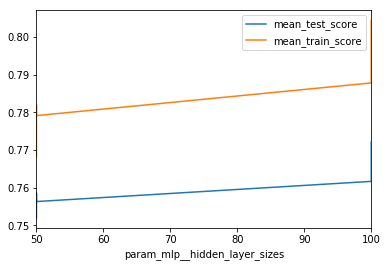

In [31]:
df2.plot('param_mlp__hidden_layer_sizes',['mean_test_score','mean_train_score'],kind = 'line')

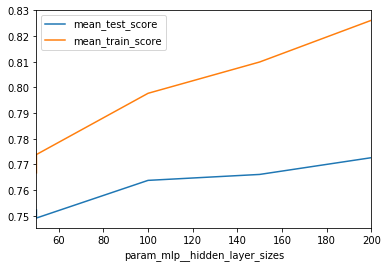

In [35]:
df4=df3[0:100:5]
df4.plot('param_mlp__hidden_layer_sizes',['mean_test_score','mean_train_score'],kind = 'line')

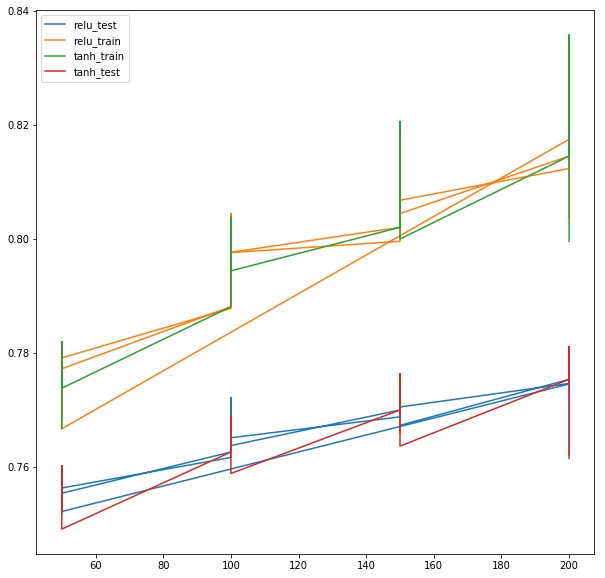

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(df1['param_mlp__hidden_layer_sizes'],df1['mean_test_score'],label='relu_test')
plt.plot(df1['param_mlp__hidden_layer_sizes'],df1['mean_train_score'],label='relu_train')
plt.plot(df3['param_mlp__hidden_layer_sizes'],df3['mean_train_score'],label='tanh_train')
plt.plot(df3['param_mlp__hidden_layer_sizes'],df3['mean_test_score'],label='tanh_test')
plt.legend()

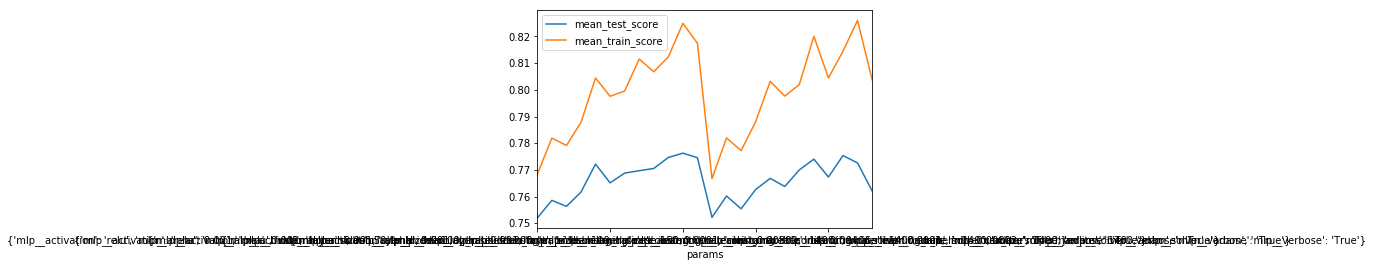

In [38]:
df1=df[0:70:2]
df1.plot('params',['mean_test_score','mean_train_score'],kind = 'line')